# Deep Convolutional GANs (DCGANs) by `Mr. Harshit Dawar!`

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers as ly
import tensorflow as tf

## Loading the dataset & Visualizing it!

In [47]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [48]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

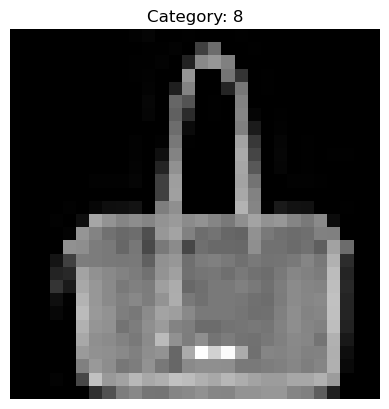

In [49]:
random_image = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[random_image], cmap = "gray")
plt.title("Category: " + str(y_train[random_image]))
plt.axis("off")
plt.show()

In [50]:
# Generating the 3rd Dimenstion for the image as per the requirement of the task
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [51]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
# X_train = tf.convert_to_tensor(X_train, dtype = tf.int64)
# X_test = tf.convert_to_tensor(X_test, dtype = tf.int64)

In [52]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [53]:
# Normalizing the images between -1 to 1
X_train = (X_train - 127.5) / 127.5

In [54]:
X_train.min(), X_train.max()

(-1.0, 1.0)

In [55]:
batch_size = 64
total_images = X_train.shape[0]
total_number_of_batches = total_images / batch_size

In [56]:
total_number_of_batches

937.5

In [57]:
X_train[0].dtype

dtype('float32')

In [58]:
# Changing the type of X_train from numpy array to tensorflow batchdataset
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(total_images).batch(batch_size)

In [59]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## Creating the Generator for the GANs

In [60]:
def generator_builder():
    model = tf.keras.Sequential()
    
    # For the Random Noise/Image of a vector shape of 100 
    model.add(ly.Dense(units = 7 * 7 * 256, use_bias = False, input_shape = (100, )))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # To Reshape the above flattened vector
    model.add(ly.Reshape((7, 7, 256)))
    
    # Conv2DTranspose Block 1 for generating a bigger image : Image size is 7x7x256
    model.add(ly.Conv2DTranspose(filters = 256, kernel_size = (3, 3), padding = "same", use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # Conv2DTranspose Block 2 for generating a bigger image : Image size is 14x14x64
    model.add(ly.Conv2DTranspose(filters = 64, kernel_size = (3, 3), padding = "same", strides = (2, 2), use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # Conv2DTranspose Block 3 for generating a bigger image : Image size is 28x28x1
    model.add(ly.Conv2DTranspose(filters = 1, kernel_size = (3, 3), padding = "same", strides = (2, 2), use_bias = True, activation = "tanh"))
    
    model.summary()
    return model

In [61]:
# Defining a generator
generator = generator_builder()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 256)        589824    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 256)       

In [62]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_7_input')>

In [63]:
random_noise = tf.random.normal([1, 100])

In [64]:
random_noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.0677847 ,  1.1501808 , -0.34861964,  0.5351587 , -0.8670802 ,
         0.07990424, -0.20183593, -0.00619979,  1.1949426 , -0.16395113,
        -0.7346975 , -0.42947397,  1.1240703 ,  0.44063085,  0.4121019 ,
         1.0329118 ,  0.6447805 ,  0.37485883,  0.01516604, -0.04820181,
        -0.94659877,  0.02335339,  0.7210615 , -0.21271083,  0.29217535,
        -0.5907522 ,  0.55491775, -0.92246795, -1.5016247 ,  1.1060355 ,
        -0.13009326,  1.0498219 , -1.5047833 ,  0.2501071 ,  1.0922875 ,
         0.32621214,  0.24347785, -0.33405435, -1.5651023 , -0.5732417 ,
         1.3305812 ,  1.8057486 ,  0.6902788 , -0.50154877, -0.34243473,
         1.5604472 , -0.8817644 , -0.263448  ,  0.9133284 ,  0.61005276,
        -0.09471206, -0.65463984,  0.46595705, -0.27850607, -0.20390604,
        -1.1812371 ,  1.0816156 ,  0.0432986 , -0.8583803 , -0.86319137,
        -2.896917  ,  0.91061056, -0.9950468 , -2.4051483 , -0.9577996 ,
 

In [65]:
random_image_generated_from_generator = generator(random_noise, training = False)

In [66]:
random_image_generated_from_generator.shape

TensorShape([1, 28, 28, 1])

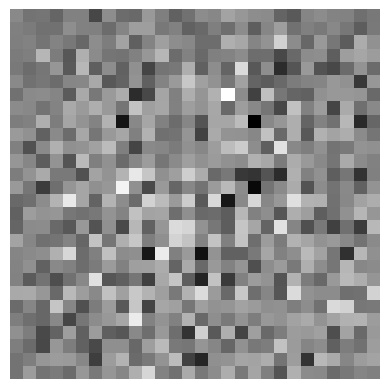

In [67]:
plt.imshow(random_image_generated_from_generator[0], cmap = "gray")
plt.axis("off")
plt.show()

## Creating the Discriminator for the GANs

In [68]:
def discriminator_builder():
    model = tf.keras.Sequential()
    
    # Image Shape: 14x14x64
    model.add(ly.Conv2D(filters = 64, kernel_size = (3, 3), input_shape = [28, 28, 1], strides = (2, 2), padding = "same"))
    model.add(ly.LeakyReLU())
    model.add(ly.Dropout(0.3))
    
    # Image Shape: 7x7x128
    model.add(ly.Conv2D(filters = 128, kernel_size = (3, 3), strides = (2, 2), padding = "same"))
    model.add(ly.LeakyReLU())
    model.add(ly.Dropout(0.3))
    
    # # Image Shape: 7x7x128
    # model.add(ly.Conv2D(filters = 128, kernel_size = (3, 3), padding = "same"))
    # model.add(ly.LeakyReLU())
    # model.add(ly.Dropout(0.3))
    
    # Flattening the network
    model.add(ly.Flatten())
    model.add(ly.Dense(units = 1))  # To get the logits only
    
    model.summary()
    return model

In [69]:
discriminator = discriminator_builder()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_17 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_6 (Flatten)         (None, 6272)             

In [70]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_16_input')>

In [71]:
discriminator(random_image_generated_from_generator, training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00038536]], dtype=float32)>

In [72]:
# Around 50% is the answer, that means its a guess, & this is the expected behaviour since the model is not trained.
tf.sigmoid(0.00016921)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5000423>

## Creating the Error Calculator
* It will compare the prediction of discriminator on real images with an array of 1, & the prediction of discriminator on fake (generated) images with an array of 0.

In [73]:
# Since only 2 classes are there, that are real & fake, Binary Crossentropy loss is used.
cross_entropy_loss_calculator = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [74]:
def discriminator_loss_calculator(real_thing, generated_thing):
    real_loss = cross_entropy_loss_calculator(tf.ones_like(real_thing), real_thing)
    fake_loss = cross_entropy_loss_calculator(tf.zeros_like(generated_thing), generated_thing)
    return real_loss + fake_loss

In [75]:
def generator_loss(generated_thing):
    return cross_entropy_loss_calculator(tf.ones_like(generated_thing), generated_thing)

In [76]:
# Creating the Optimizers
generator_optimzer = tf.keras.optimizers.Adam()
discriminator_optimzer = tf.keras.optimizers.Adam()

## Training the DCGan Model!

In [77]:
batch_size

64

In [78]:
# @tf.function
def train(images):
    # Generating random noise of the size (batch size of total real images, 100)
    noise = tf.random.normal([batch_size, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_images = generator(noise, training = True)
        
        real_images_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss_calculator(real_thing = real_images_output, generated_thing = fake_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    generator_optimzer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimzer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [79]:
def train_visualize_DCGAN(data, test_images, epochs = 50):
    for epoch in range(epochs):
        for batch_of_image in data:
            train(batch_of_image)
            
        print("Epoch: ", epoch + 1)
        generated_images = generator(test_images, training = False)
        plt.figure(figsize = (15,15))
        for i in range(generated_images.shape[0]):
            plt.subplot(5, 5,i + 1)
            plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
            plt.axis('off')
        plt.show()

Epoch:  1


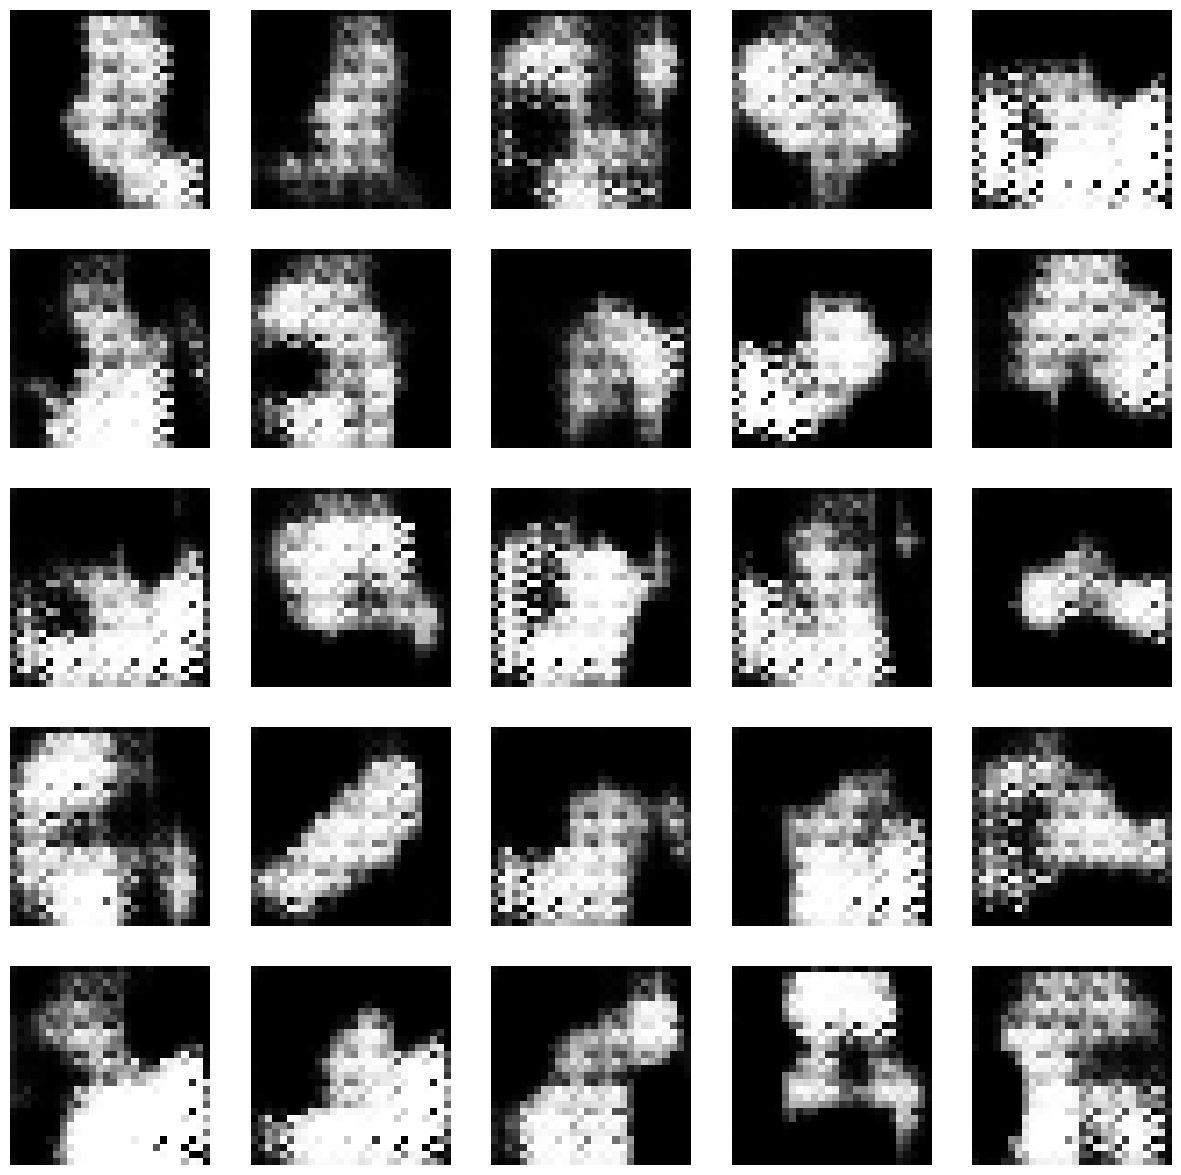

Epoch:  2


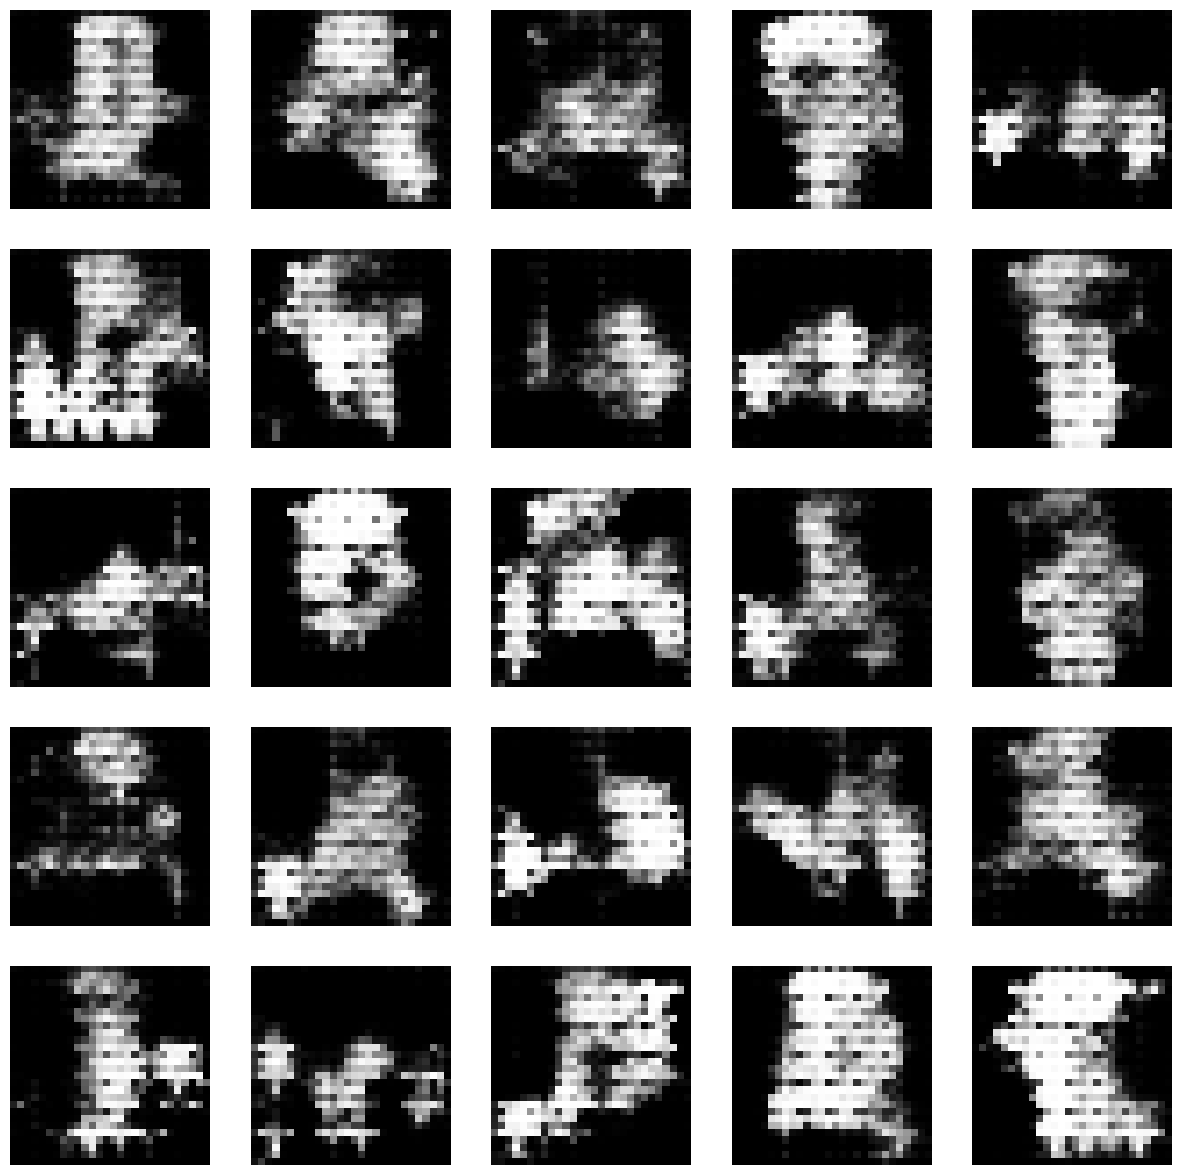

Epoch:  3


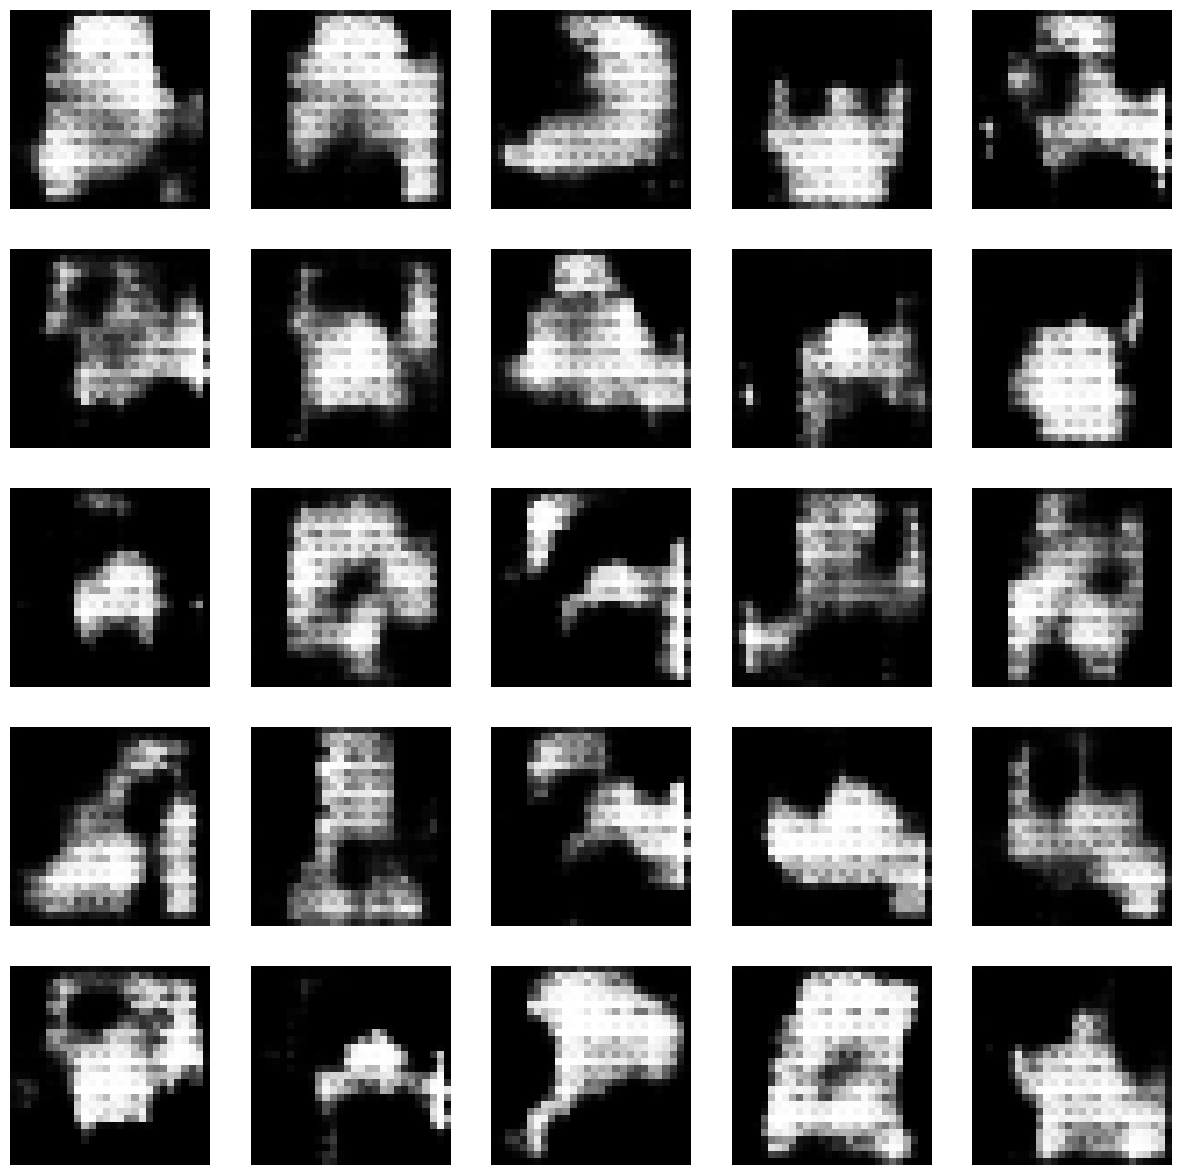

Epoch:  4


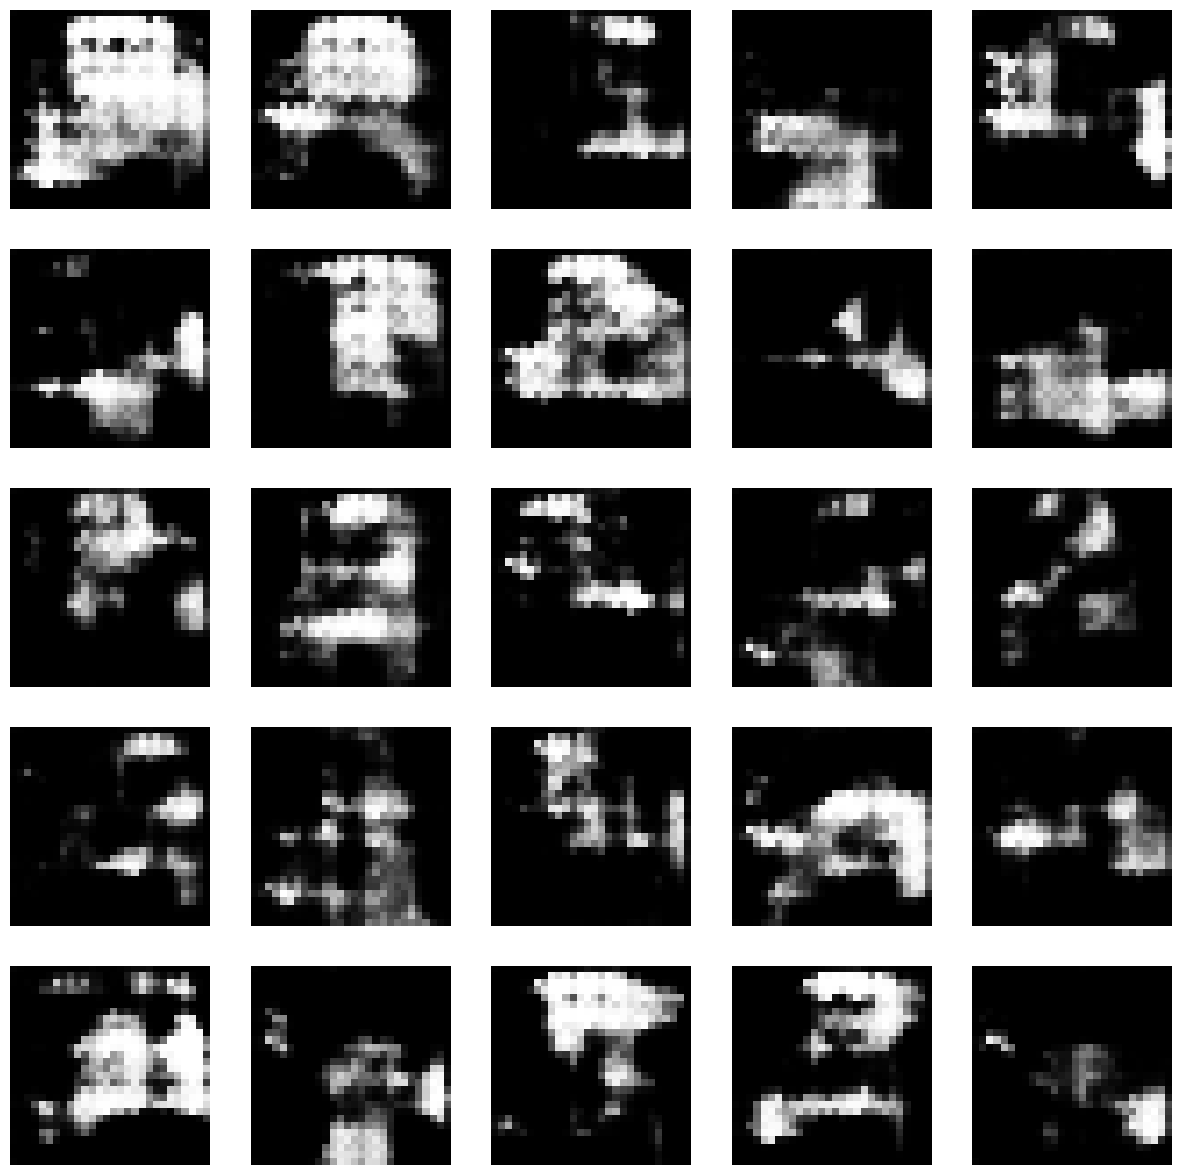

Epoch:  5


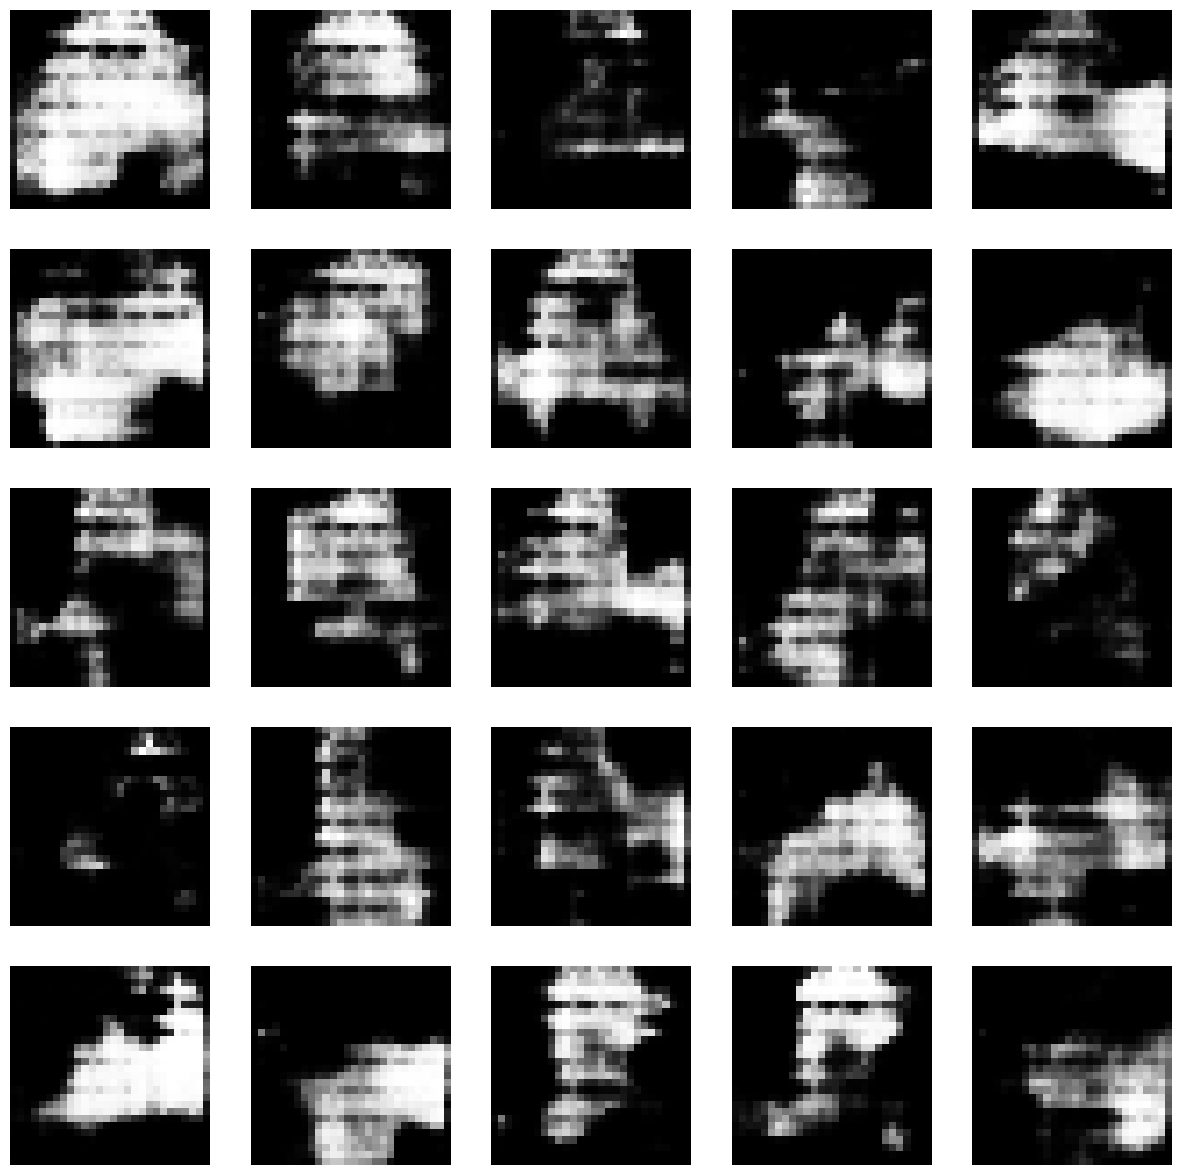

Epoch:  6


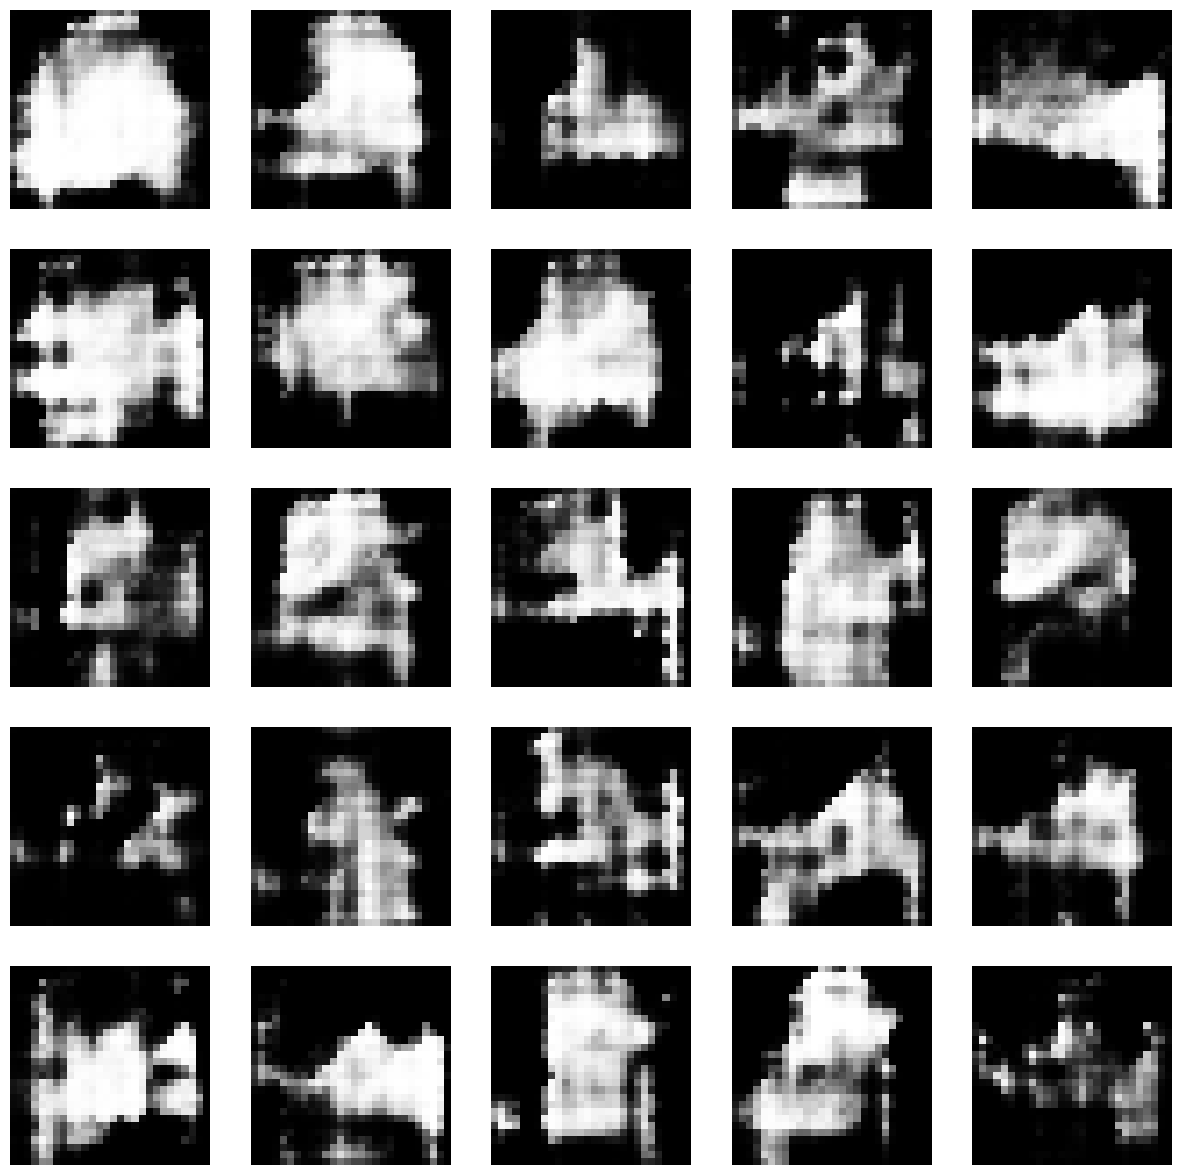

Epoch:  7


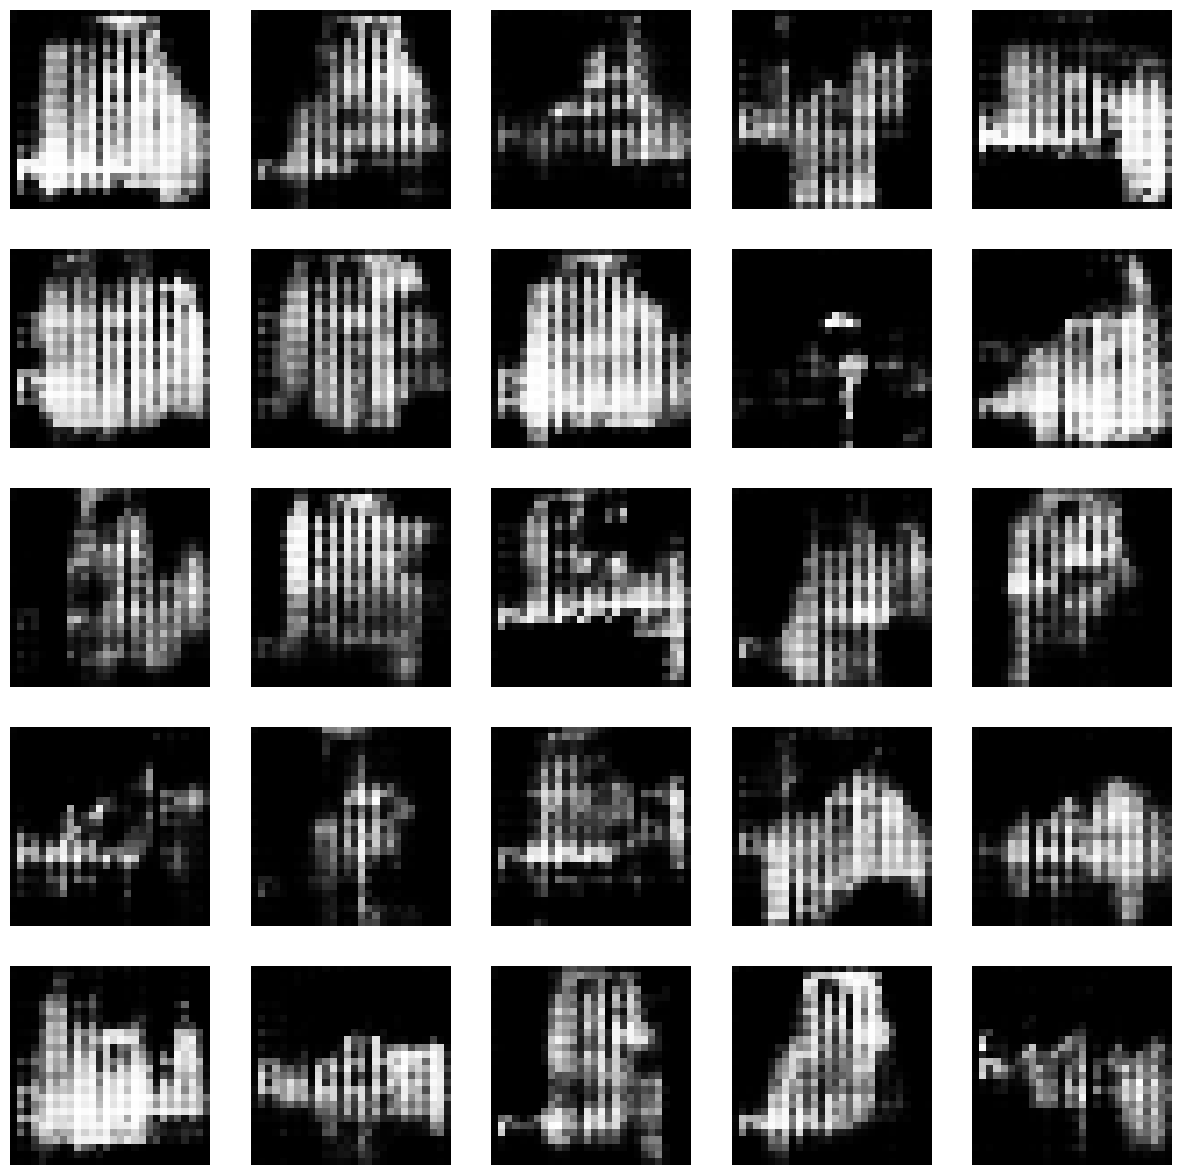

Epoch:  8


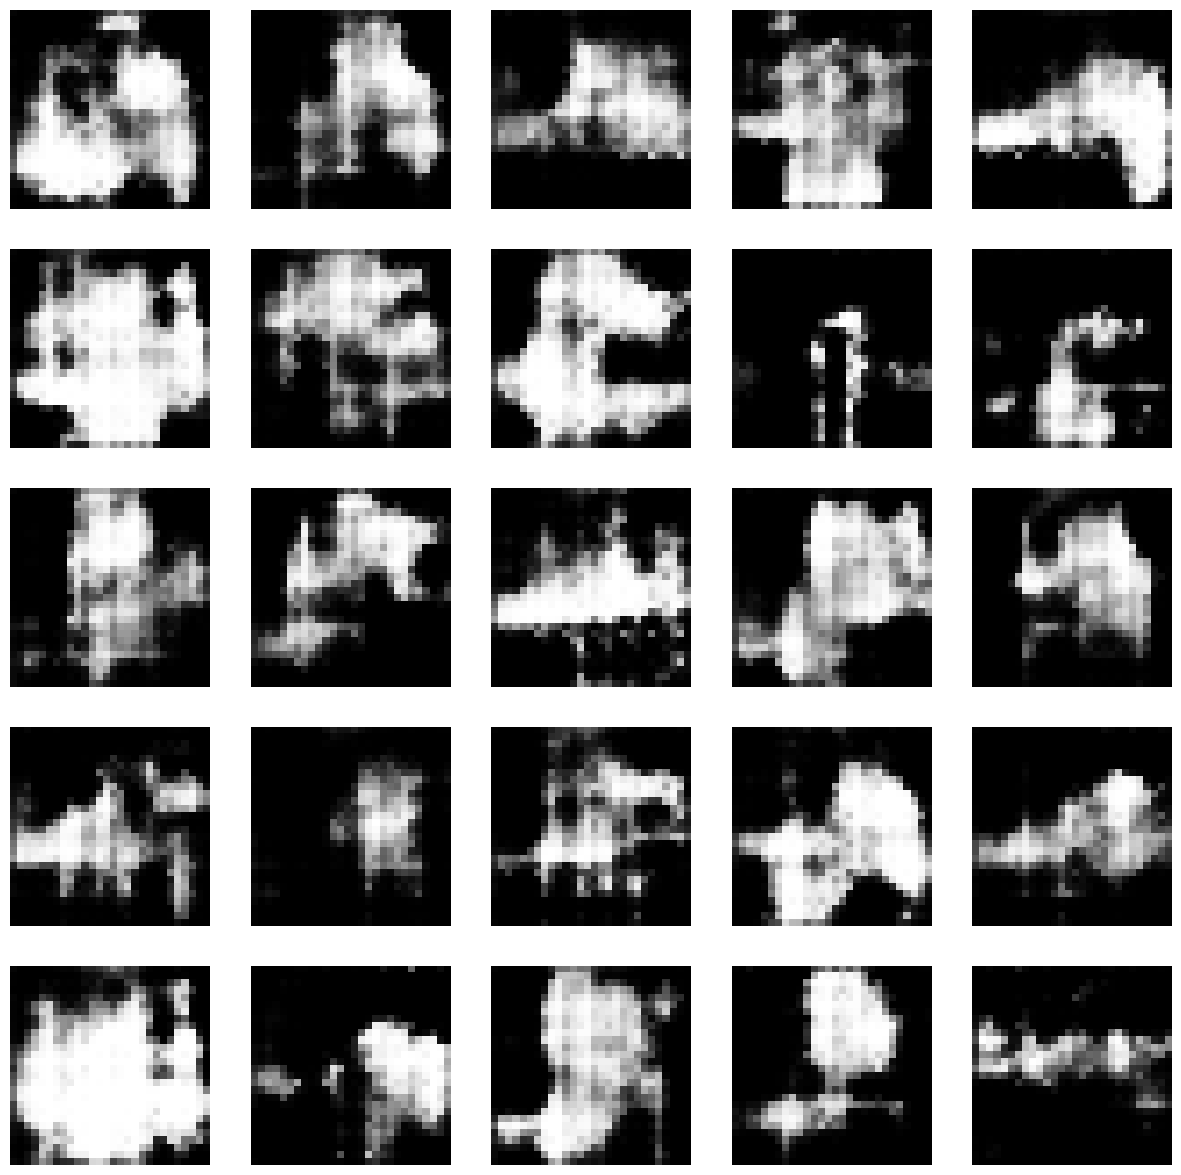

Epoch:  9


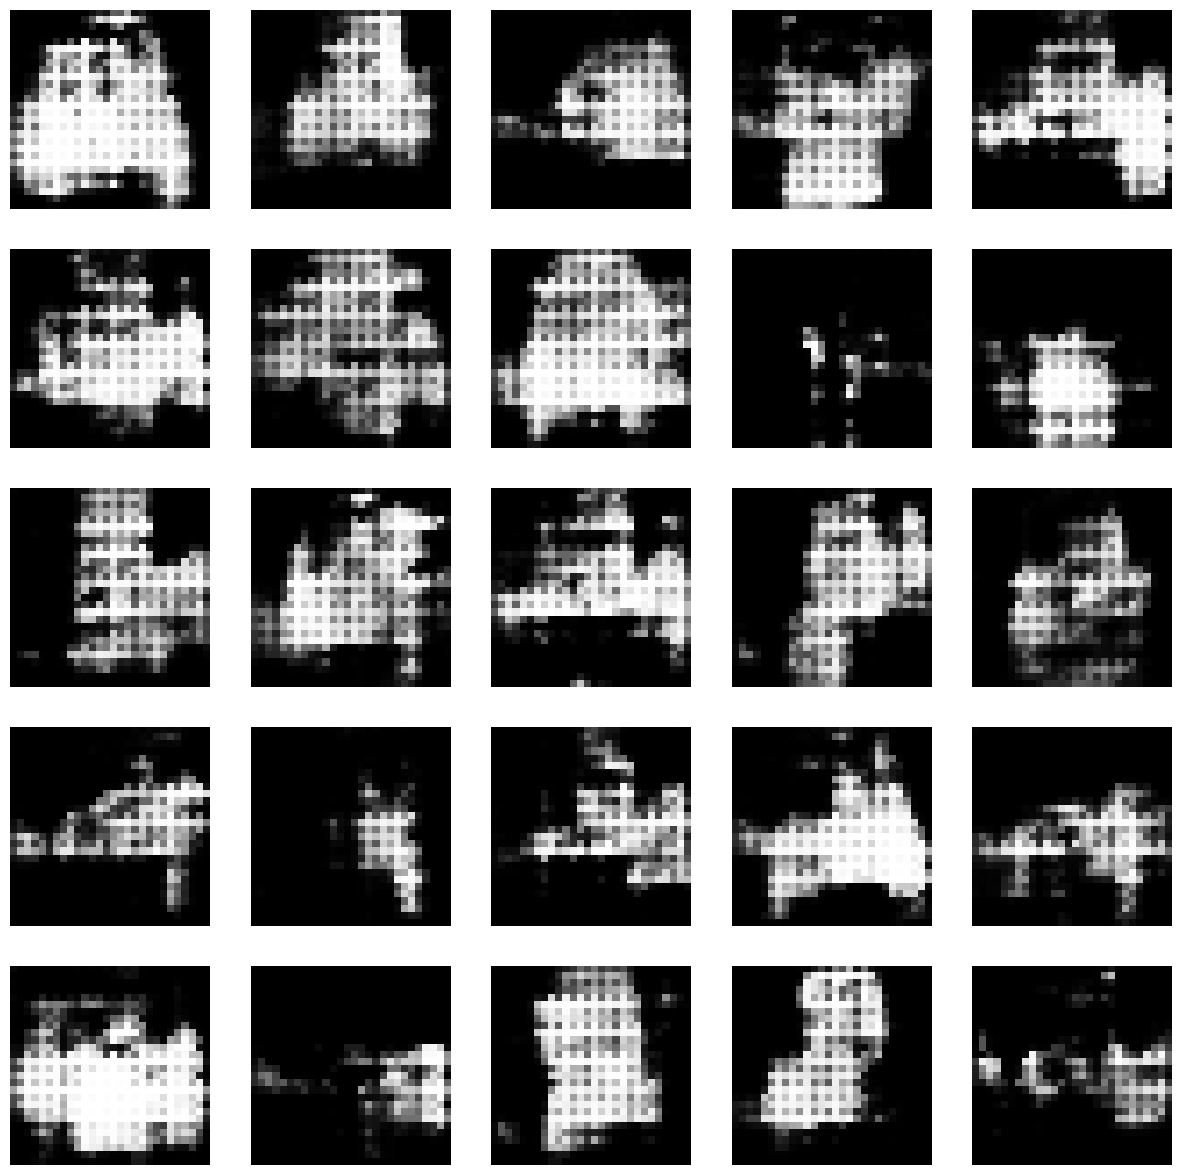

Epoch:  10


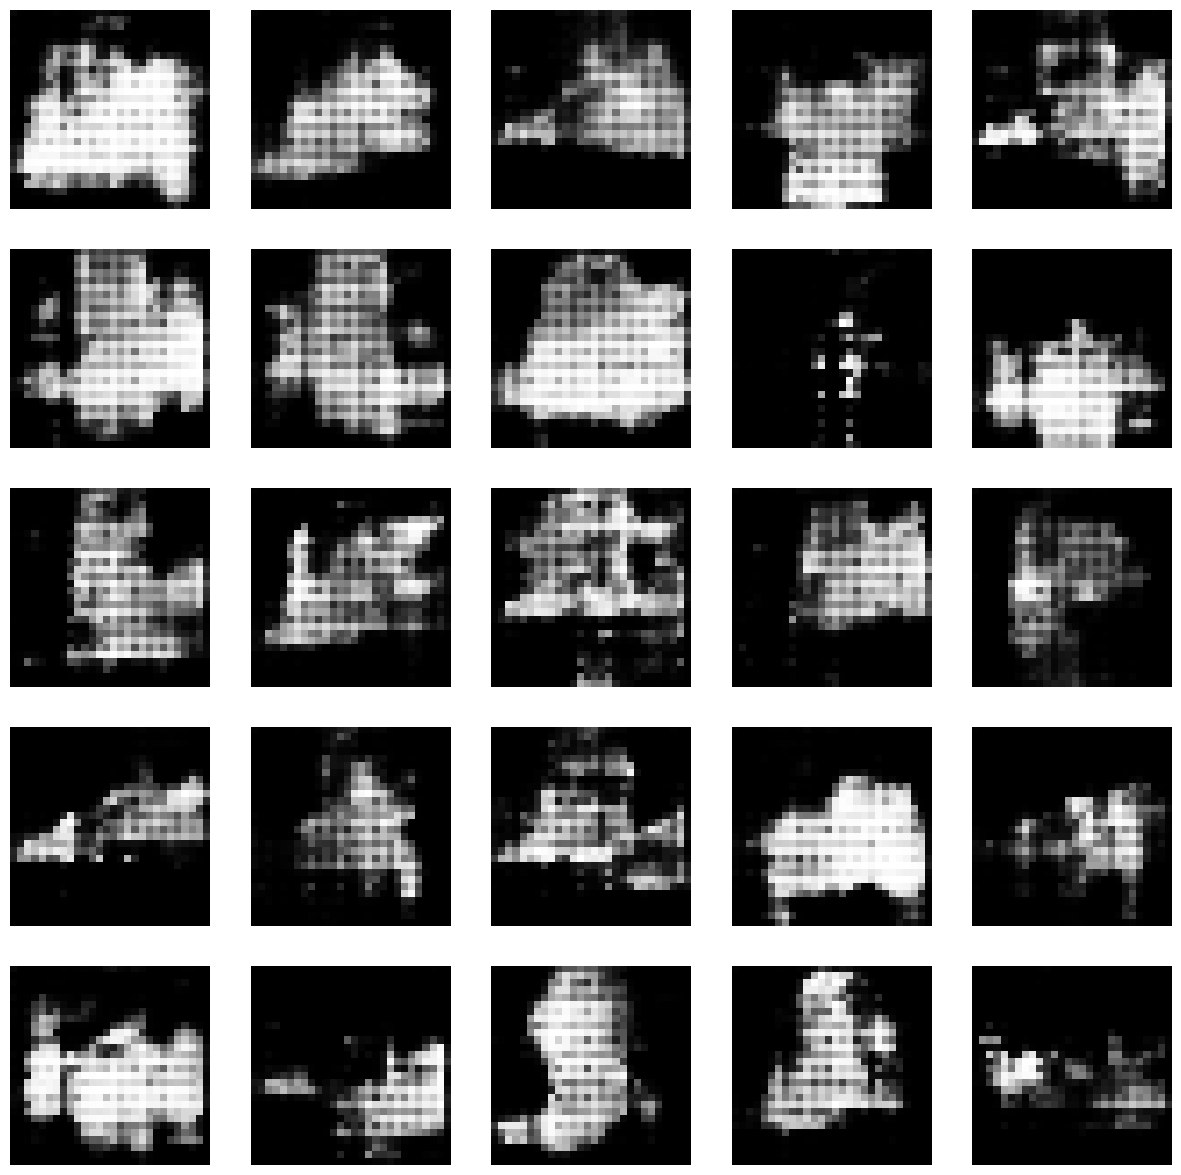

Epoch:  11


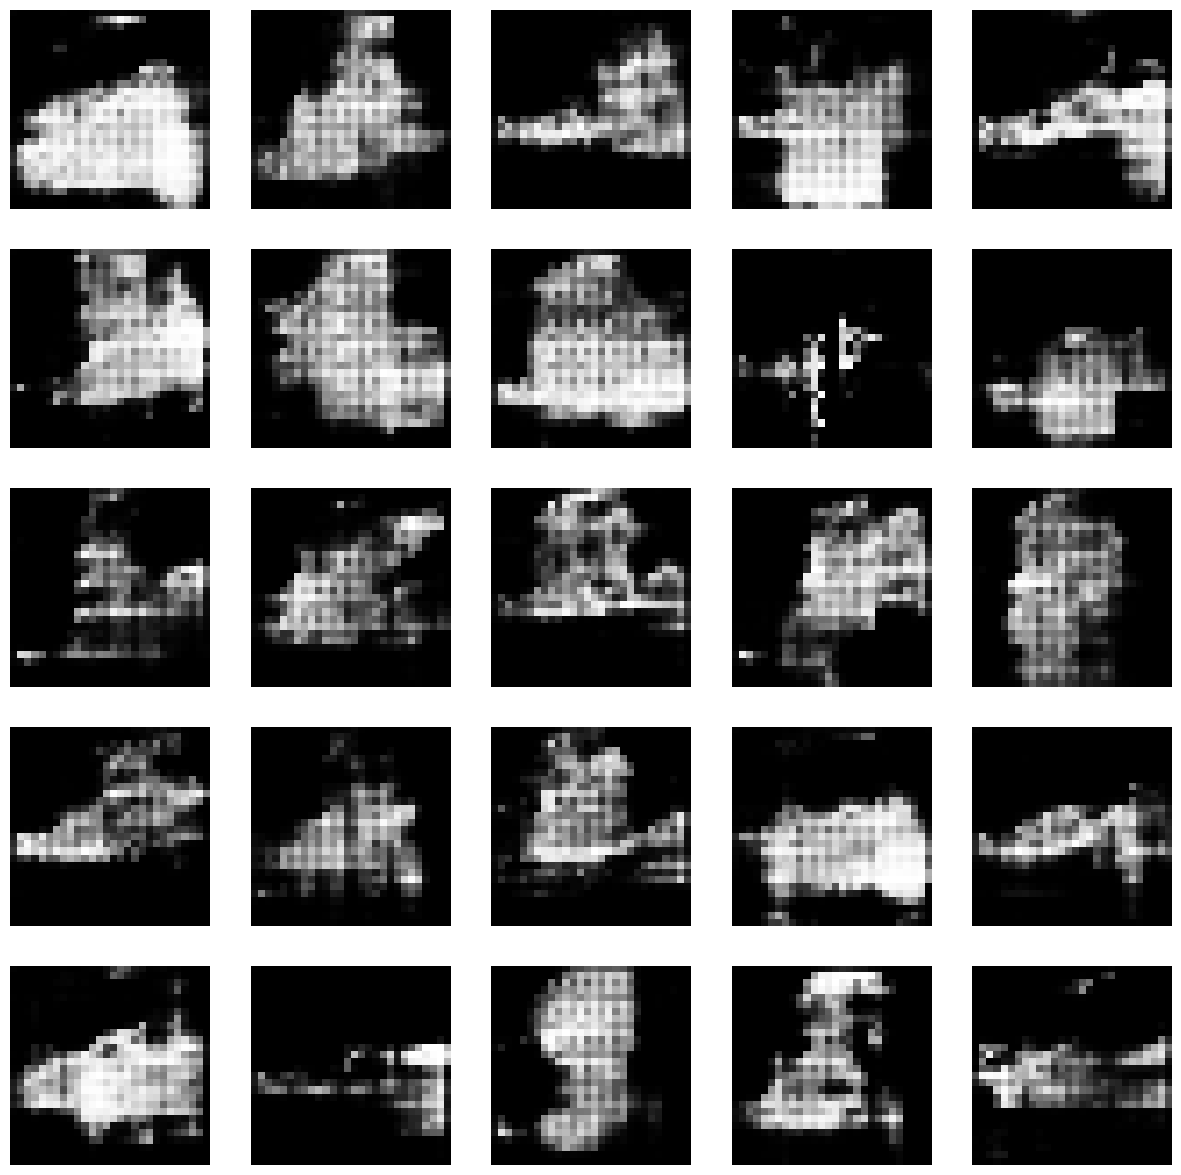

Epoch:  12


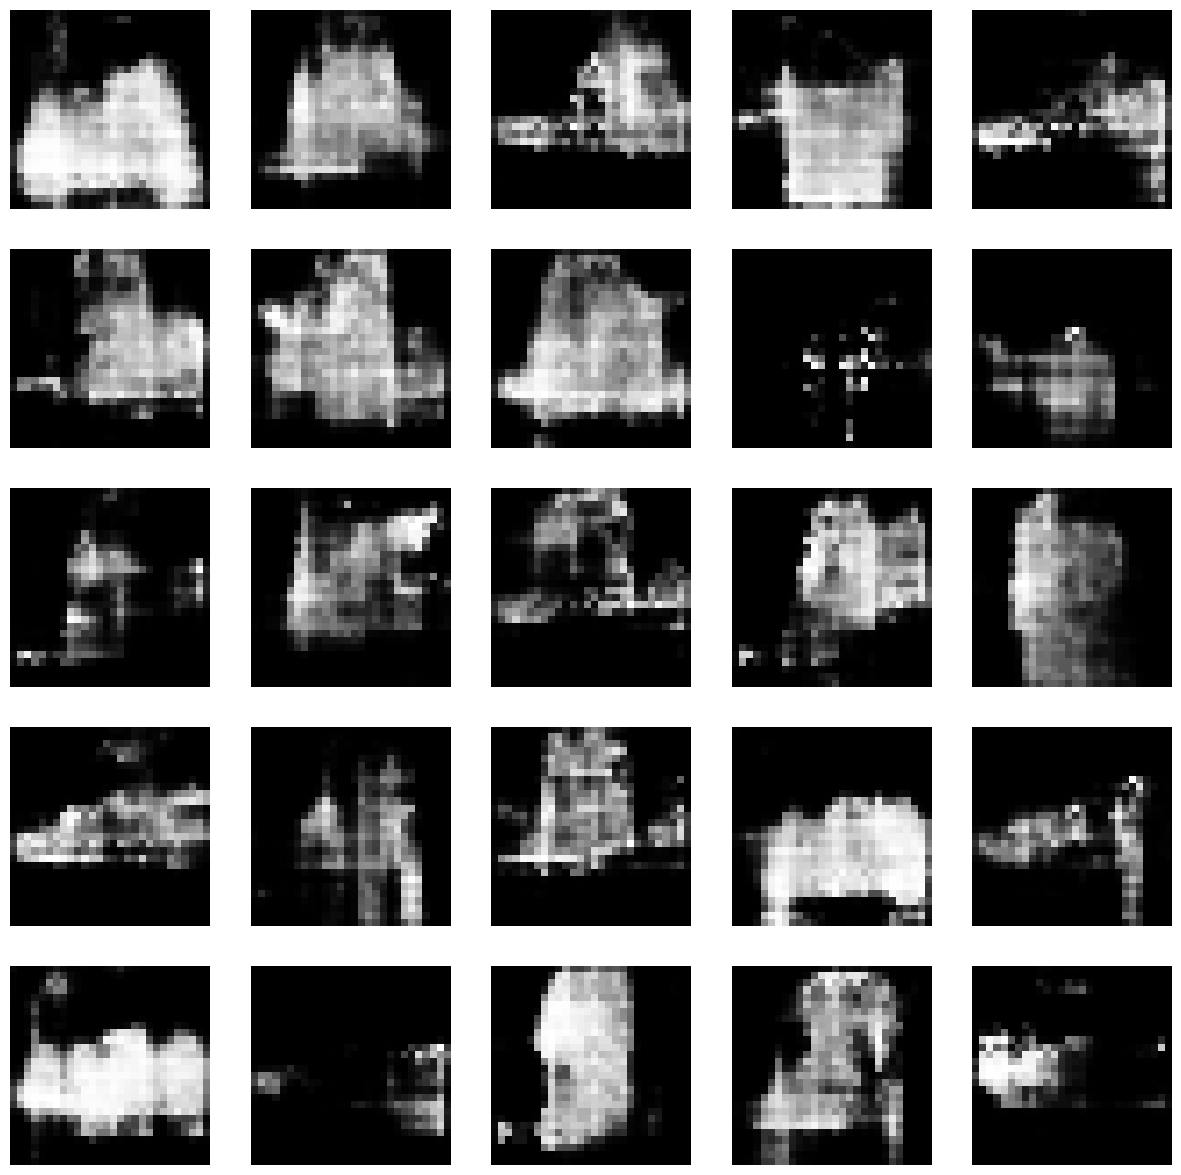

Epoch:  13


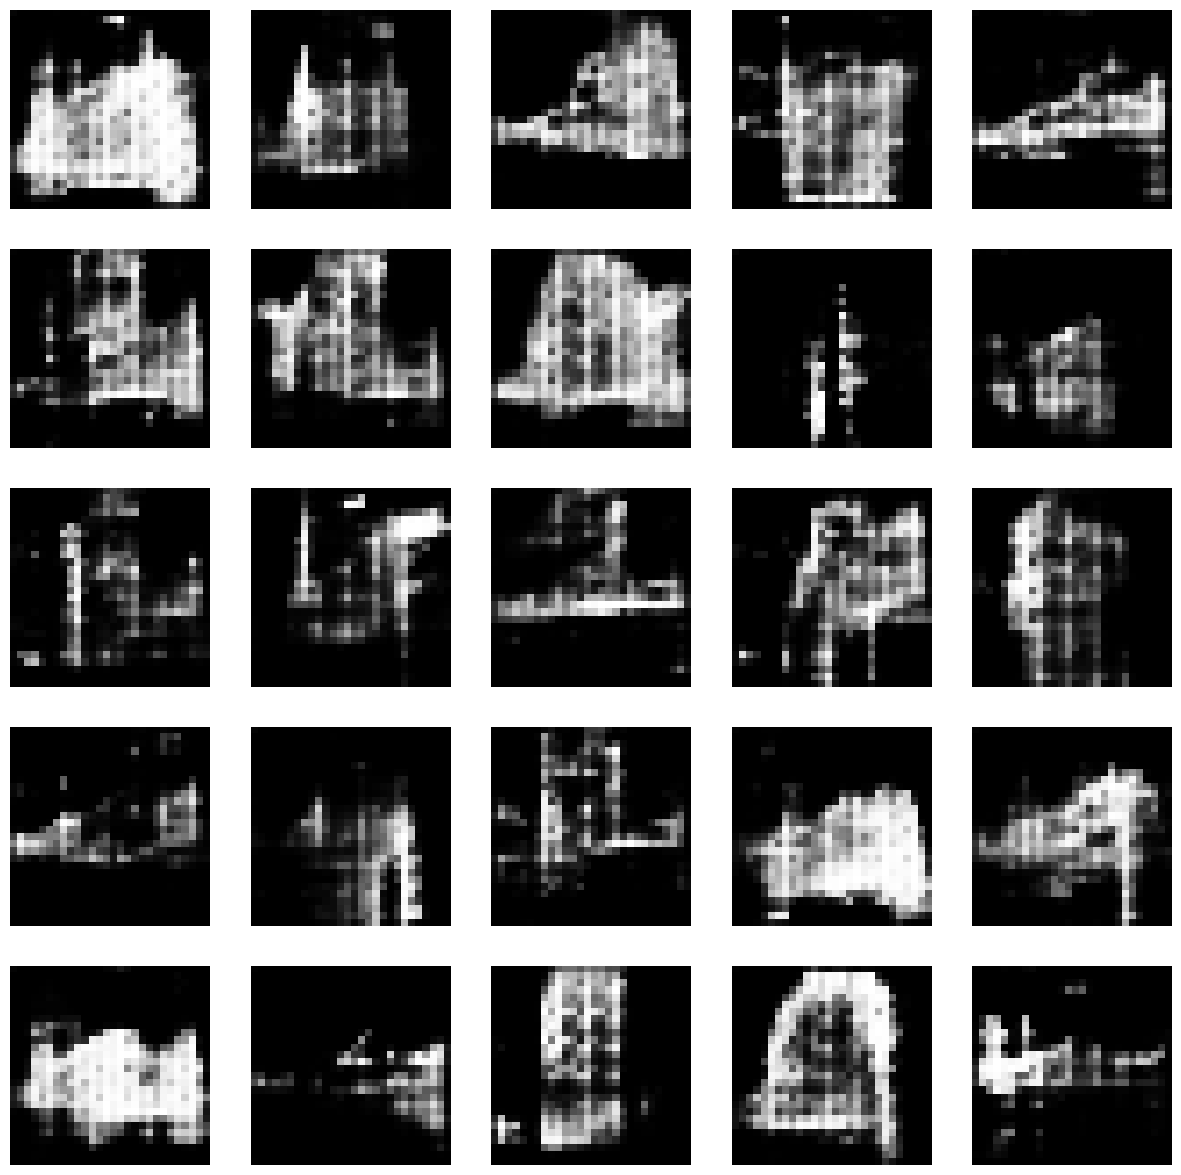

Epoch:  14


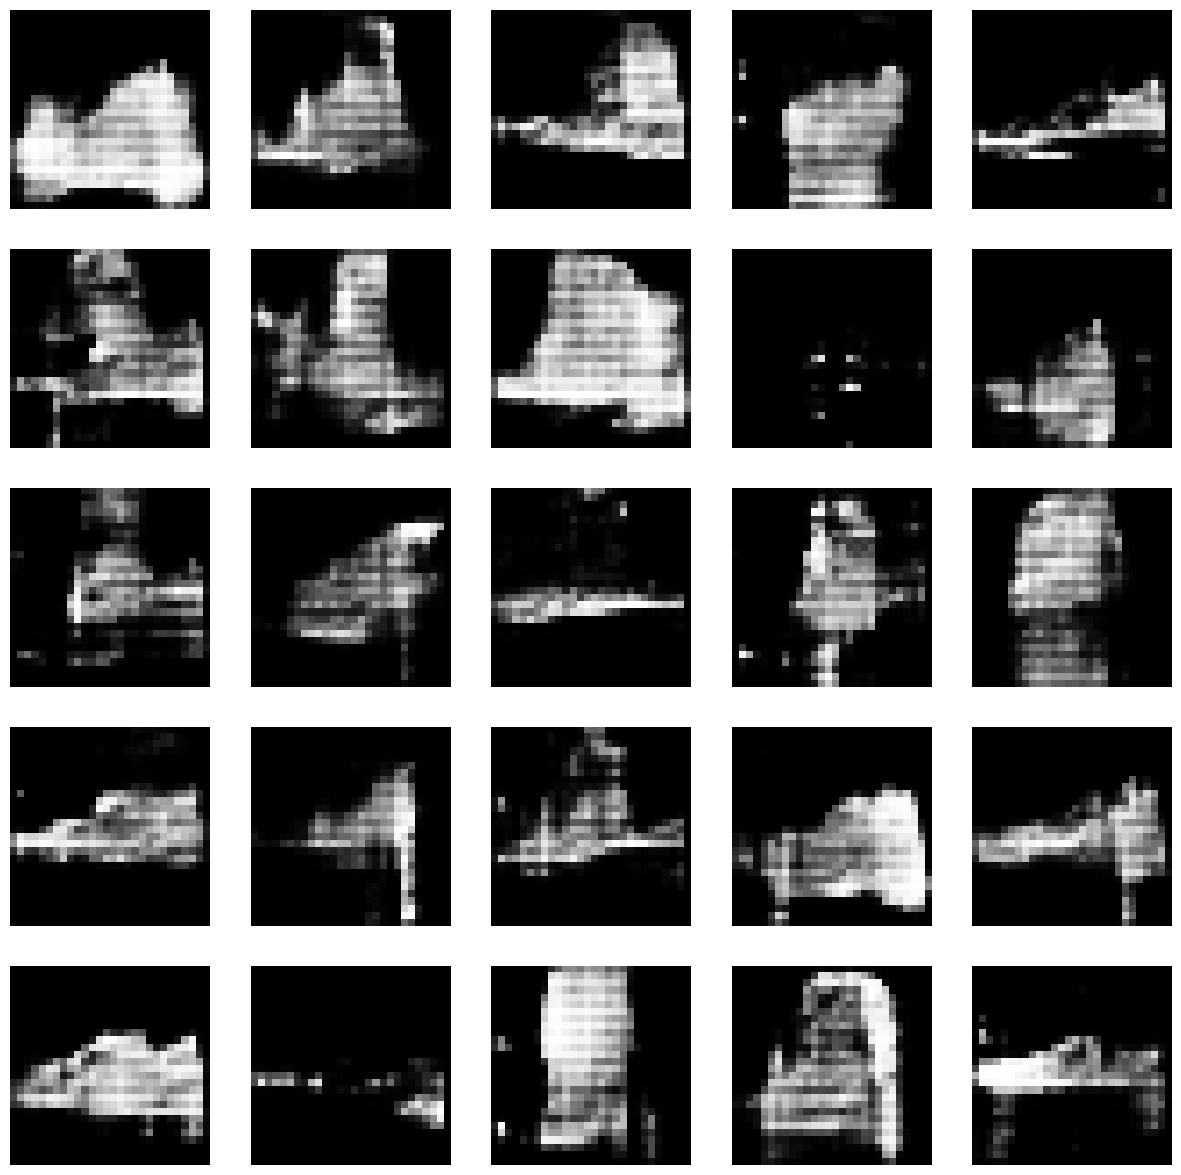

Epoch:  15


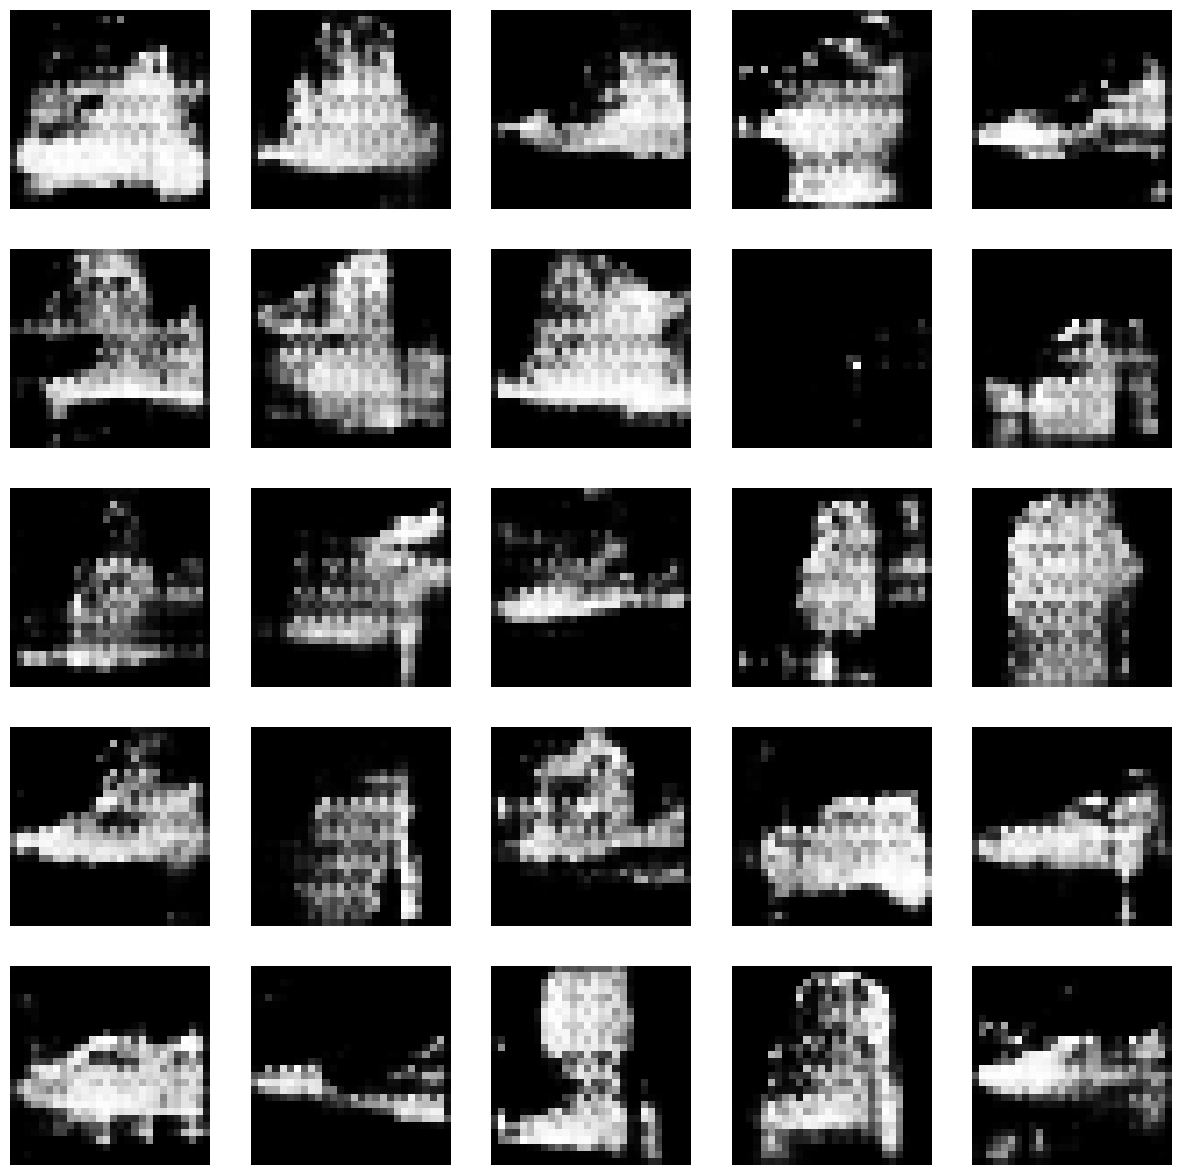

Epoch:  16


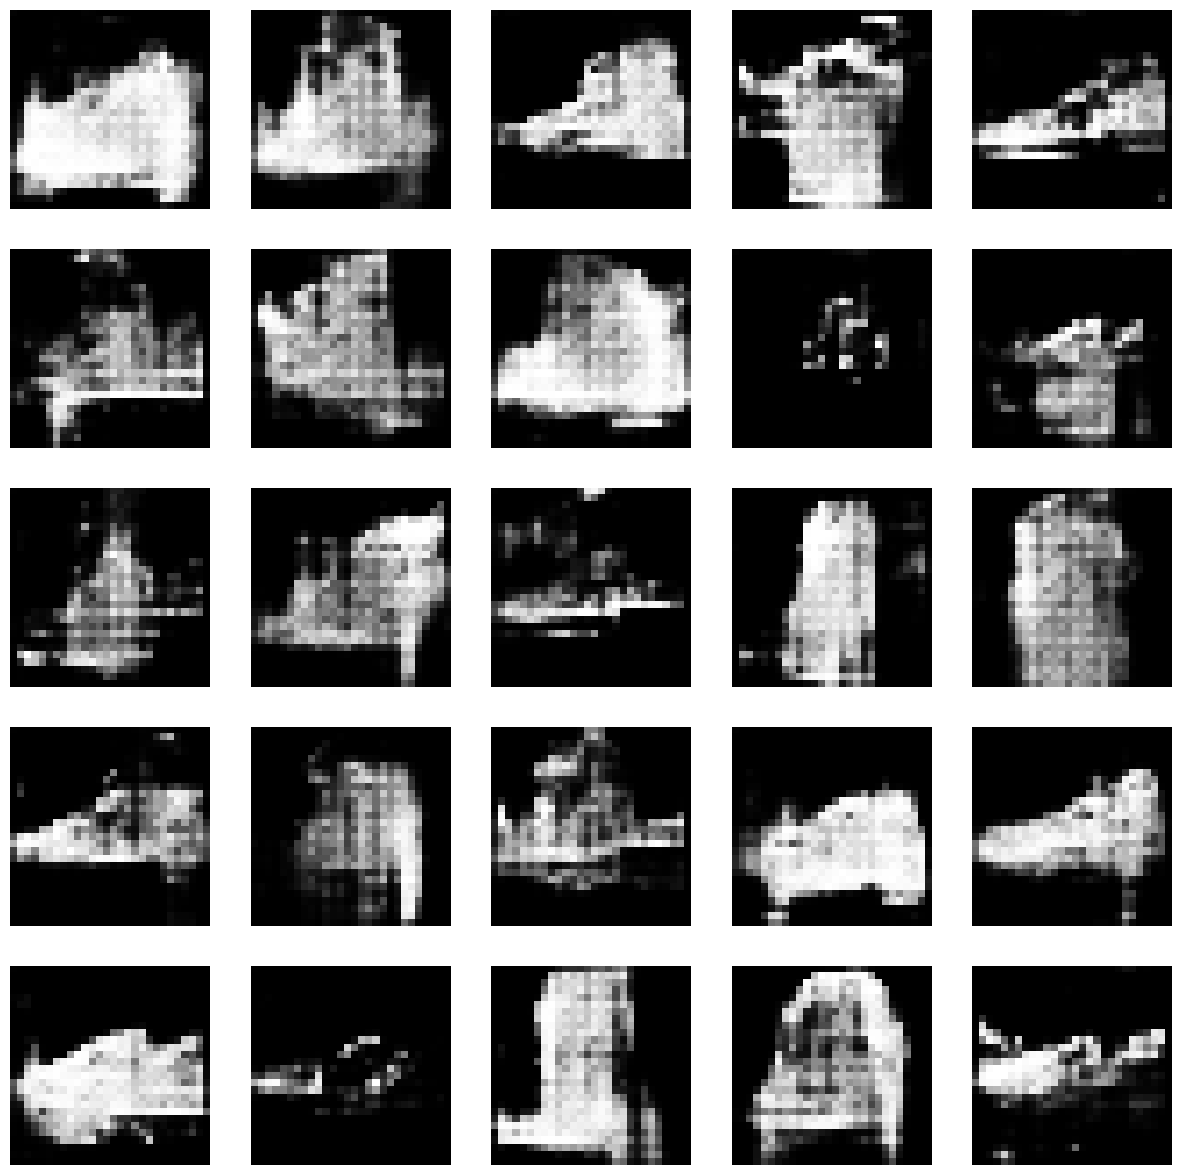

Epoch:  17


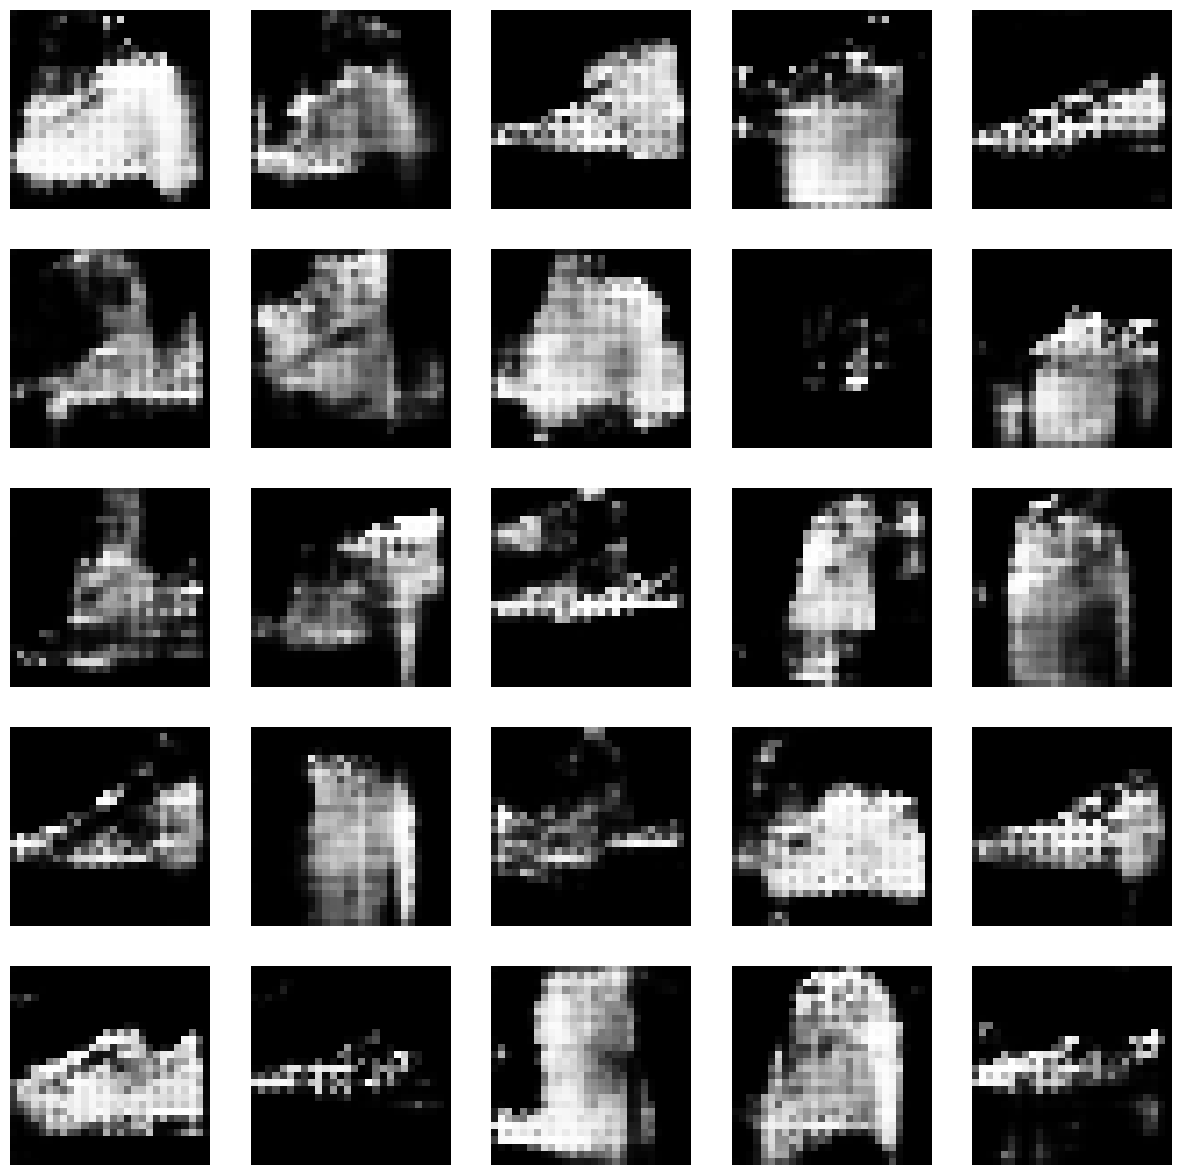

Epoch:  18


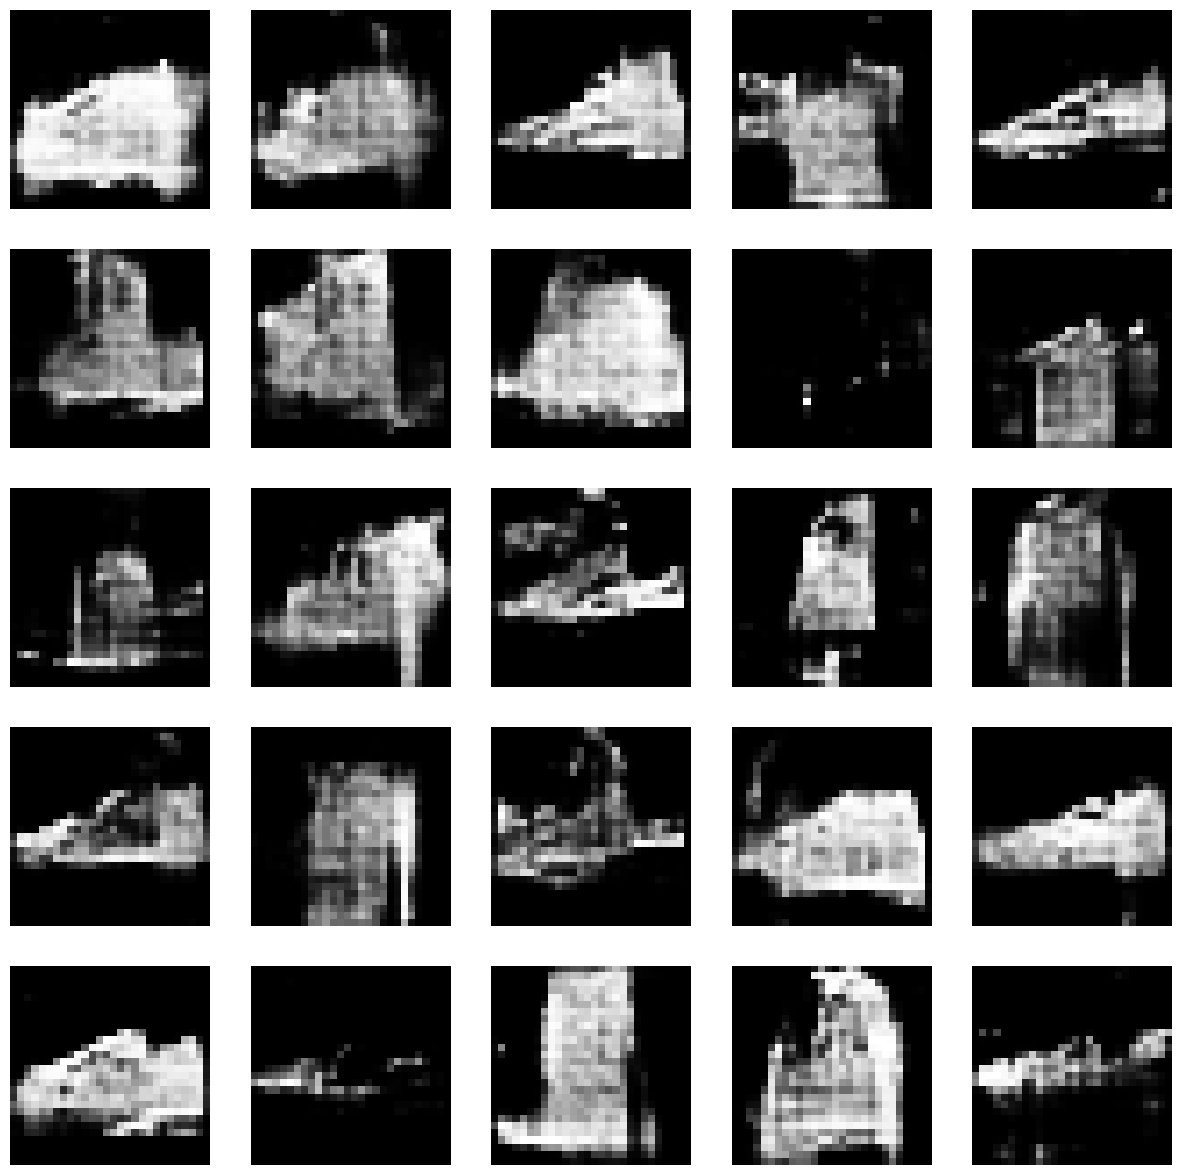

Epoch:  19


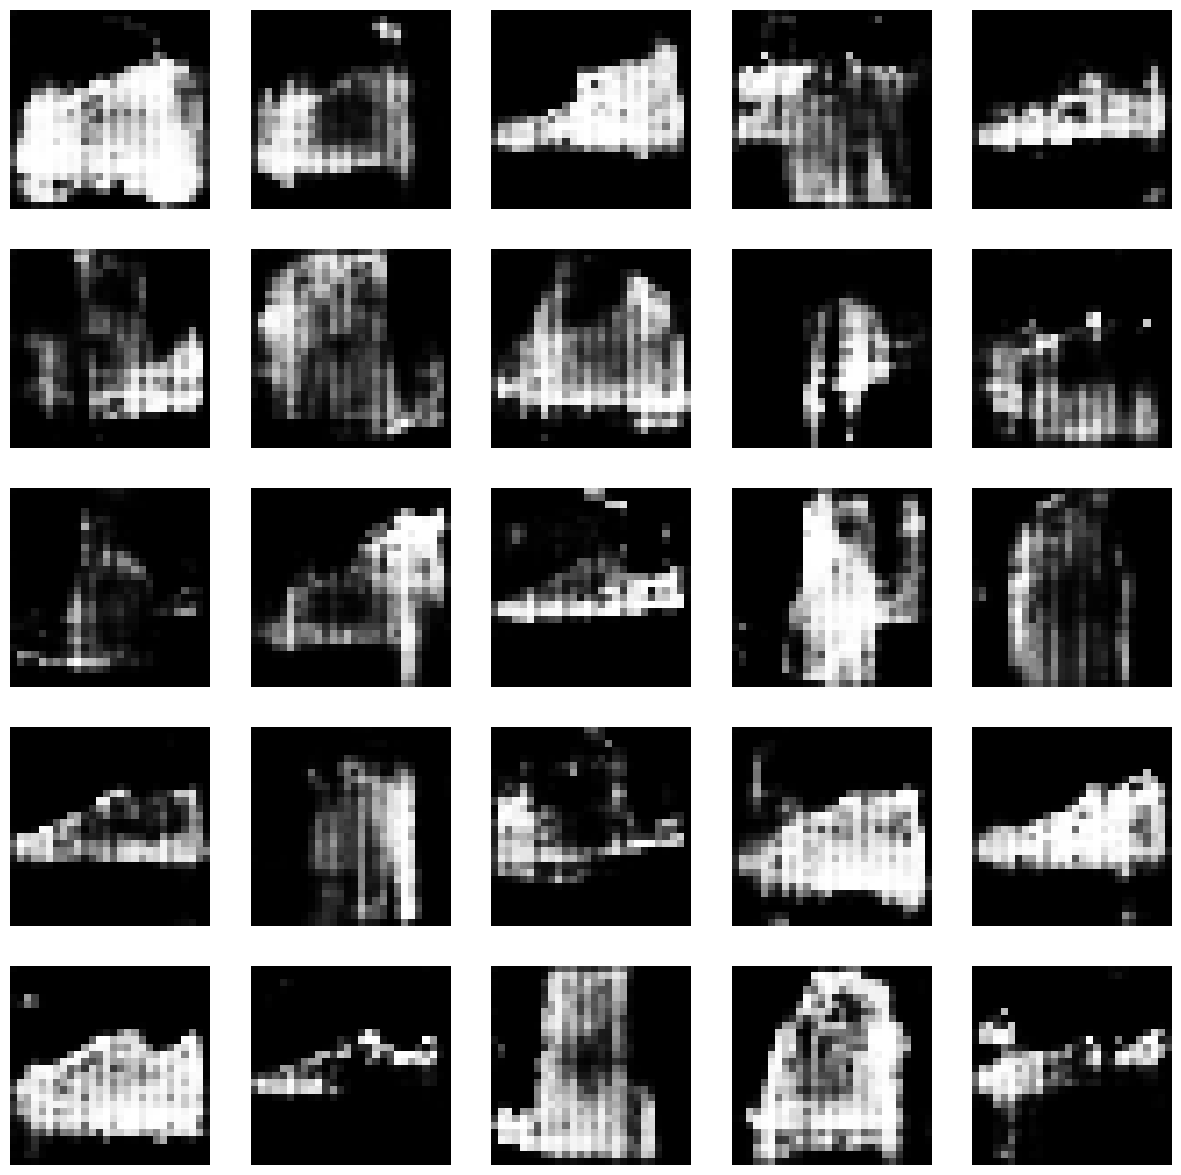

Epoch:  20


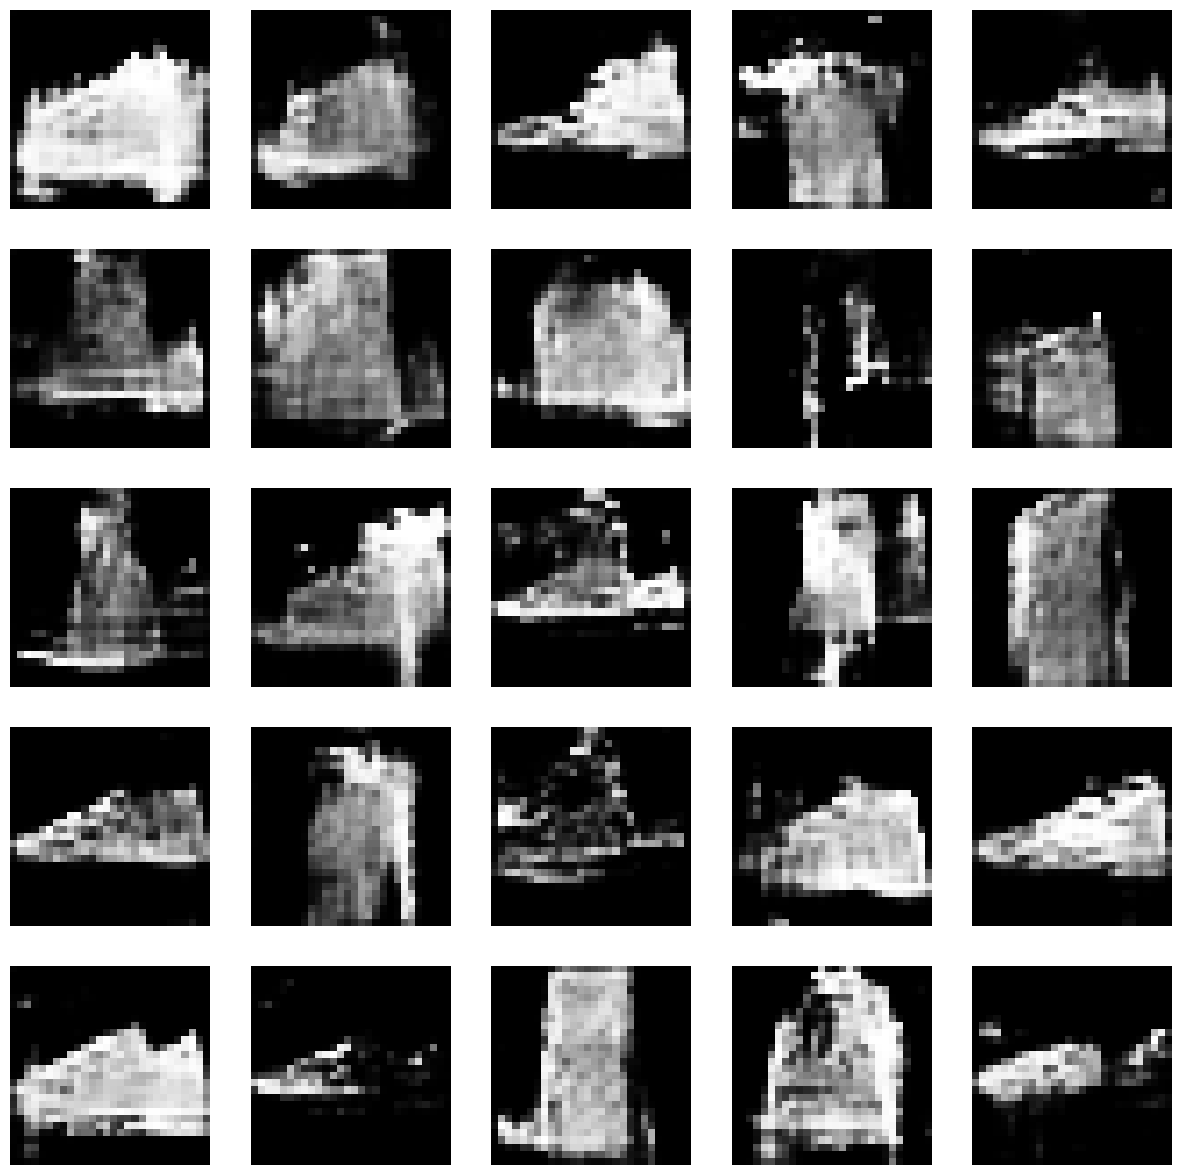

Epoch:  21


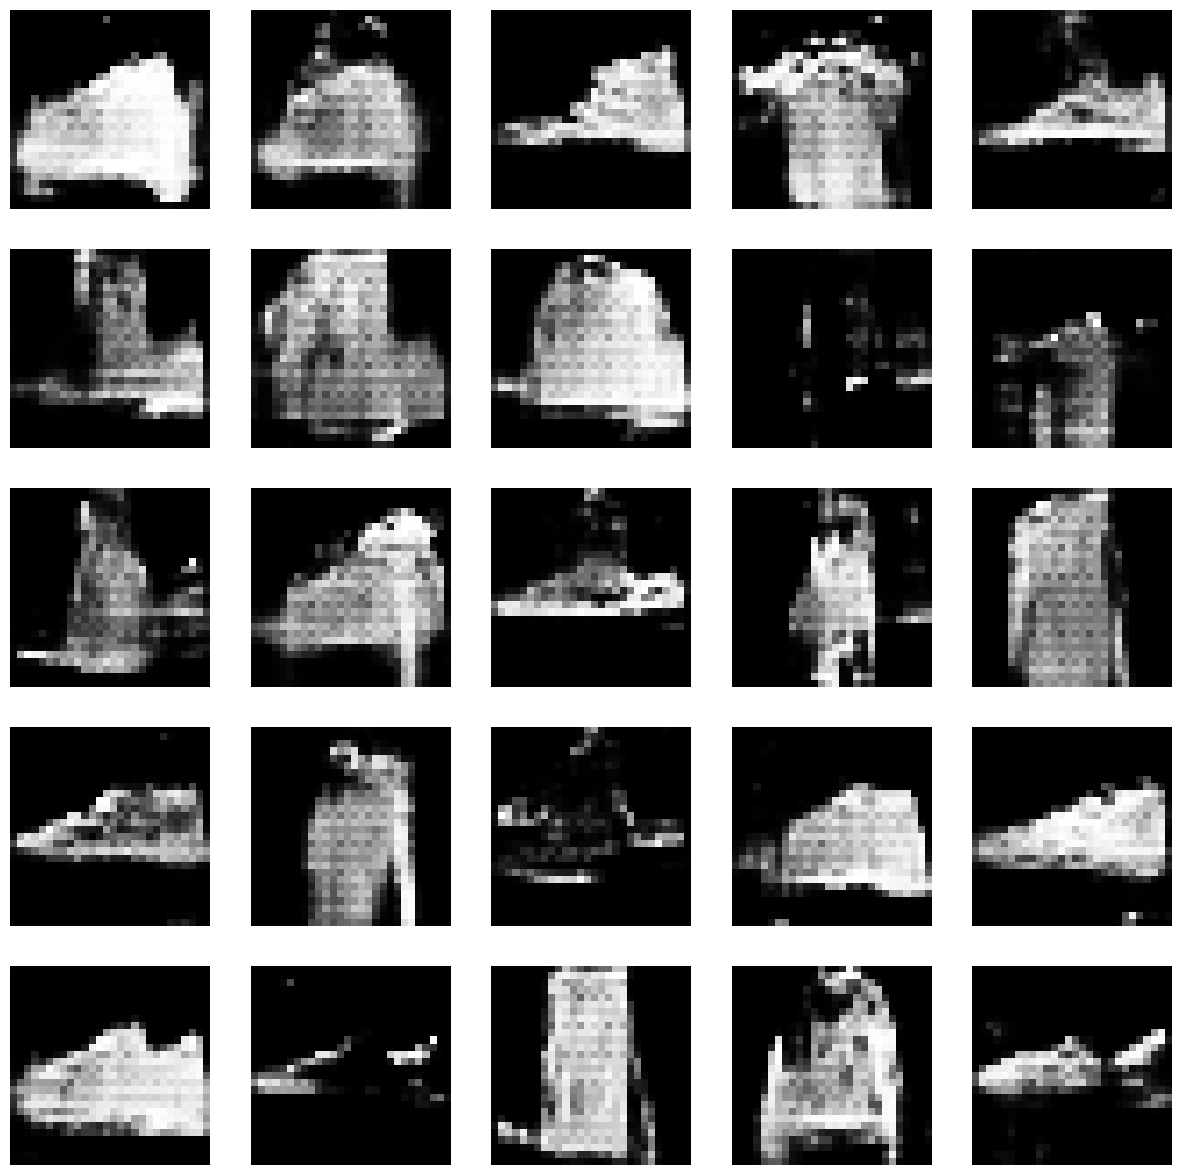

Epoch:  22


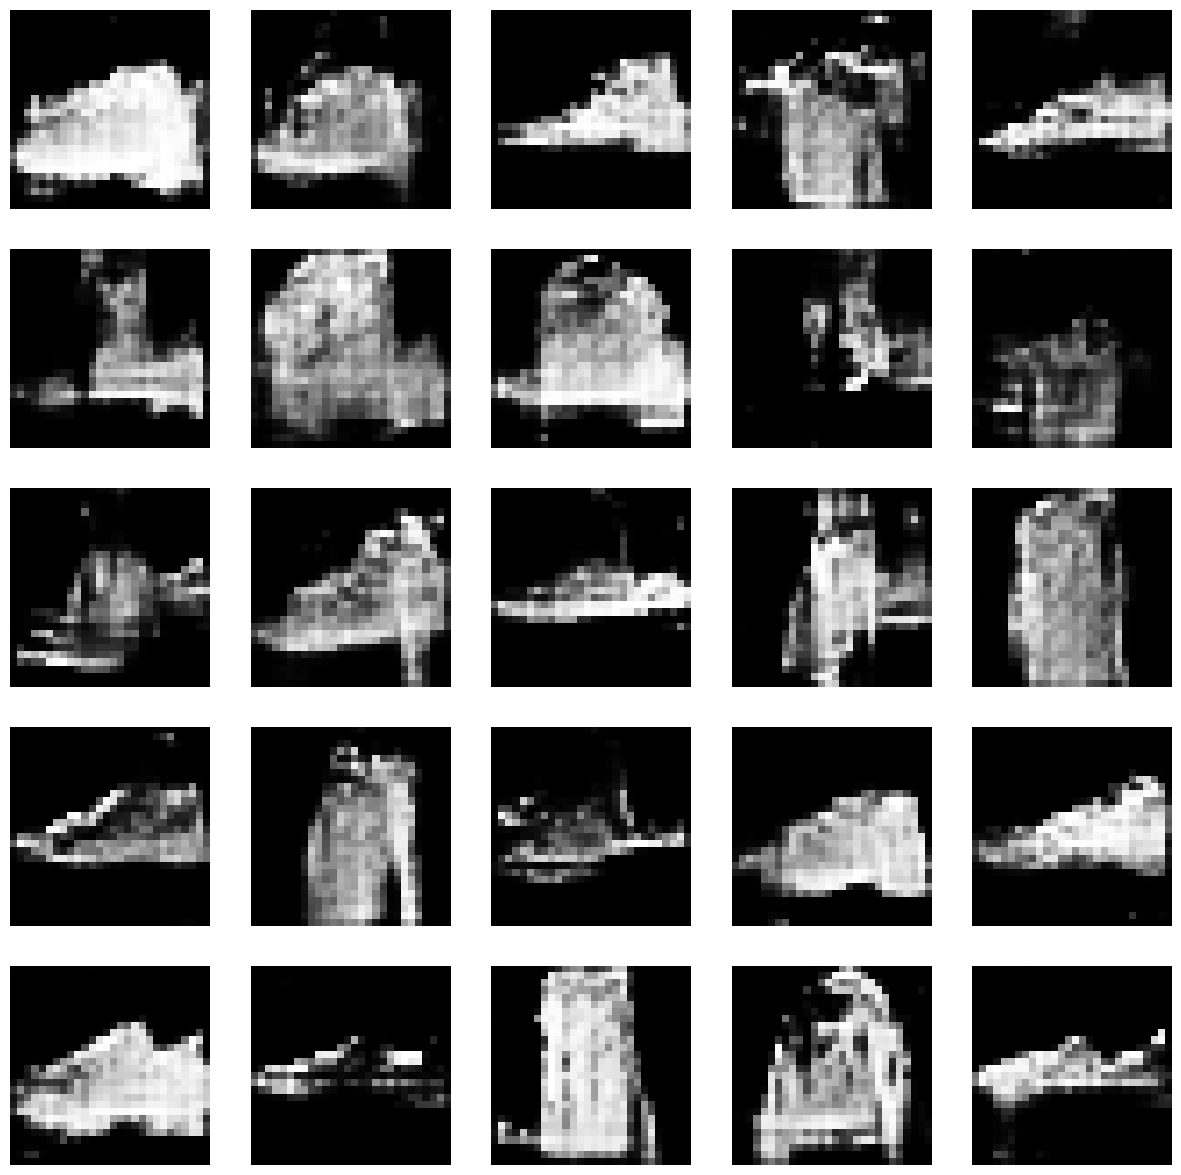

Epoch:  23


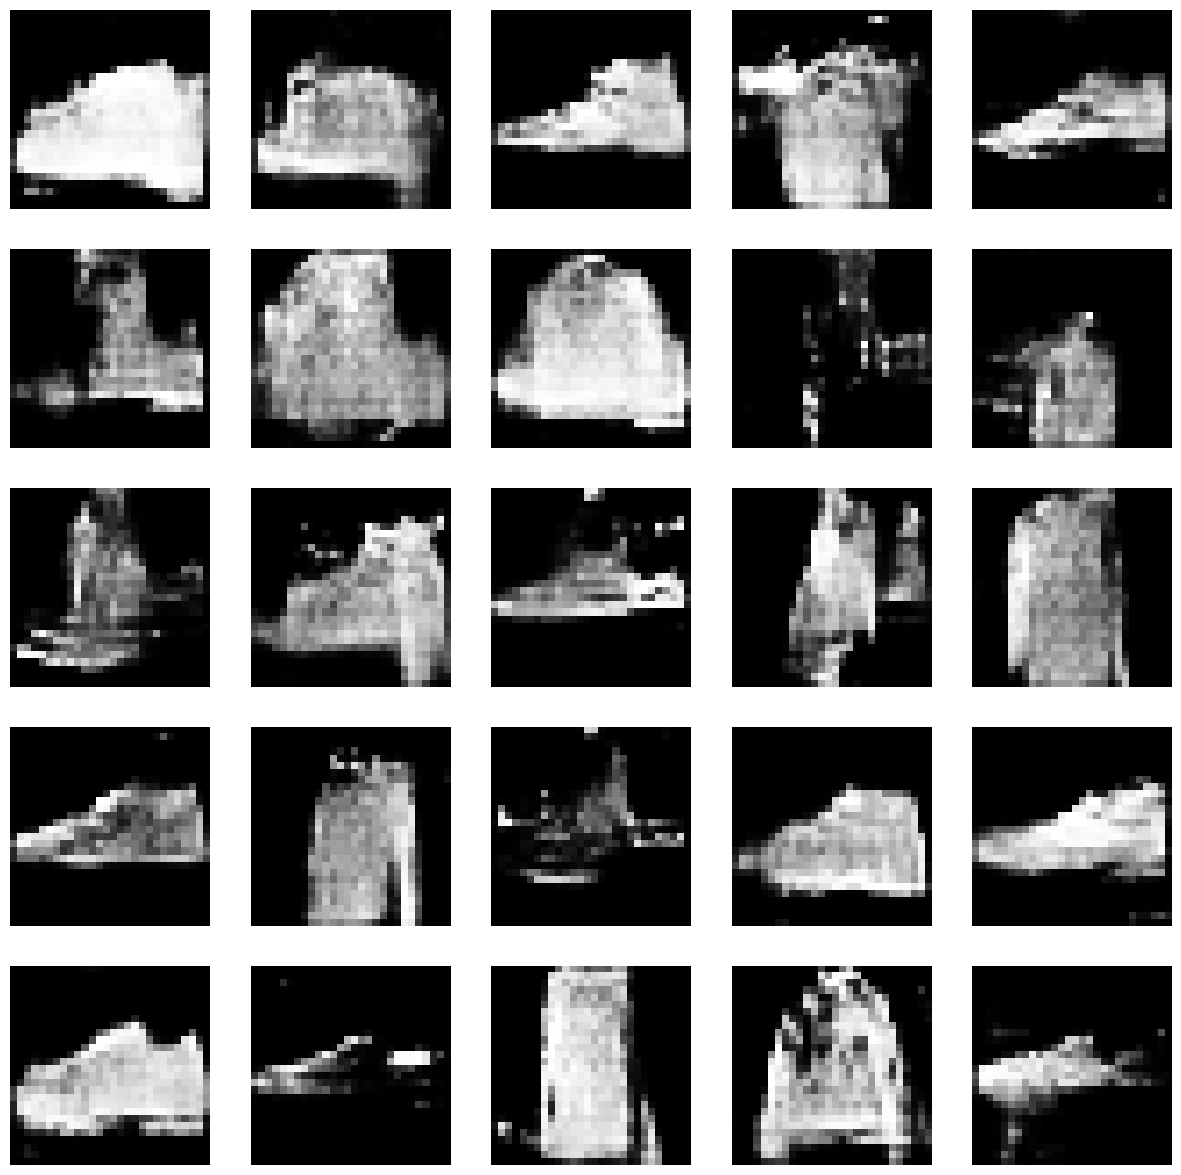

Epoch:  24


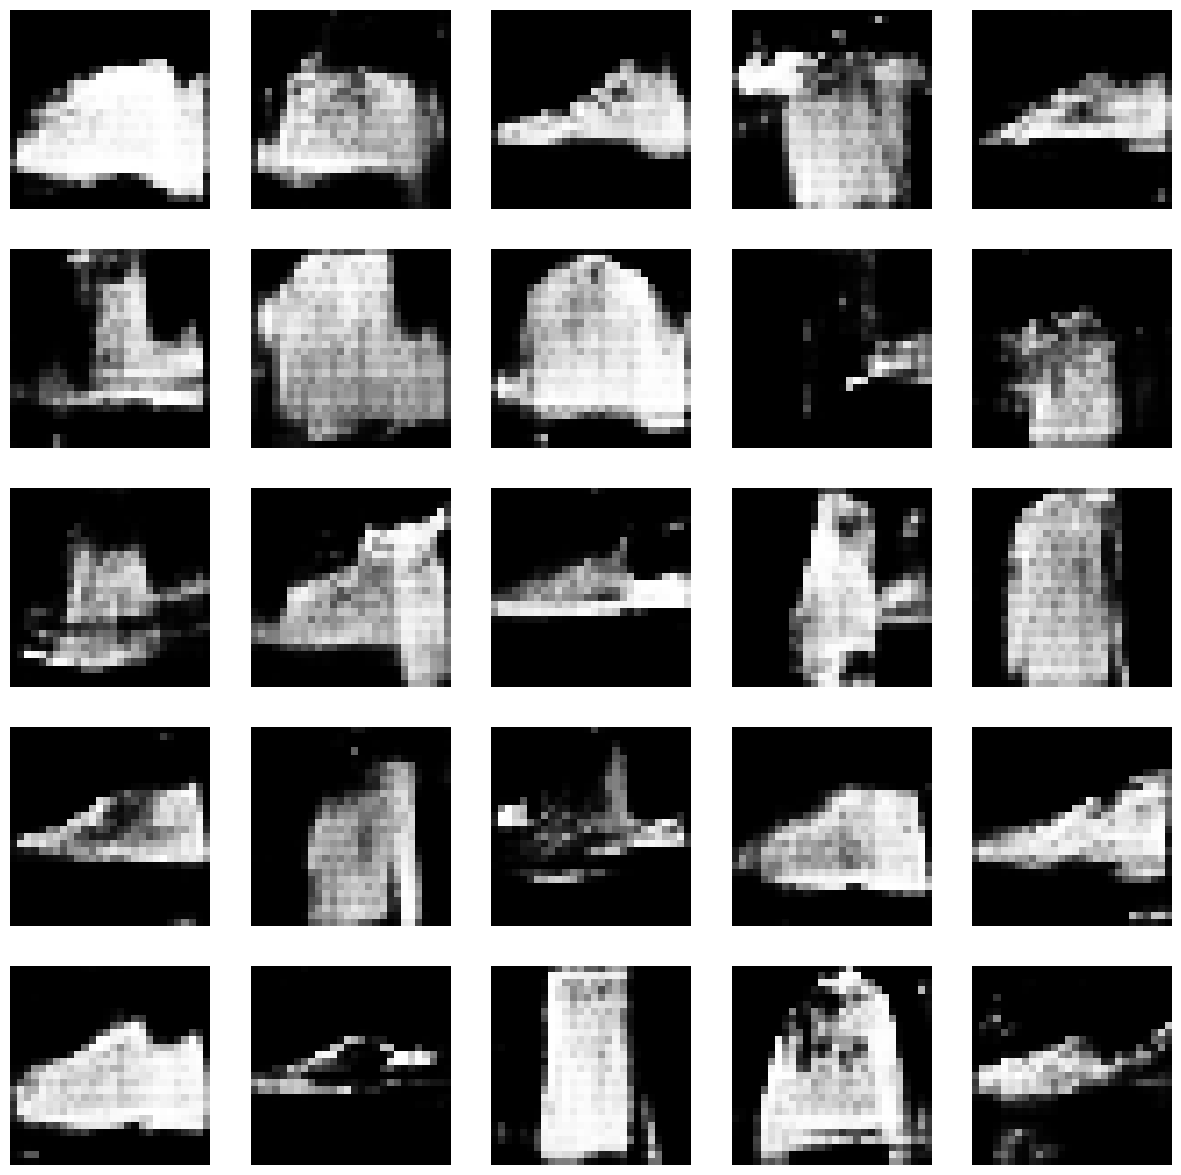

Epoch:  25


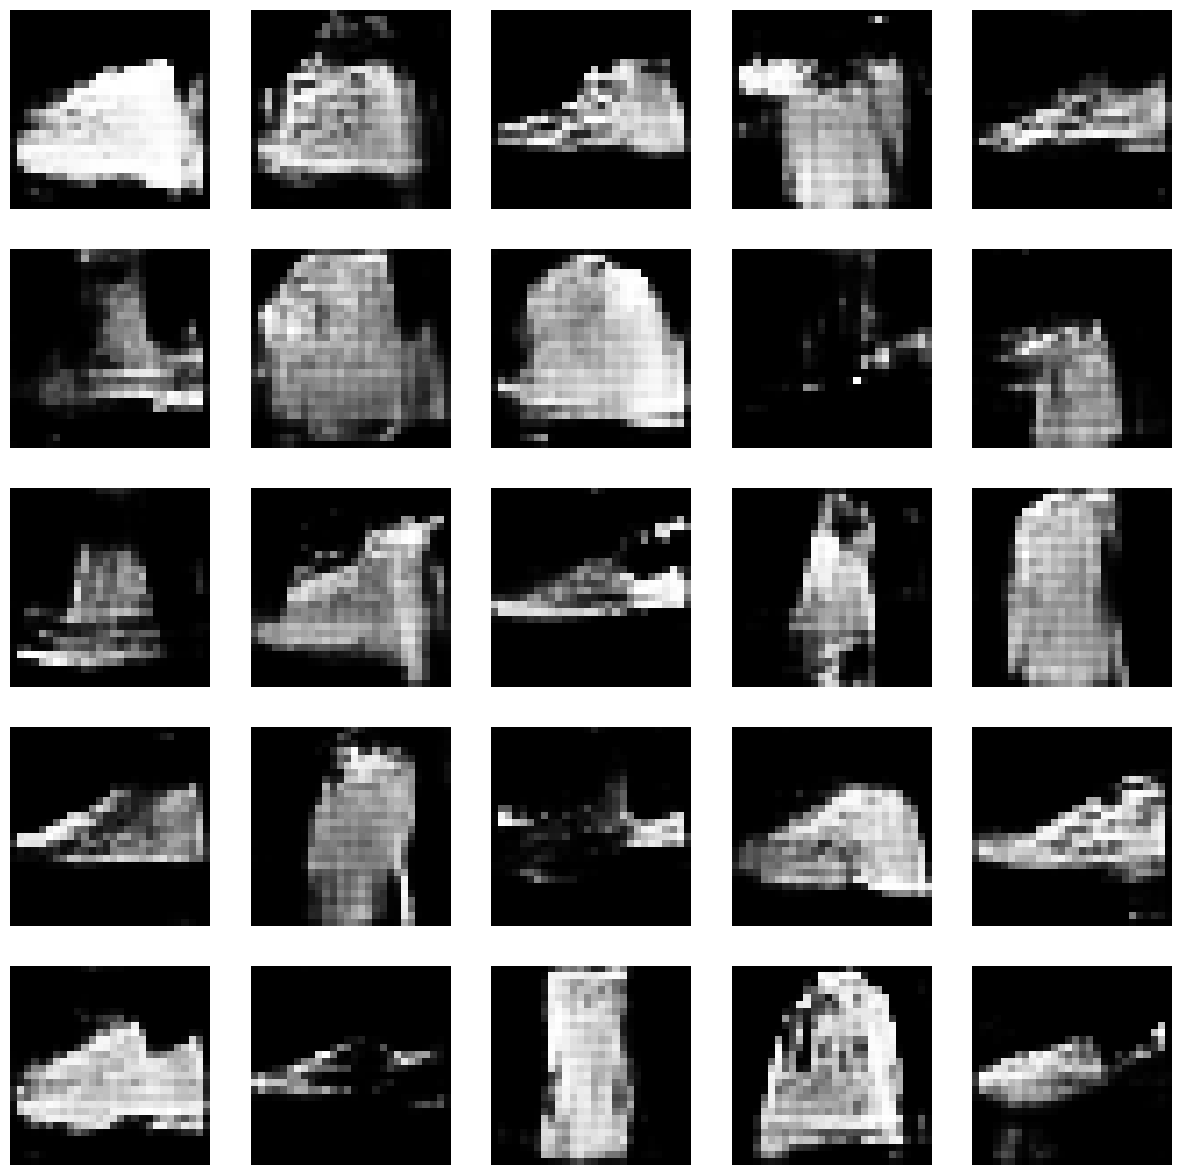

Epoch:  26


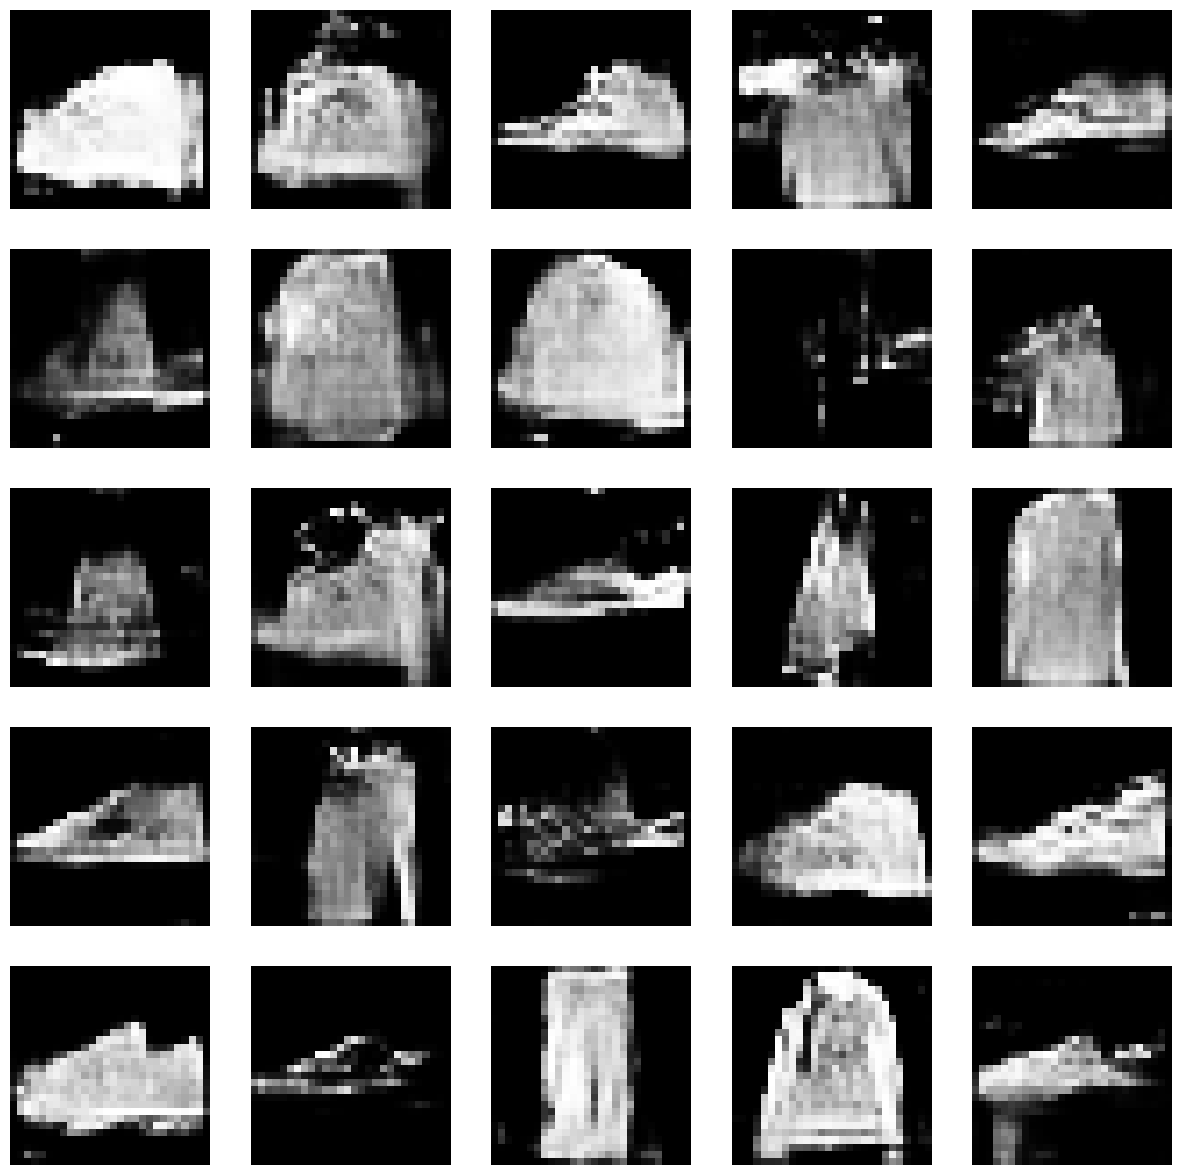

Epoch:  27


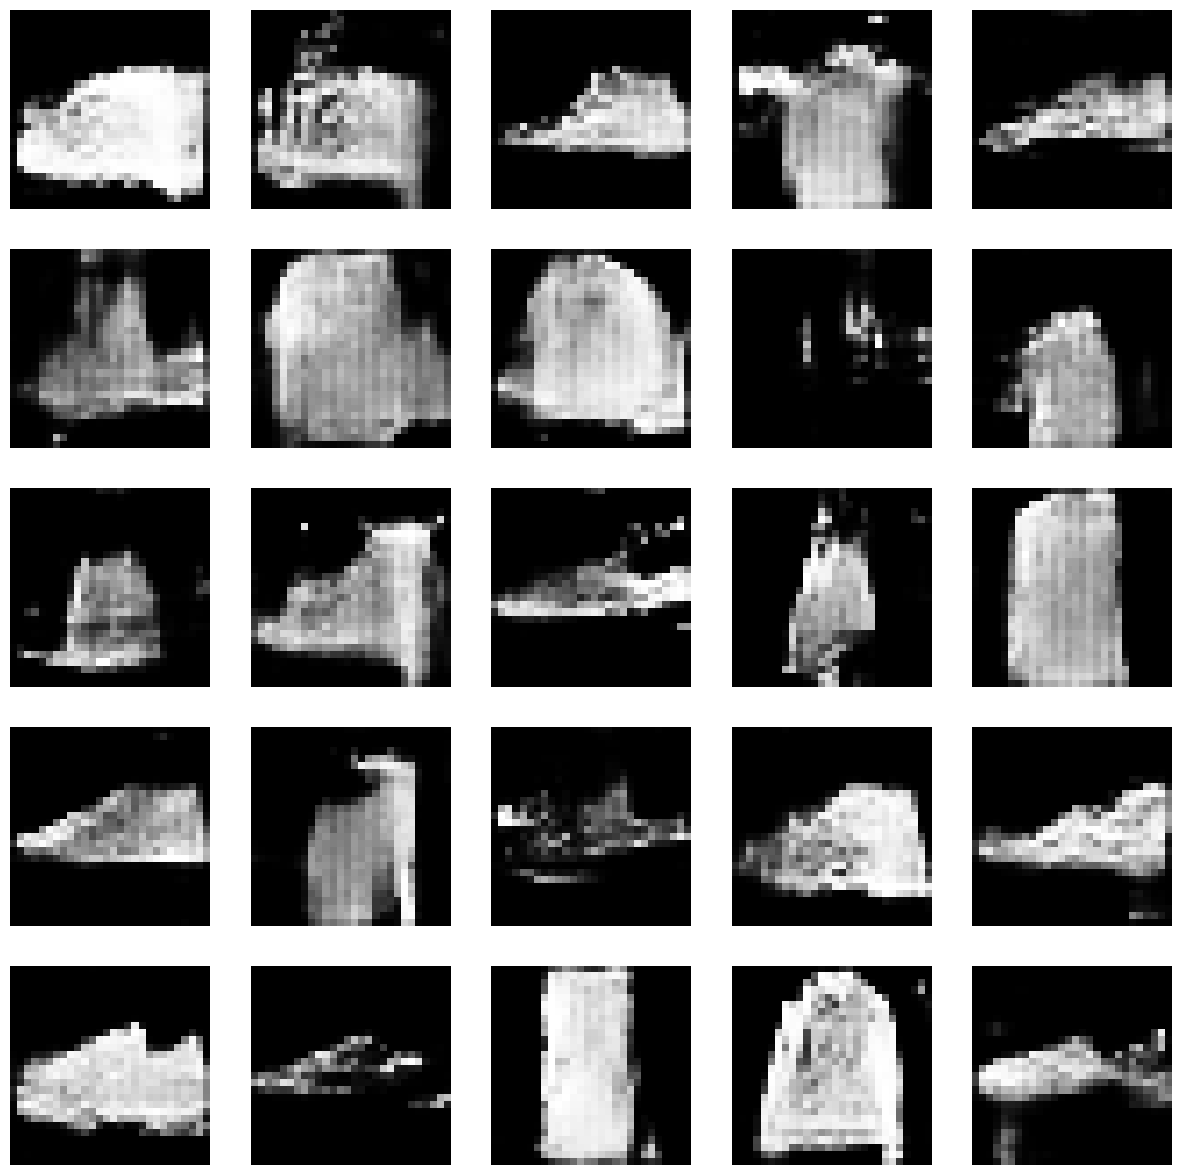

Epoch:  28


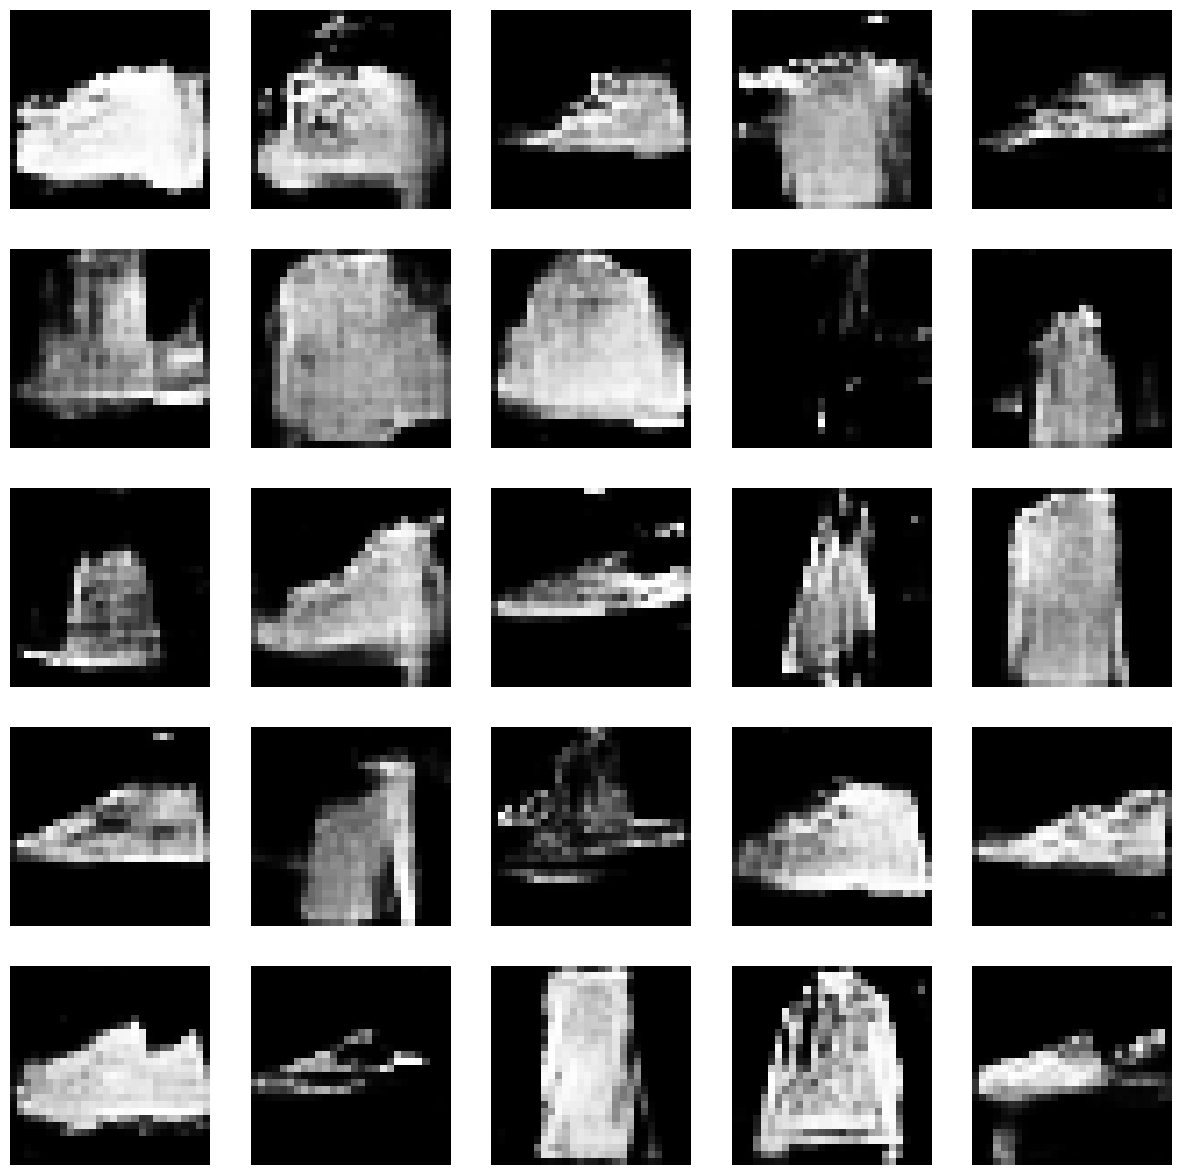

Epoch:  29


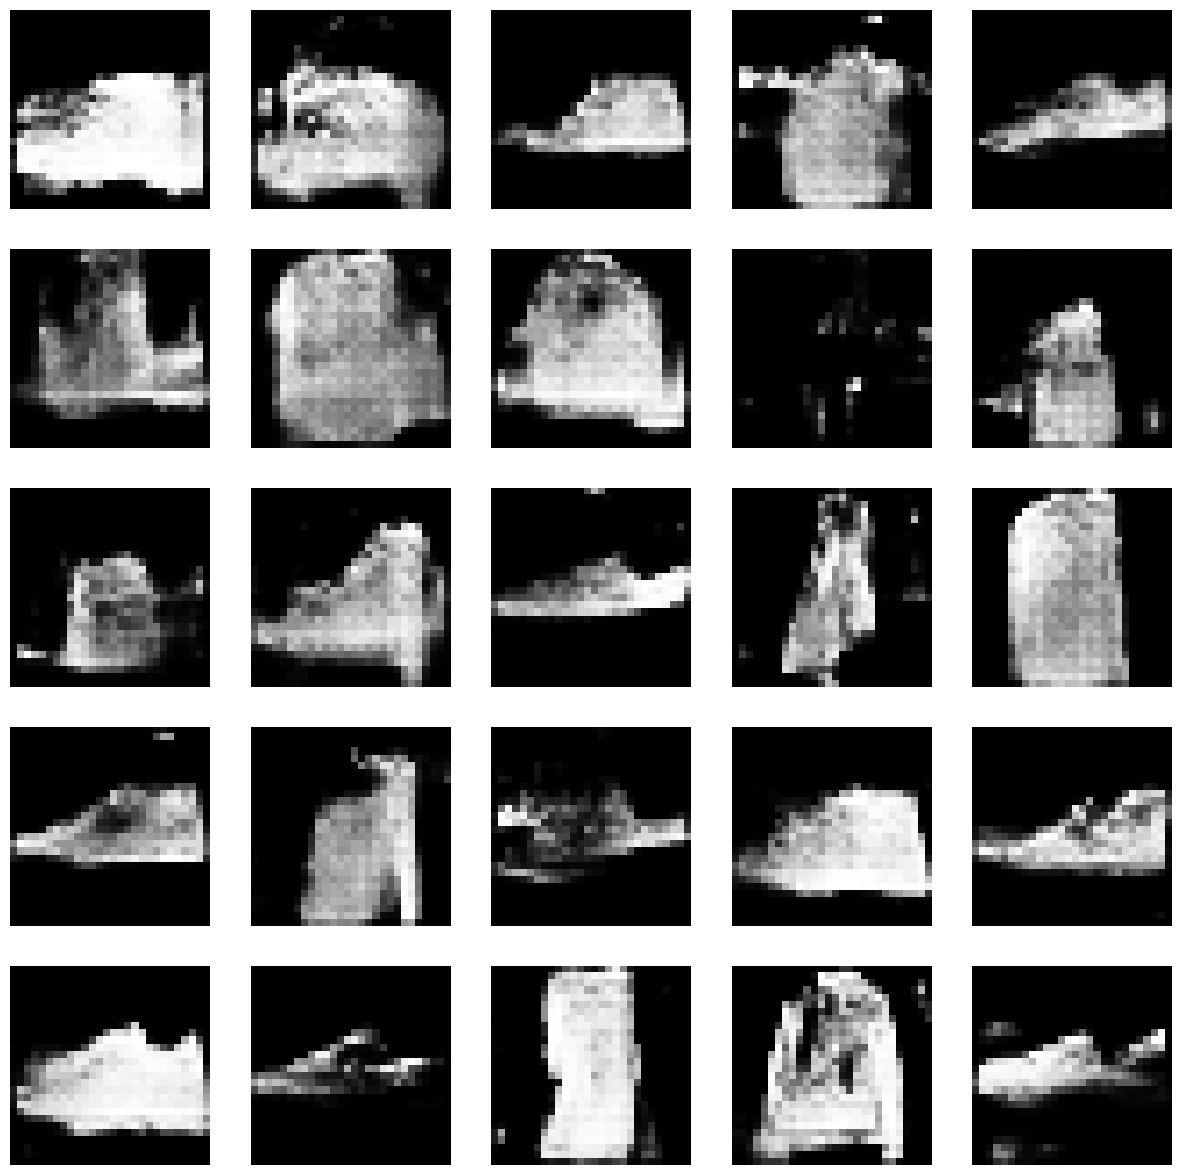

Epoch:  30


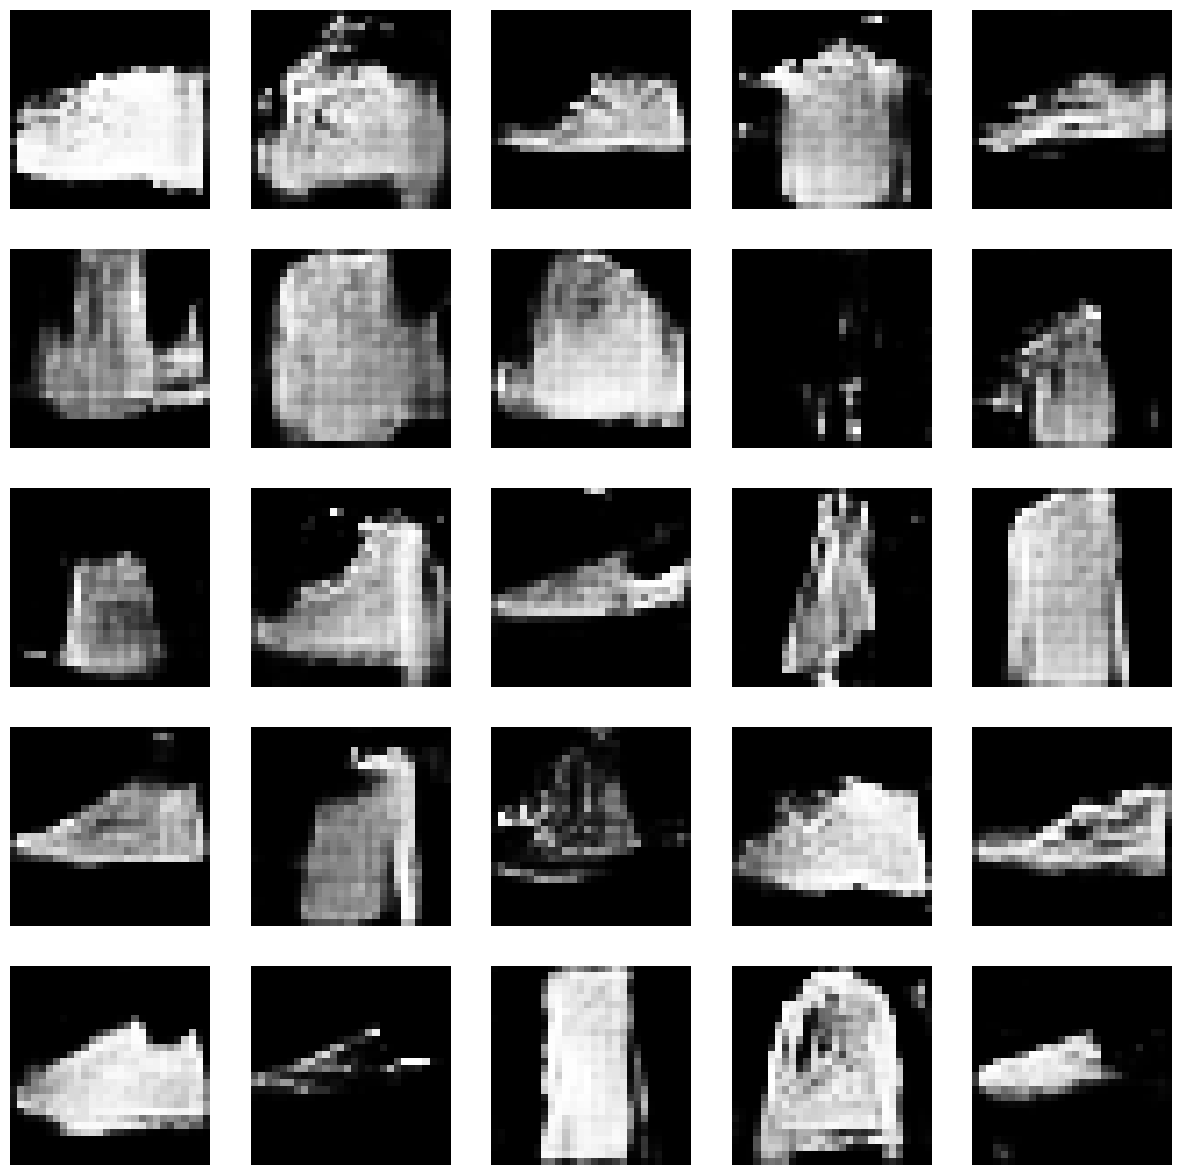

Epoch:  31


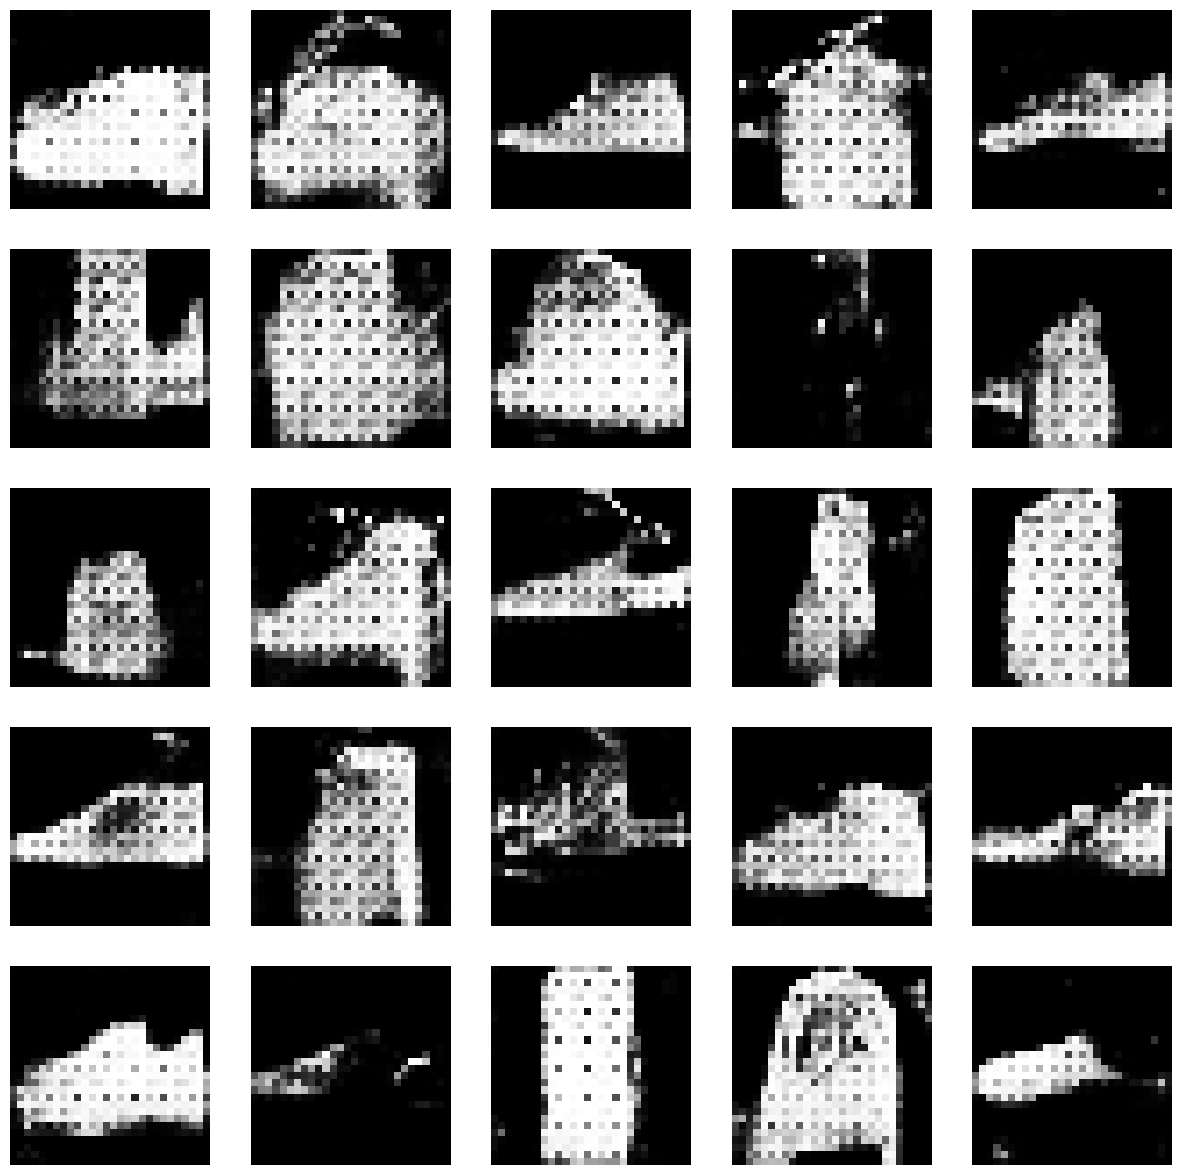

Epoch:  32


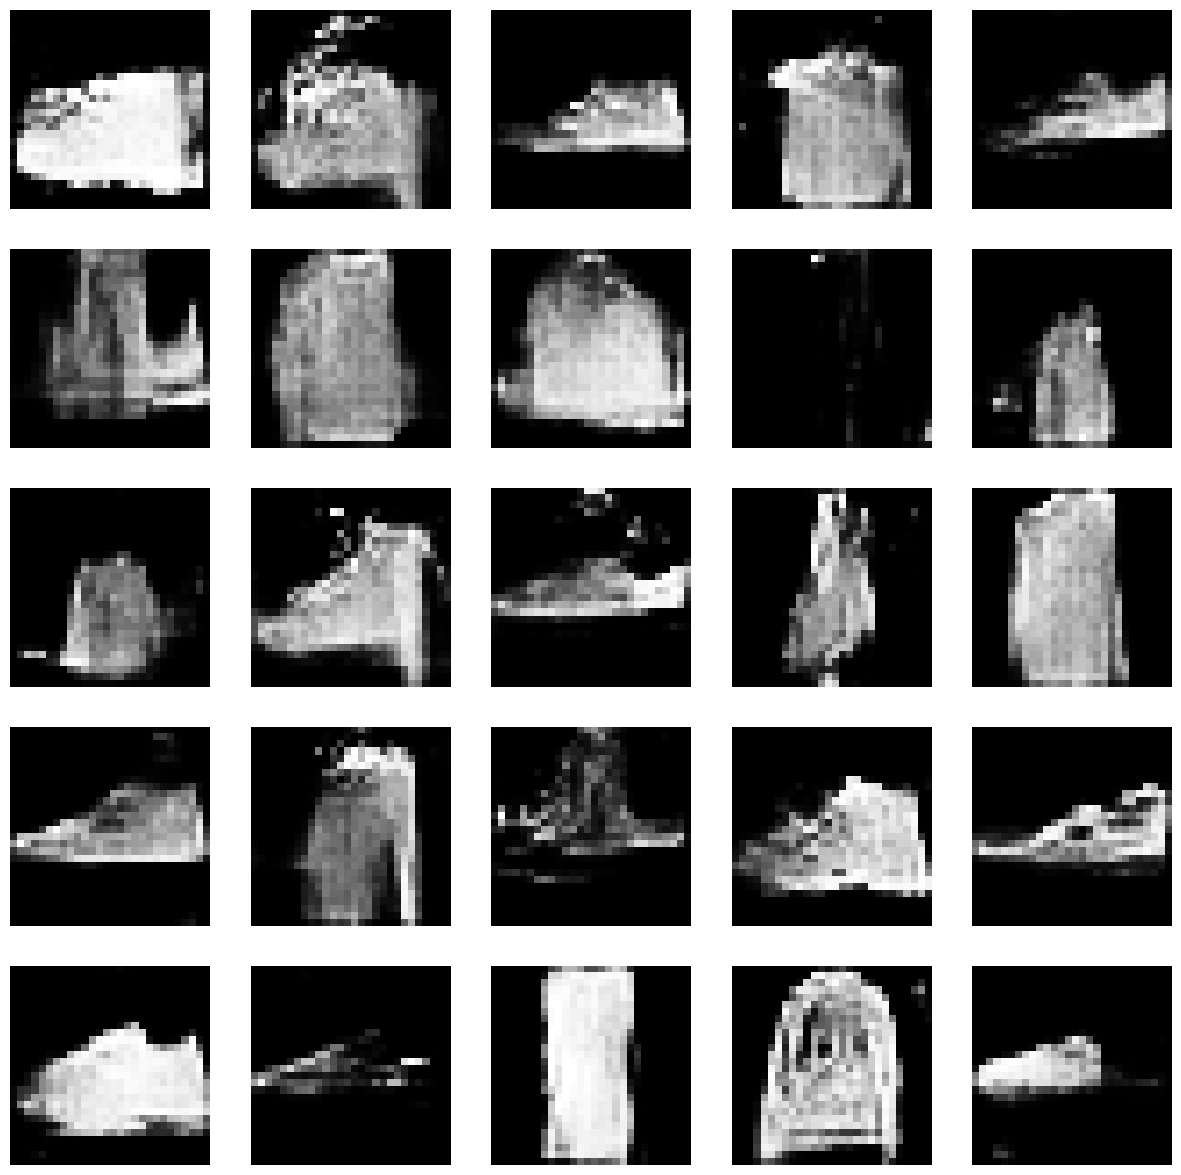

Epoch:  33


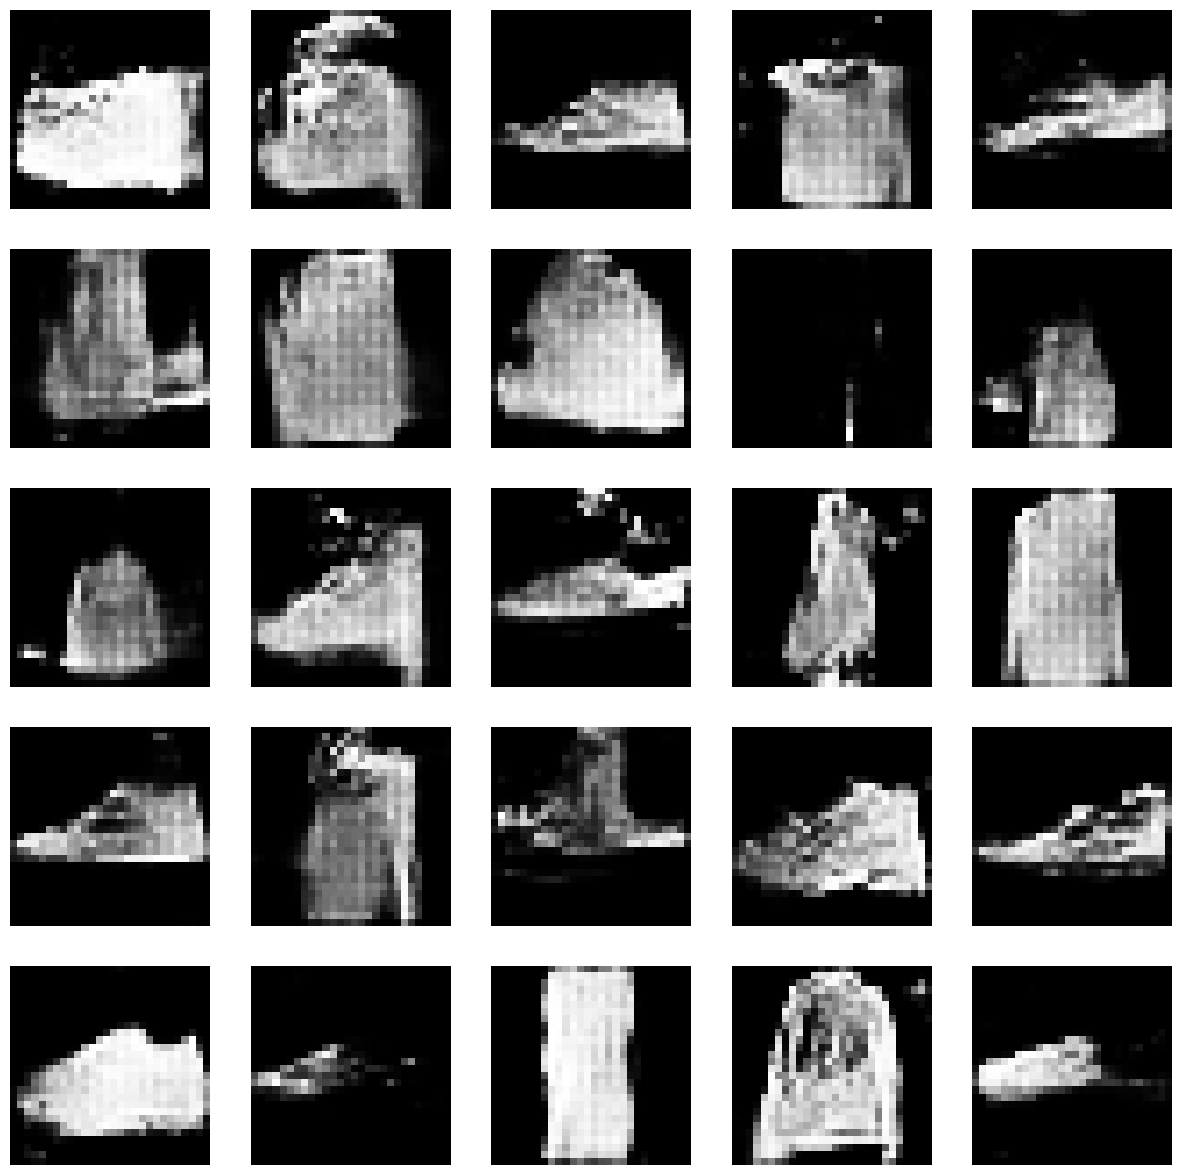

Epoch:  34


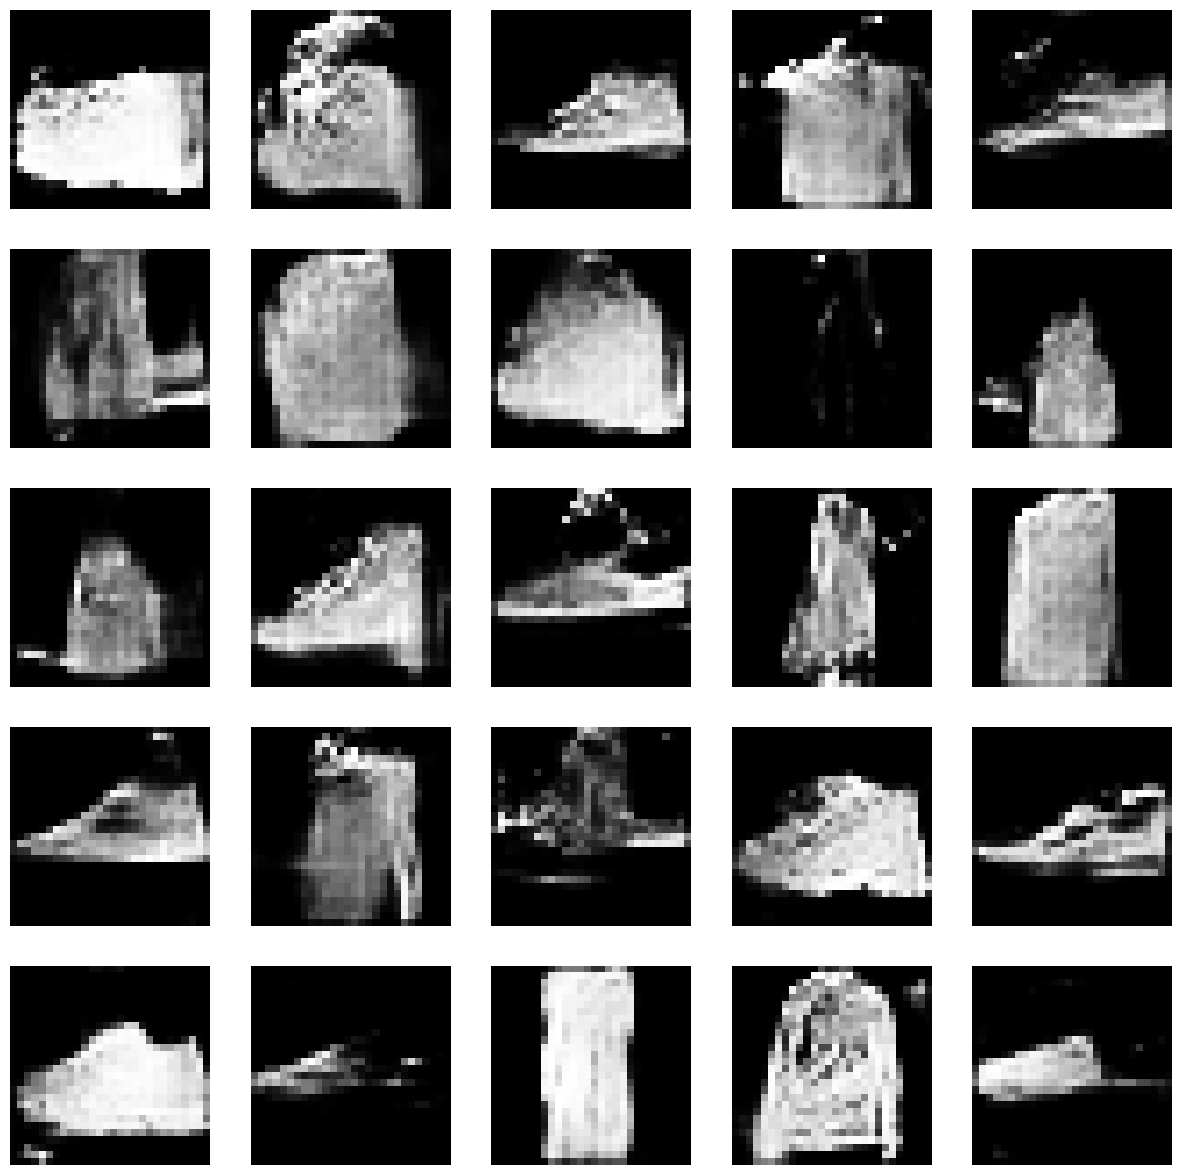

Epoch:  35


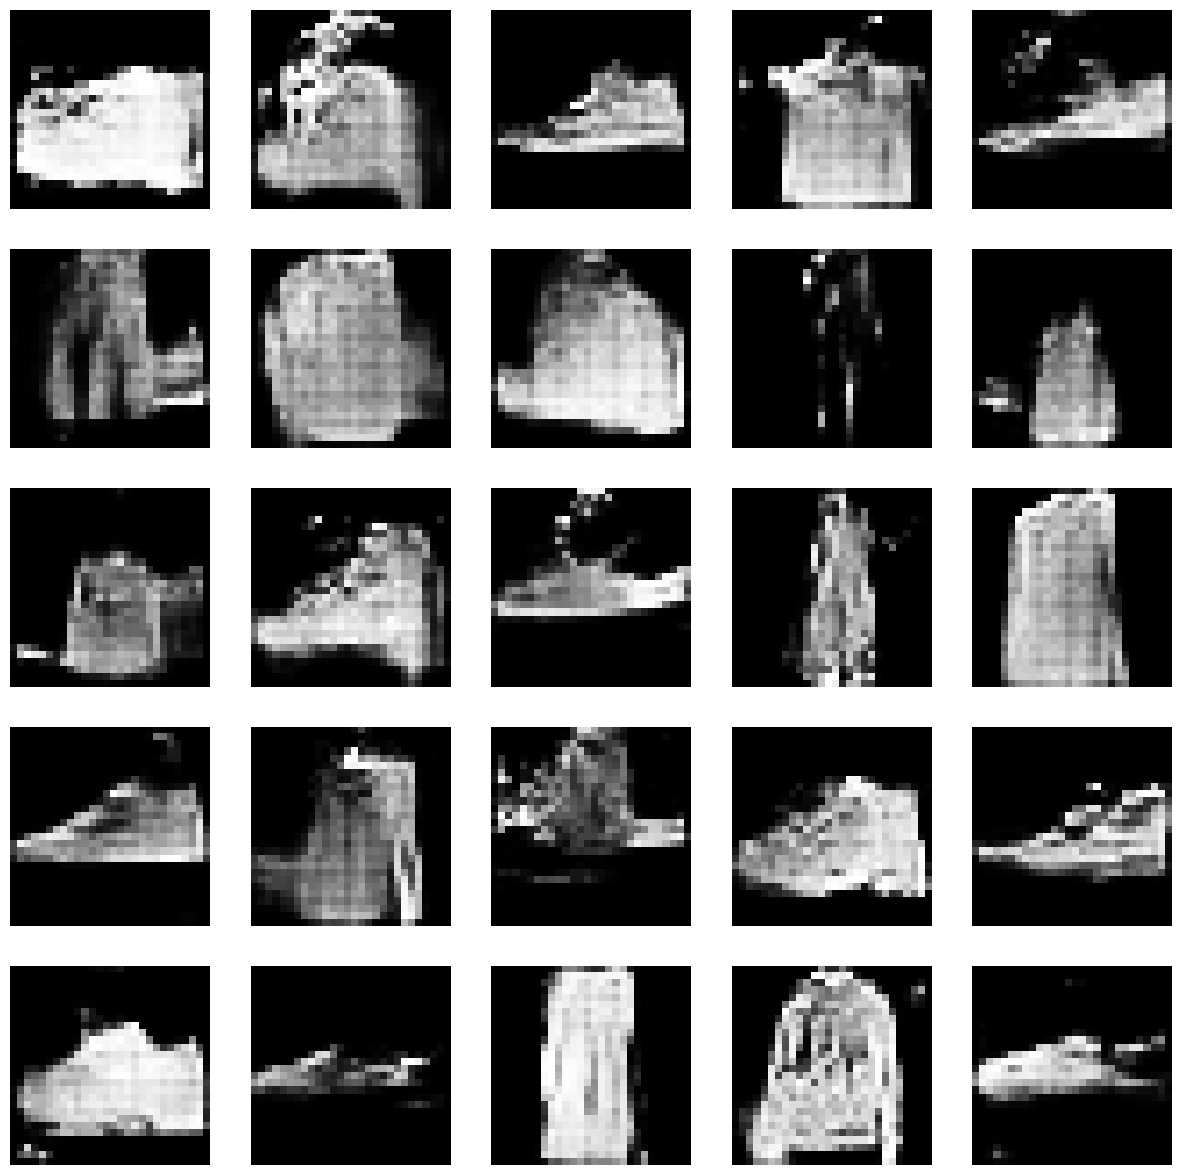

Epoch:  36


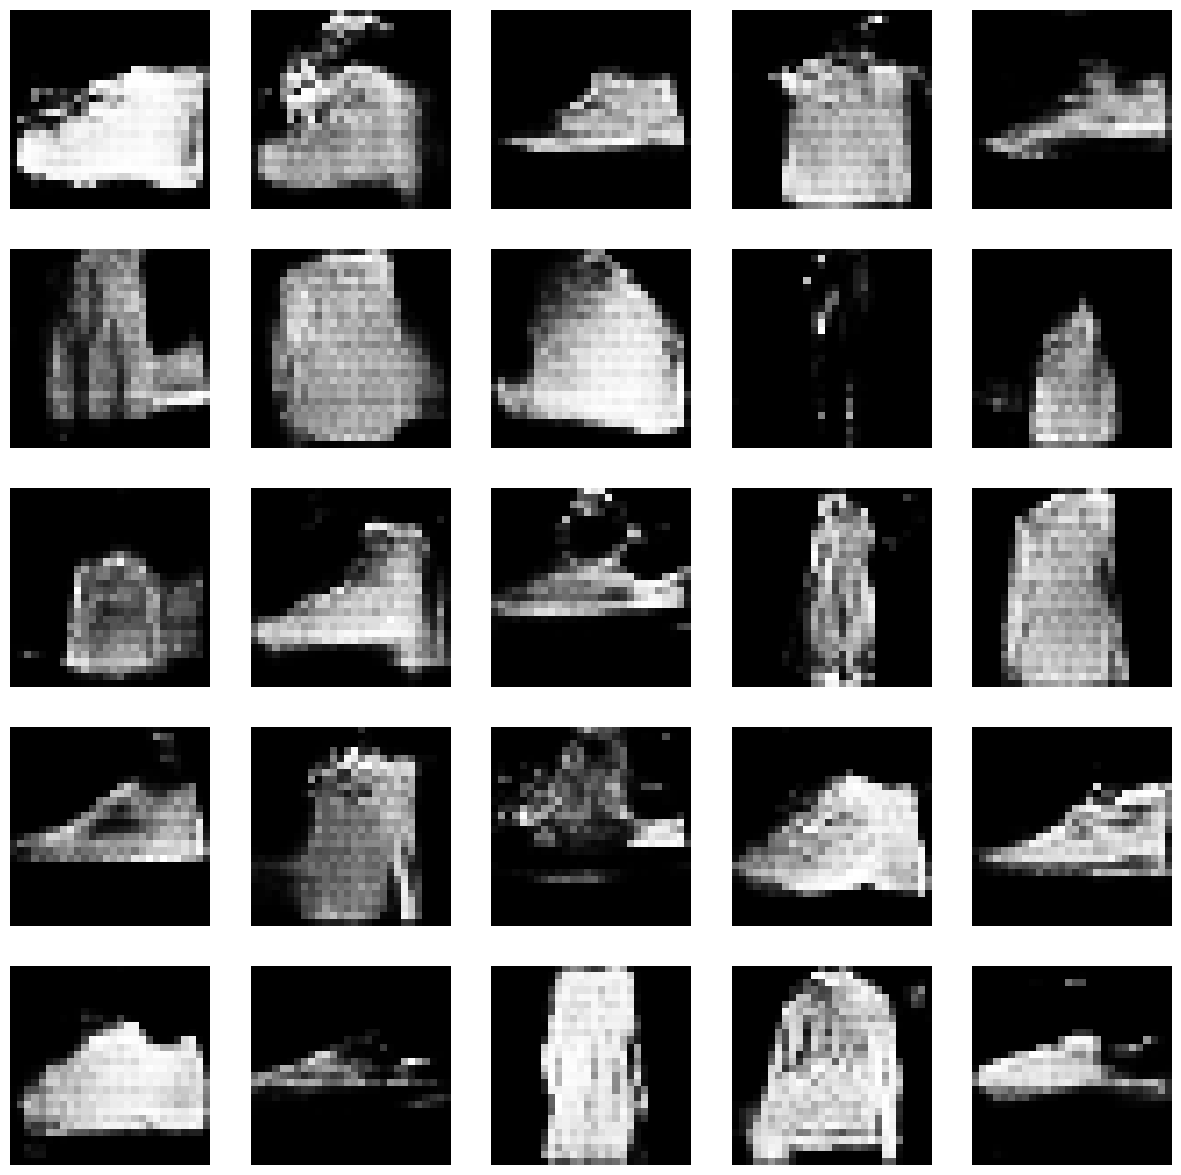

Epoch:  37


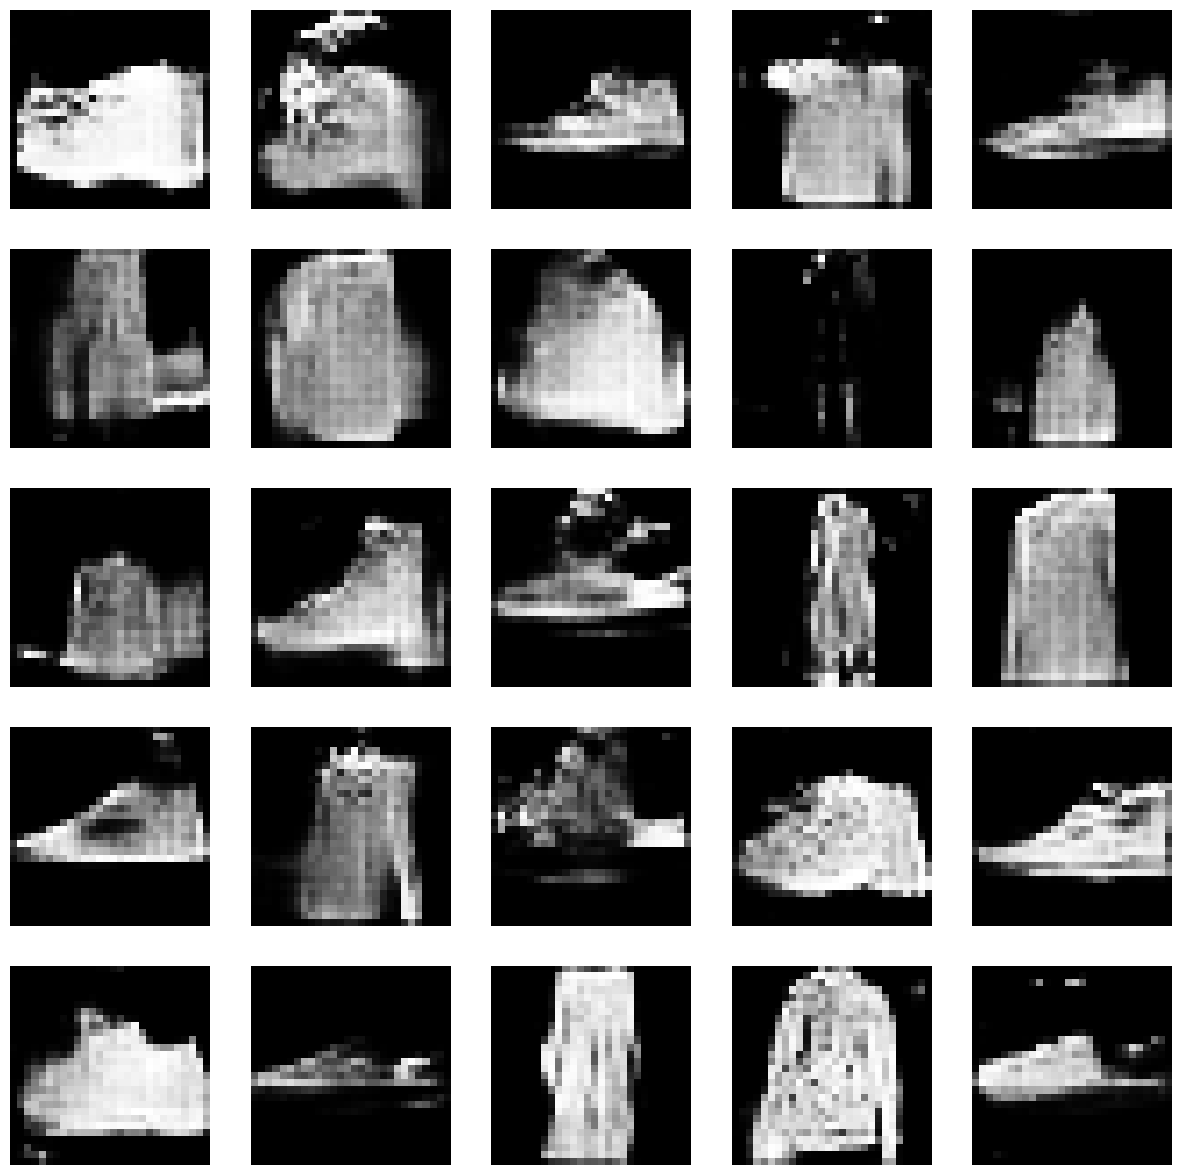

Epoch:  38


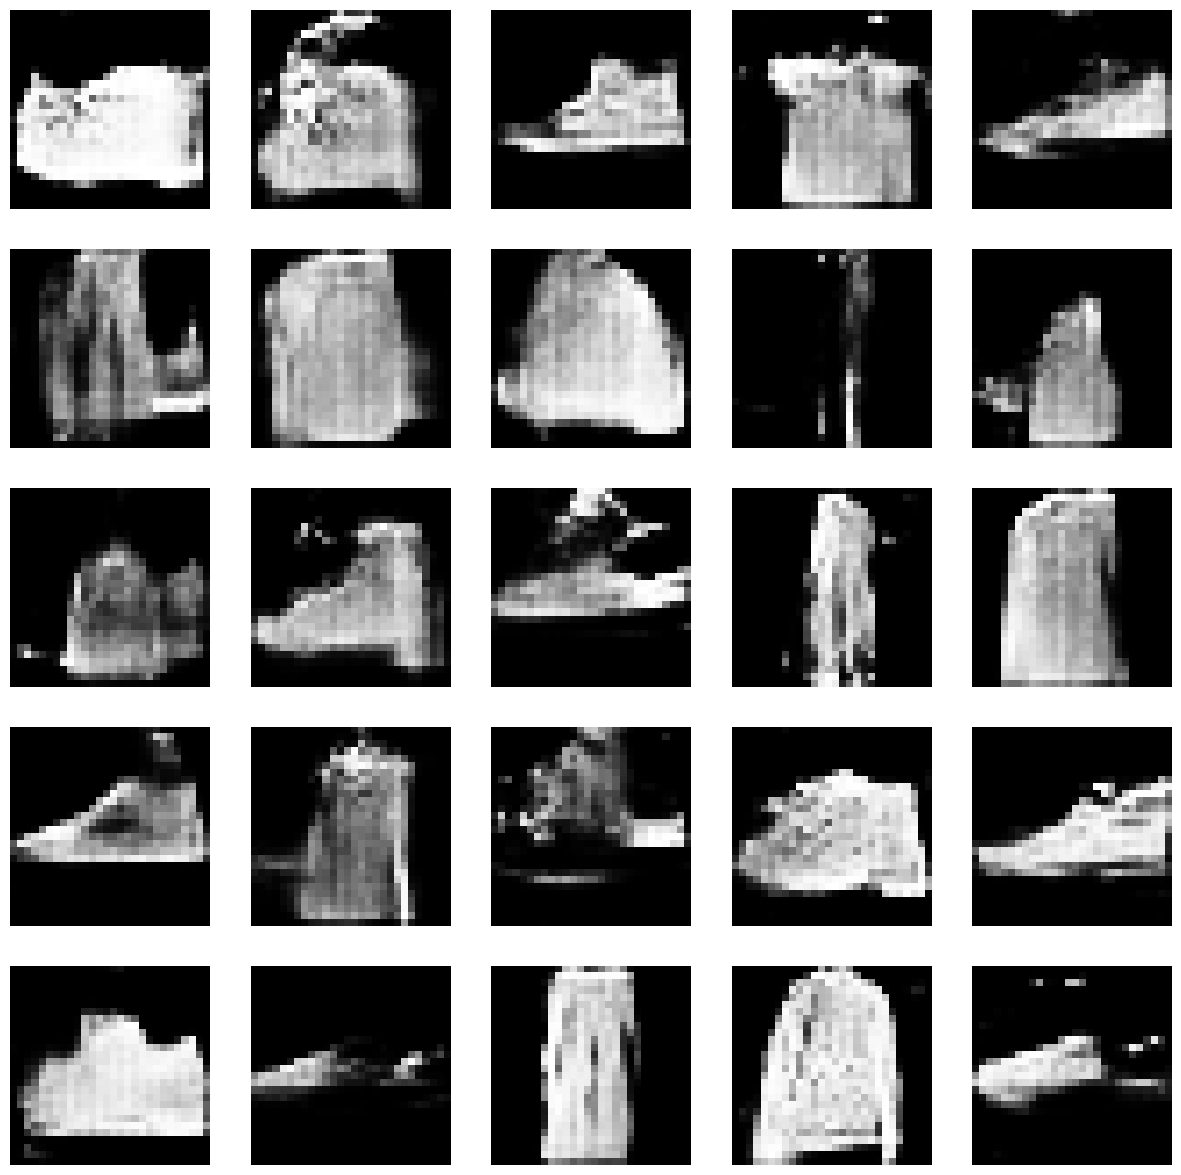

Epoch:  39


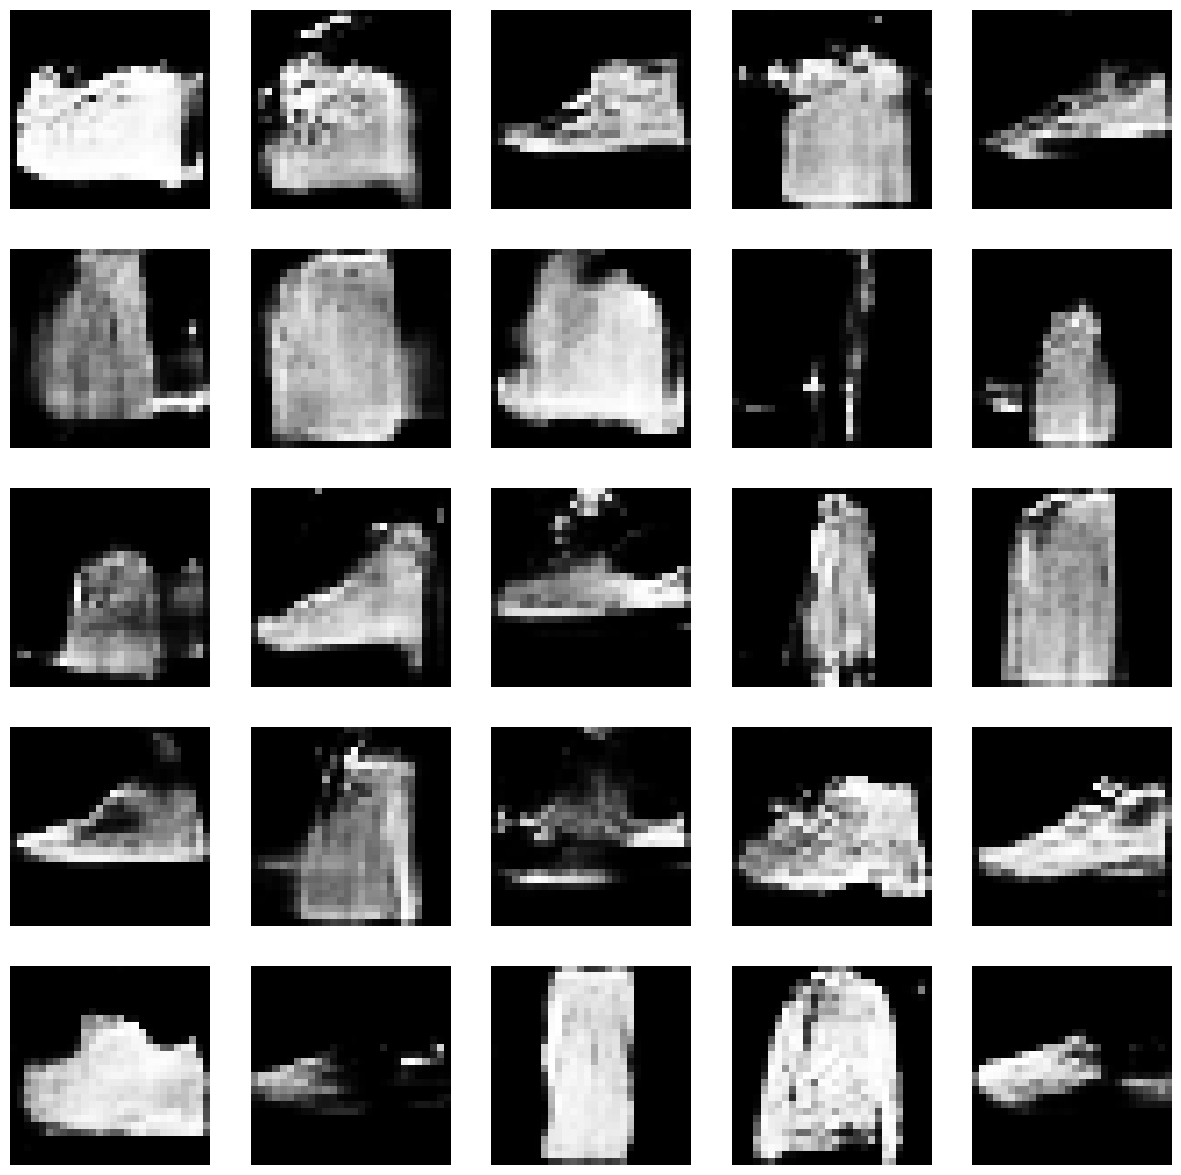

Epoch:  40


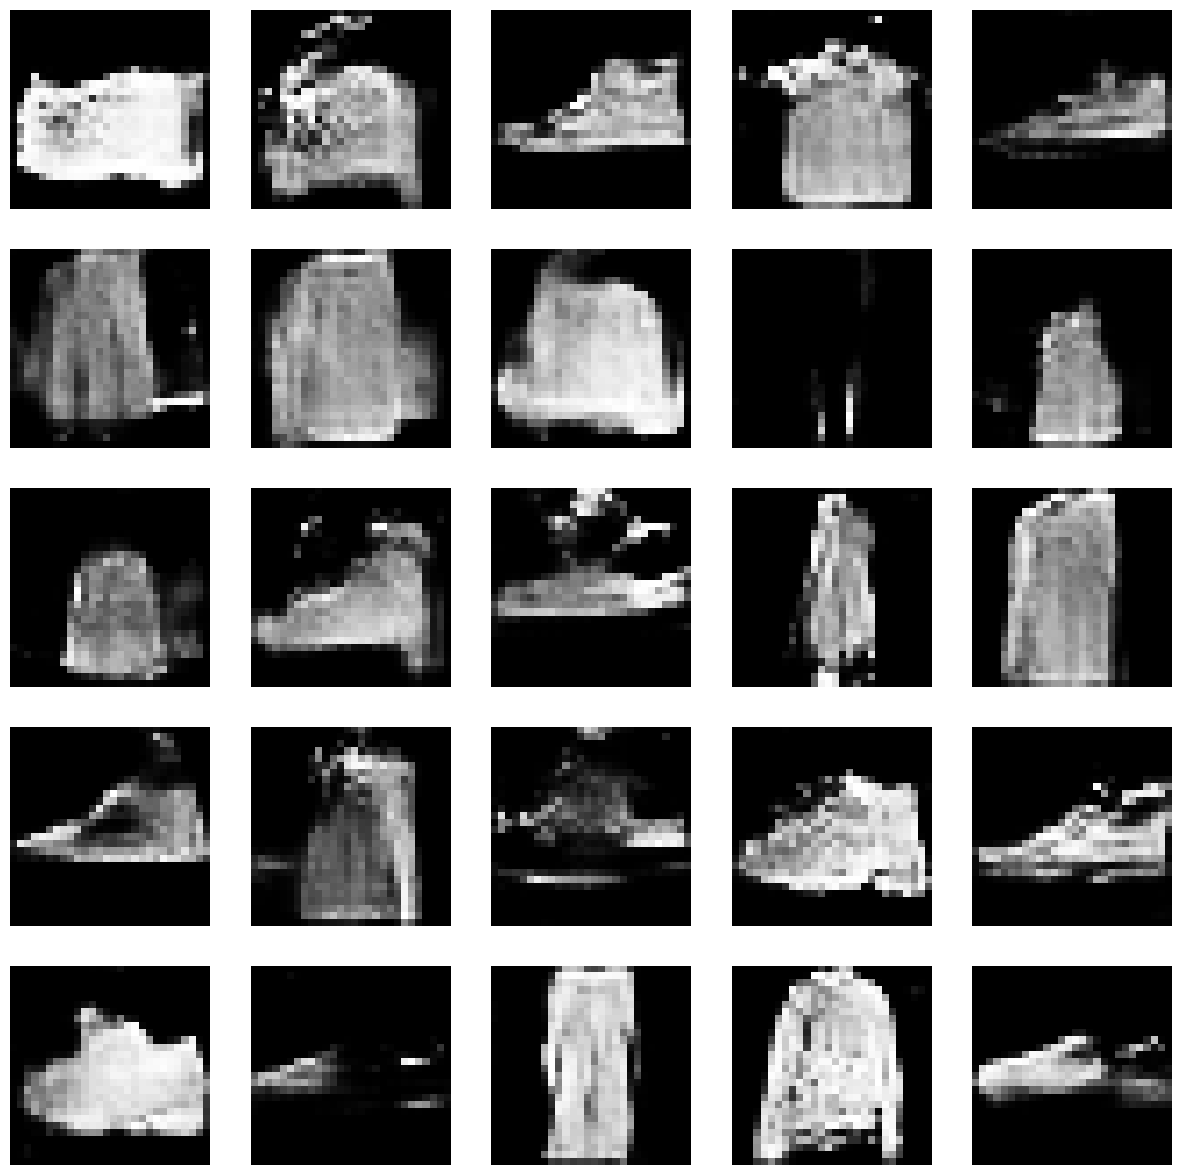

Epoch:  41


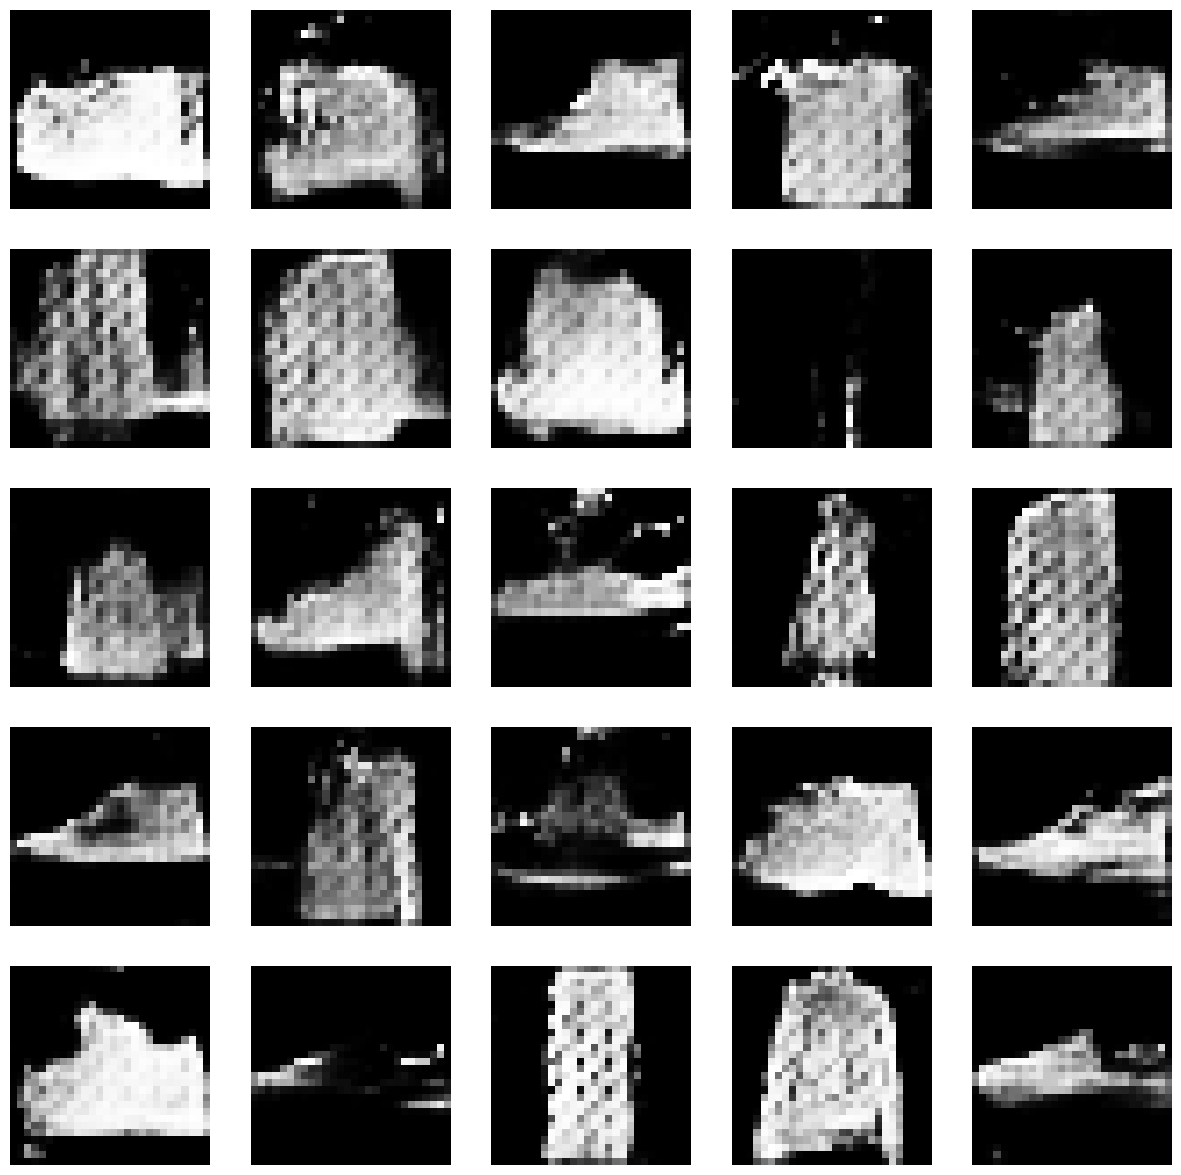

Epoch:  42


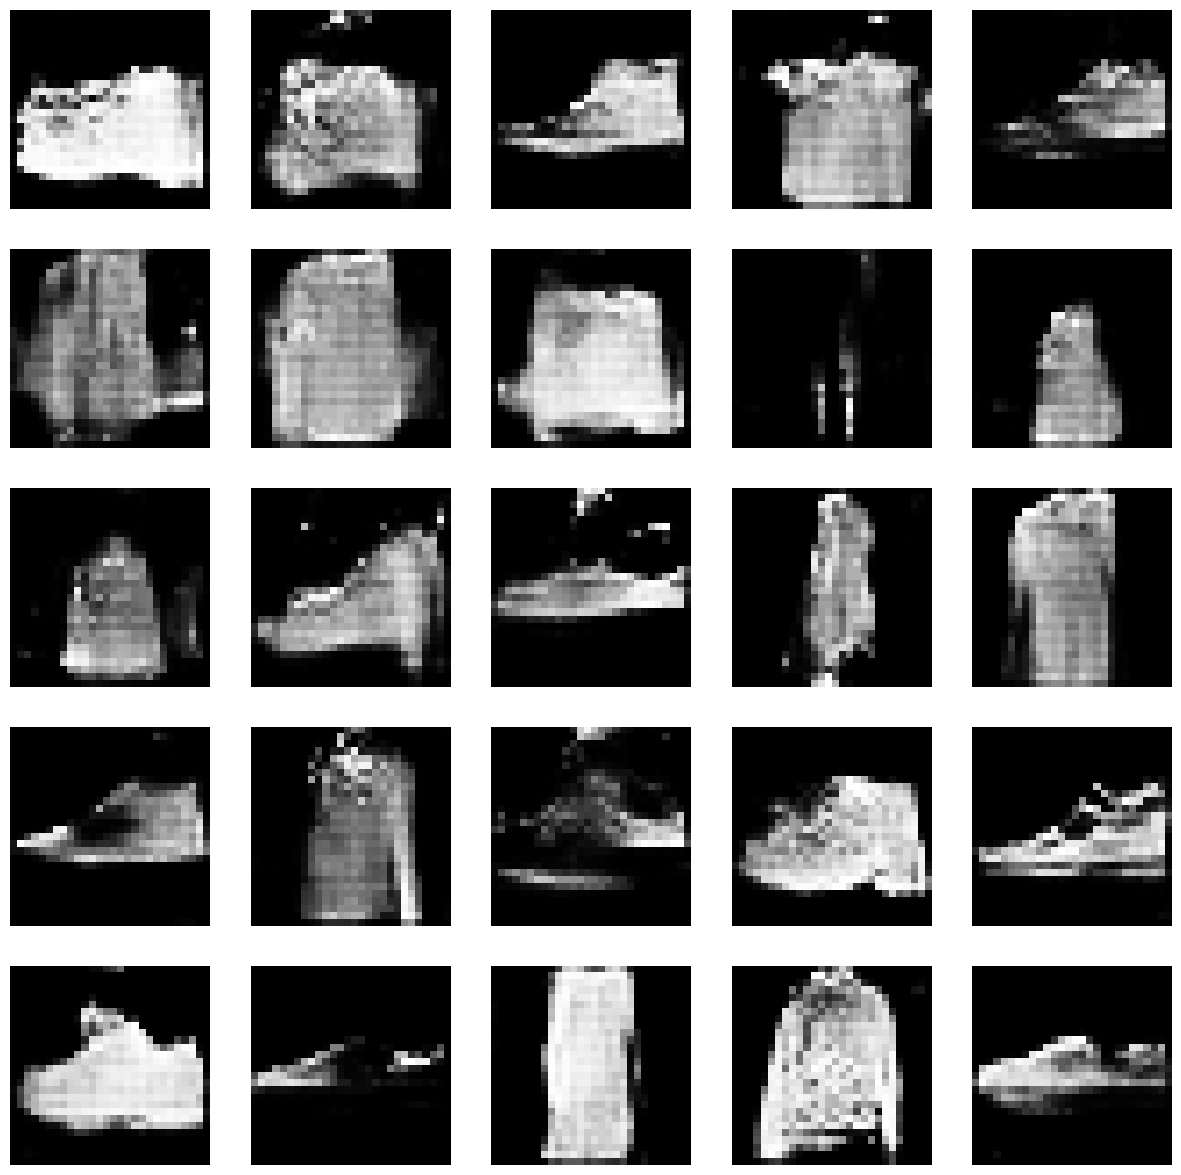

Epoch:  43


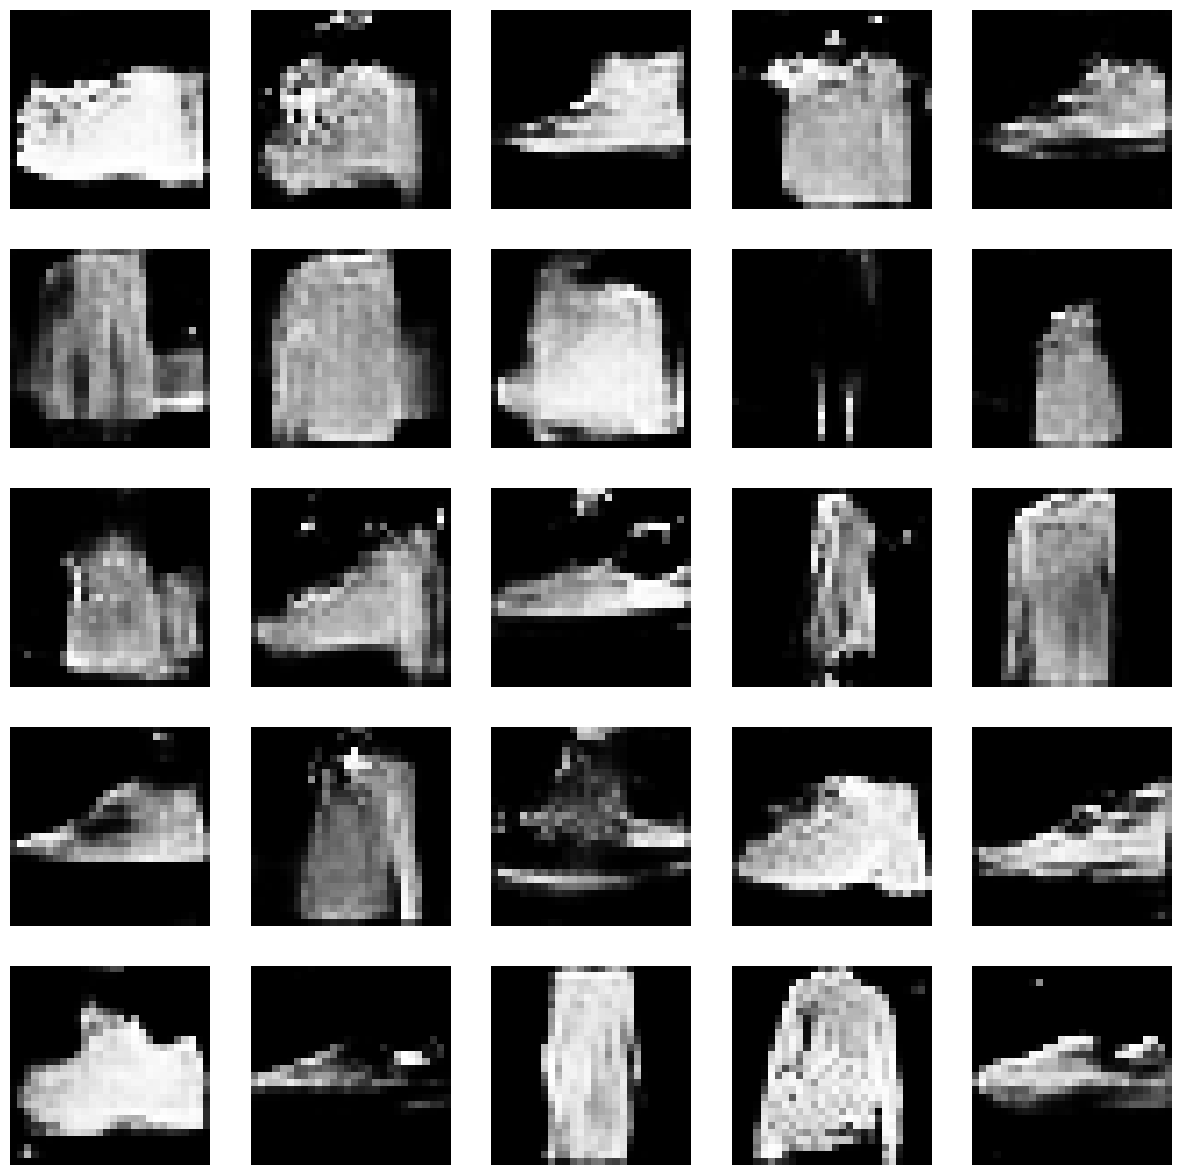

Epoch:  44


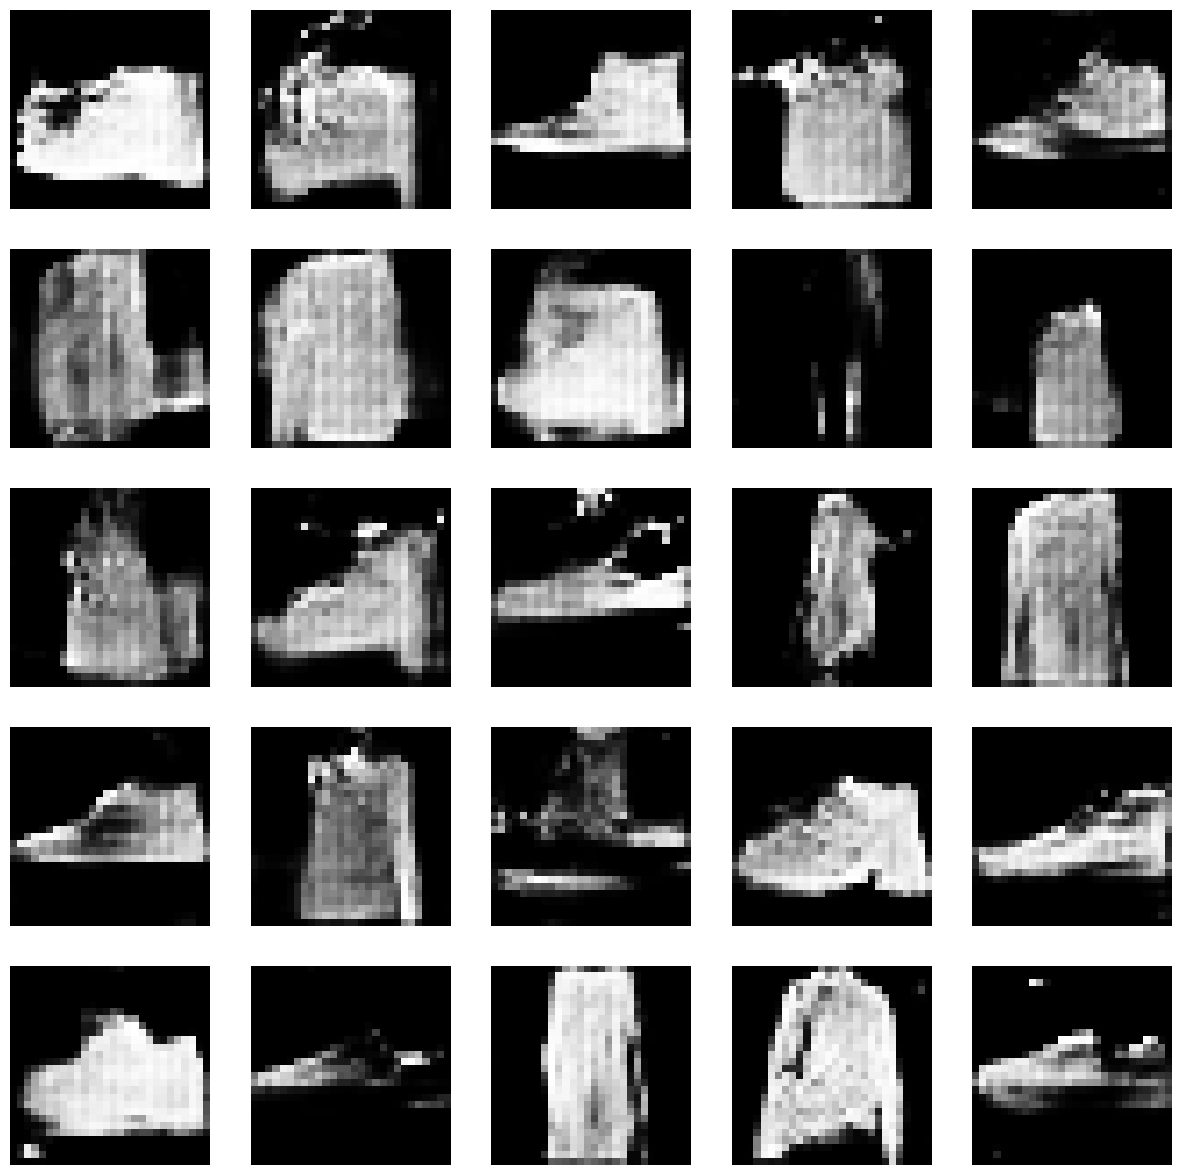

Epoch:  45


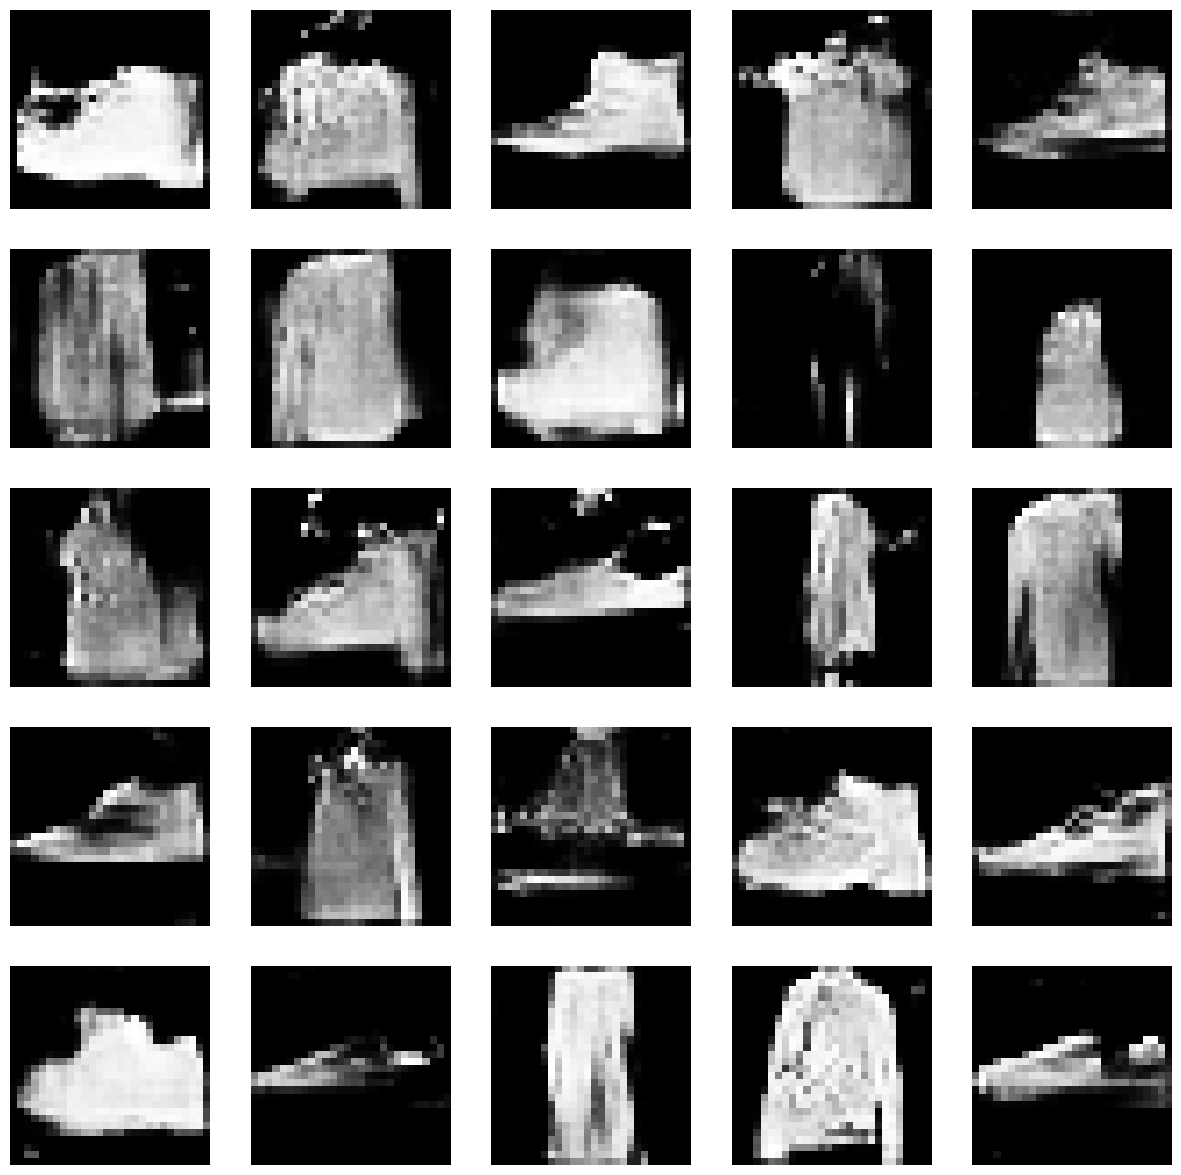

Epoch:  46


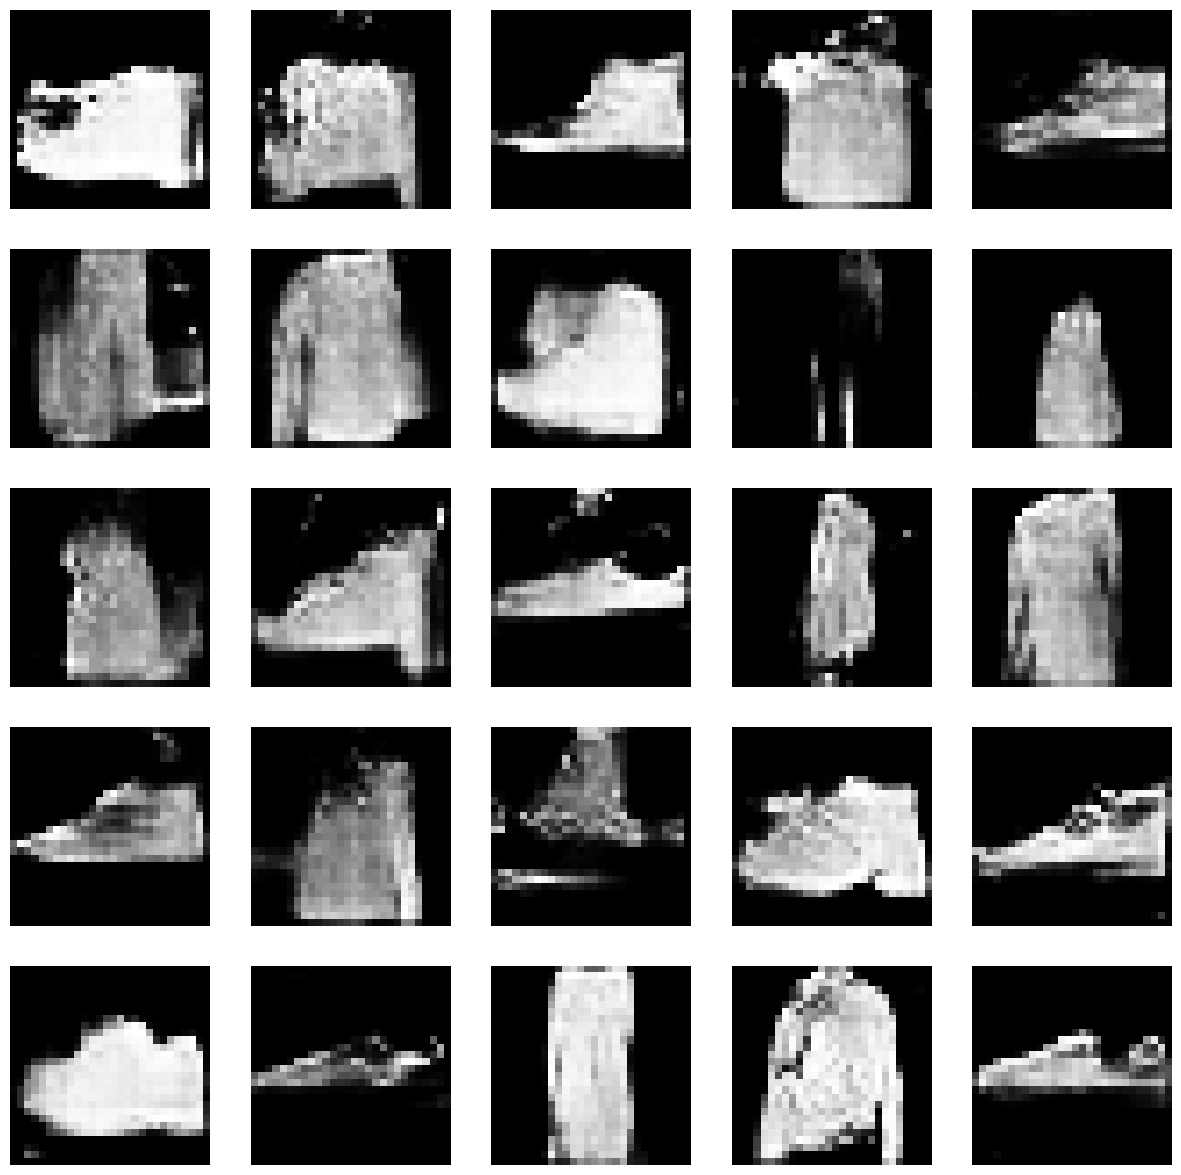

Epoch:  47


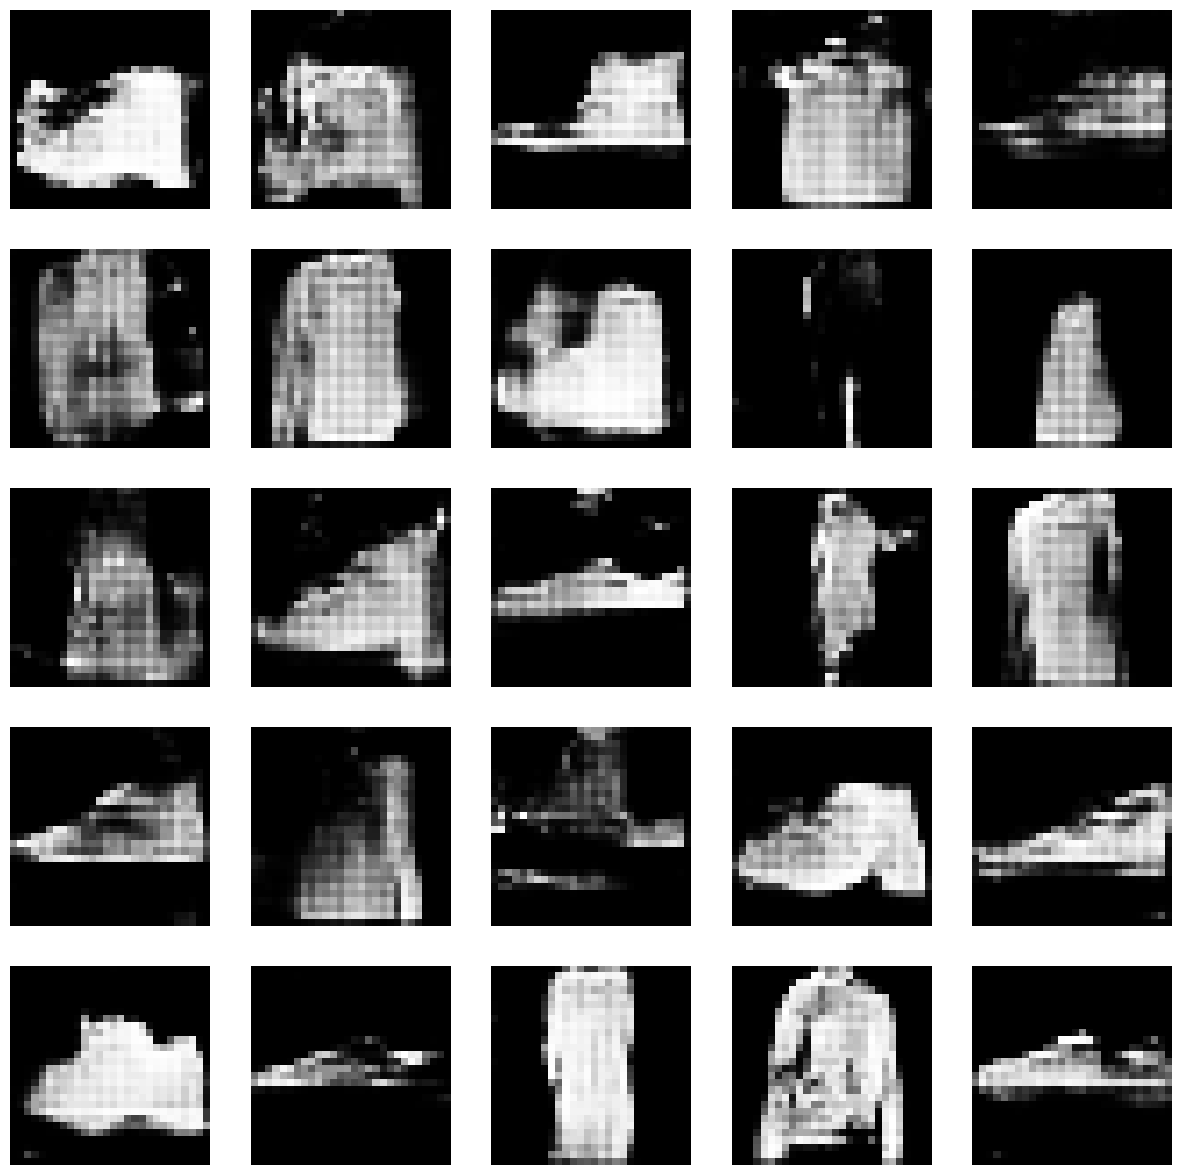

Epoch:  48


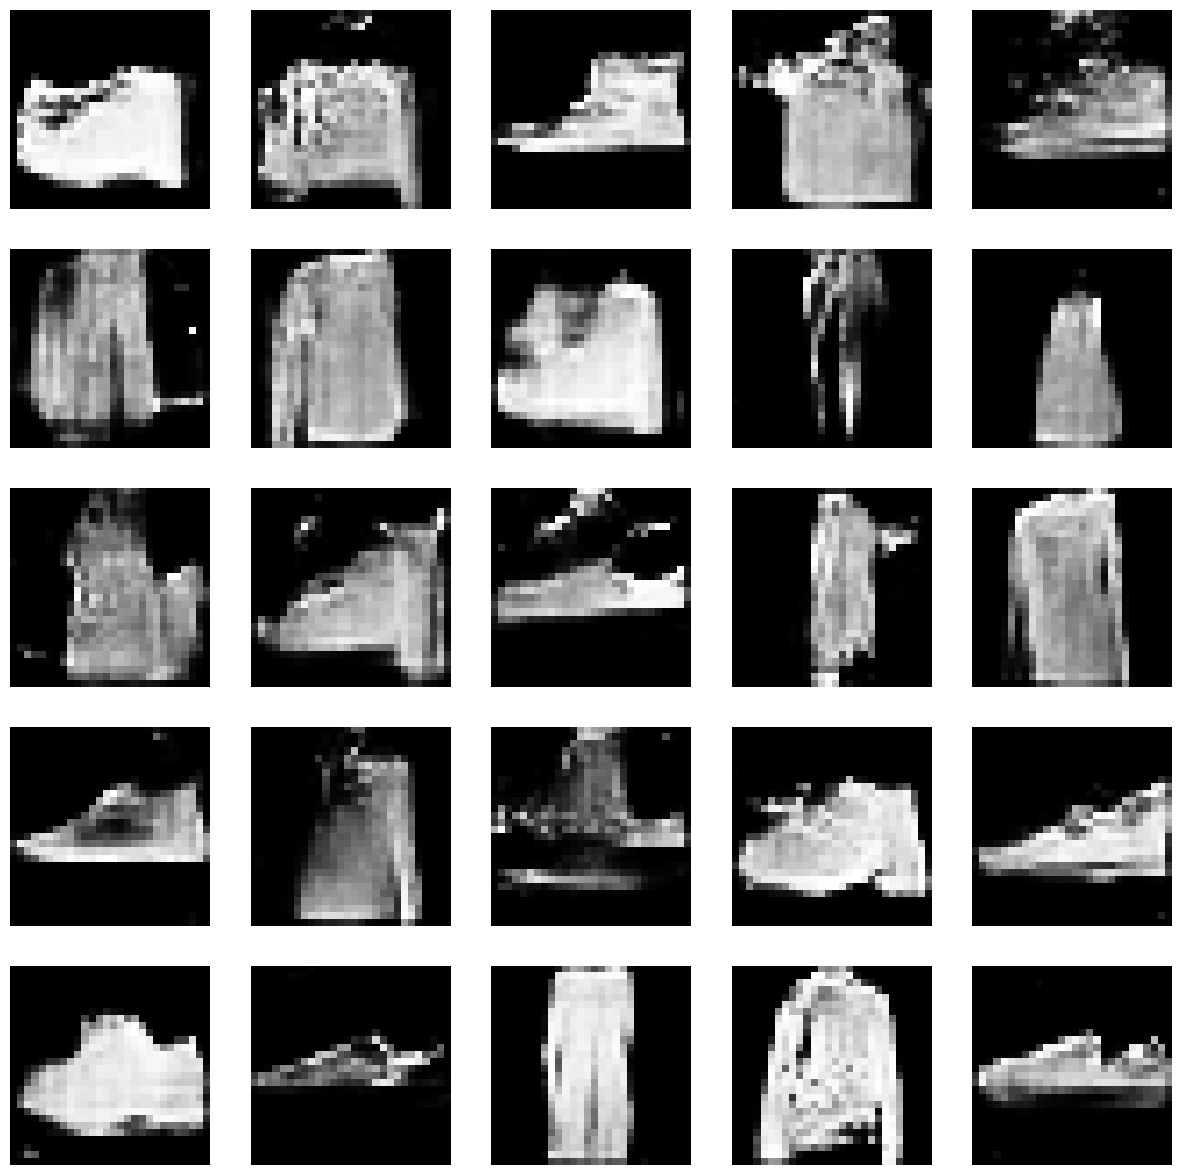

Epoch:  49


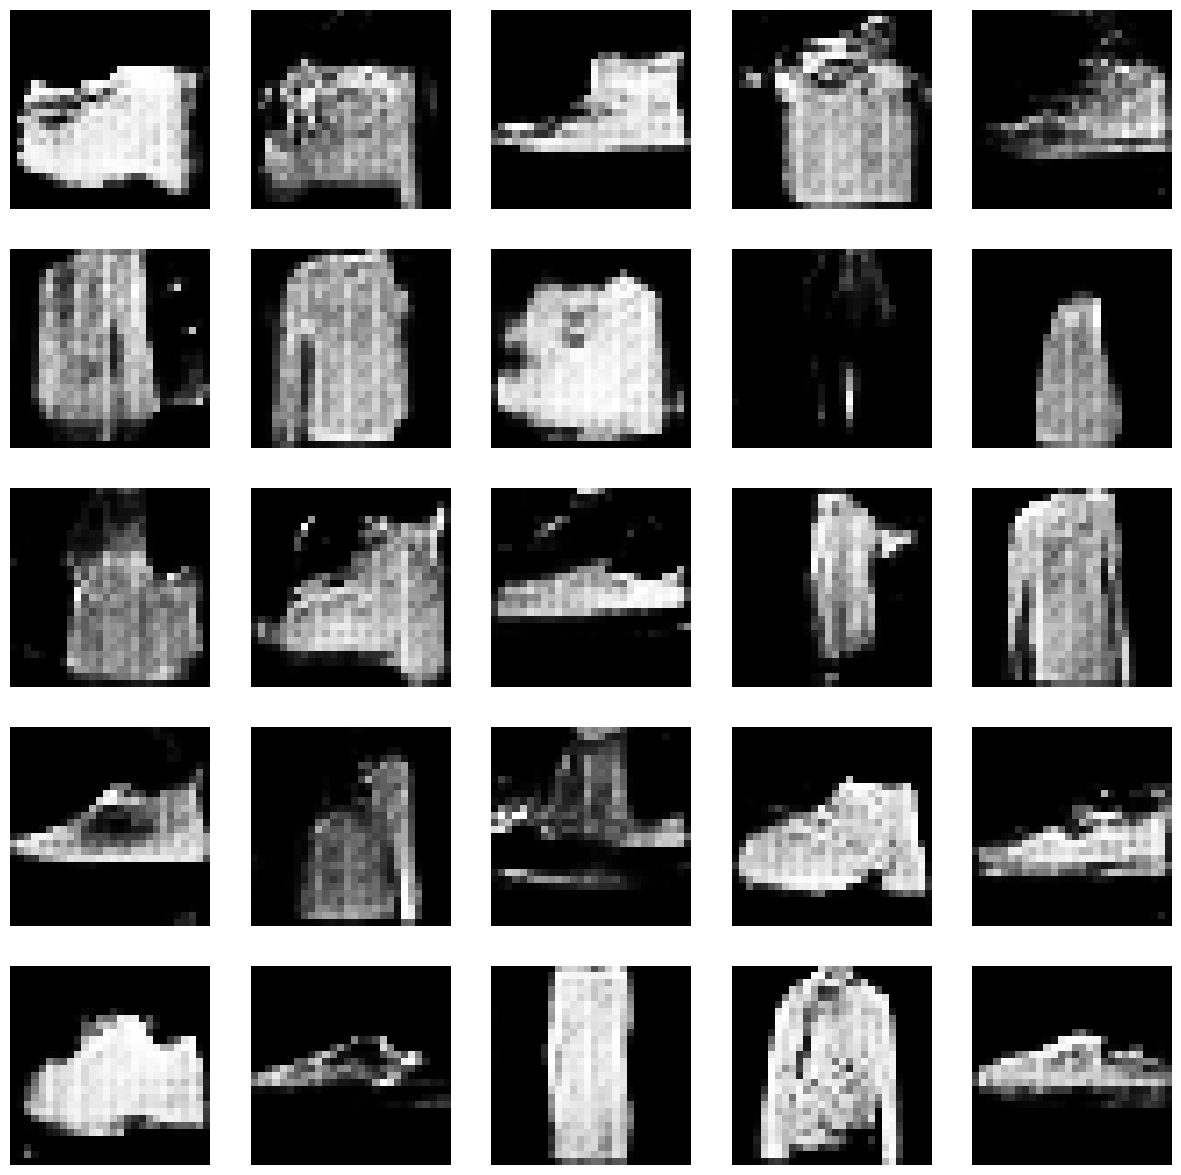

Epoch:  50


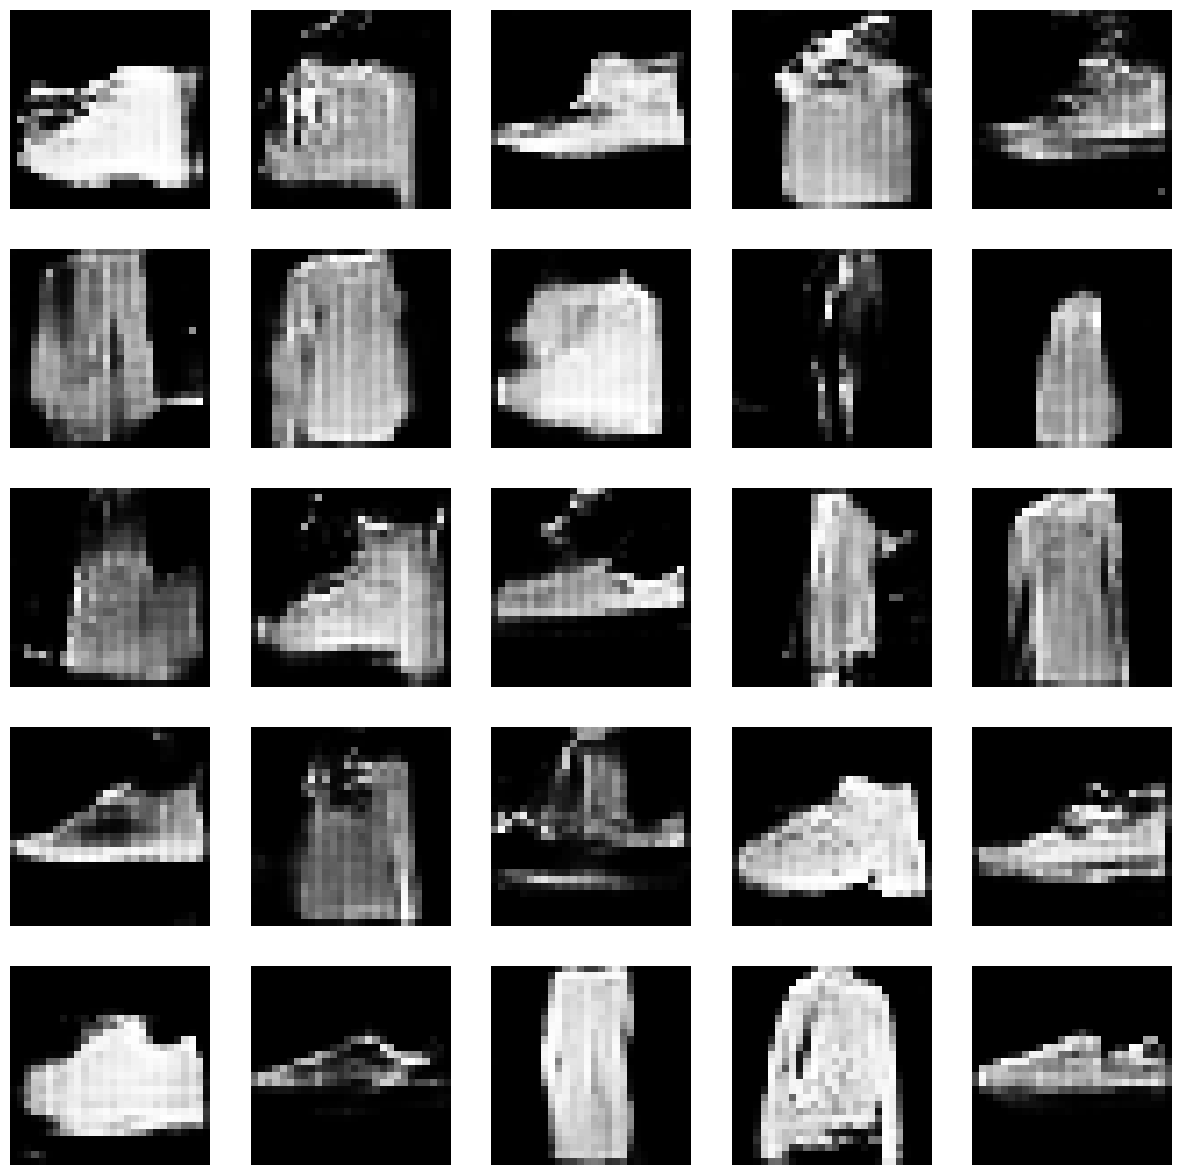

In [80]:
train_visualize_DCGAN(data = X_train, test_images = tf.random.normal([25, 100]))

## Congratulations, you have understood how to work with DCGANs